<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
X_test = pd.read_csv('./test.csv')

Посмотрим на случайные 5 строк data.

In [6]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4738,11,65.15,723.35,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),0
58,40,20.15,804.85,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4009,26,81.90,2078.55,Female,0,Yes,No,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),0
1639,48,99.00,4744.35,Male,1,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,Yes,Electronic check,0
3006,20,94.55,1899.65,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1


Теперь посмотрим основную информацию о датасете.

Размер датасета:

In [7]:
data.shape

(5282, 20)

Типы признаков:

In [8]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [9]:
data[cat_cols] = data[cat_cols].astype("category")

In [10]:
data.dtypes

ClientPeriod                   int64
MonthlySpending              float64
TotalSpent                    object
Sex                         category
IsSeniorCitizen             category
HasPartner                  category
HasChild                    category
HasPhoneService             category
HasMultiplePhoneNumbers     category
HasInternetService          category
HasOnlineSecurityService    category
HasOnlineBackup             category
HasDeviceProtection         category
HasTechSupportAccess        category
HasOnlineTV                 category
HasMovieSubscription        category
HasContractPhone            category
IsBillingPaperless          category
PaymentMethod               category
Churn                          int64
dtype: object

Количество NaN значений в каждом признаке:

In [11]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Стоит также проверить, есть ли в датасете "пустые" значения. Заменим их на NaN и посмотрим на количество таковых в каждом признаке:

In [12]:
data.replace(" ", np.nan).isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Значение признака TotalSpent для 9 объектов не определено, поэтому посмотрим внимательнее на остальные их признаки.

In [13]:
data.sort_values('TotalSpent').head(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
3343,5,24.30,100.2,Male,0,No,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,0


Судя по тому, что у каждого из людей, для которых значение TotalSpent не определено, ClientPeriod равен 0, можно сделать вывод, что они просто еще не успели потратить деньги на услуги компании. Можно считать, что для них TotalSpent также равен 0.

In [14]:
data["TotalSpent"] = data.TotalSpent.replace(" ", np.nan).fillna(0).astype(float)
X_test["TotalSpent"] = X_test.TotalSpent.replace(" ", np.nan).fillna(0).astype(float)

In [15]:
y_train = data[target_col]
X_train = data[feature_cols]

In [16]:
X_train.shape

(5282, 19)

In [17]:
y_train.shape

(5282,)

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

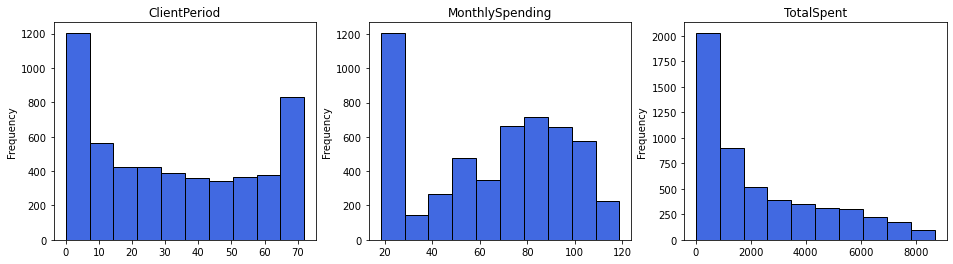

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (16, 4))

for ax, col in zip(axes, num_cols):
    ax.set_title(col)
    data[col].plot(kind = "hist", ec = "black", ax = ax, color = 'royalblue')

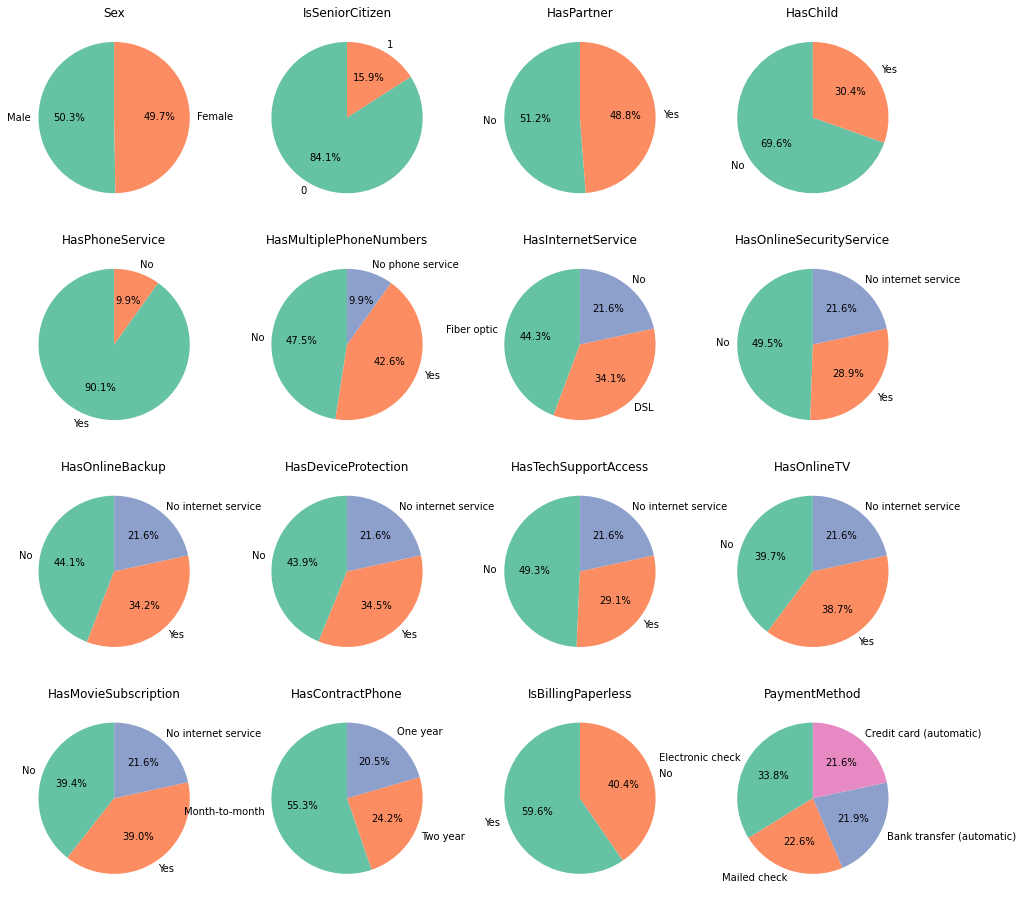

In [19]:
fig, axes = plt.subplots(4, 4, figsize = (16, 16))

for ax, col in zip(axes.flatten(), cat_cols):
    ax.set_title(col)
    ax.pie(data[col].value_counts(), 
           autopct = "%0.1f%%", 
           labels = data[col].value_counts().index, 
           startangle = 90,
           colors = sns.color_palette('Set2'))

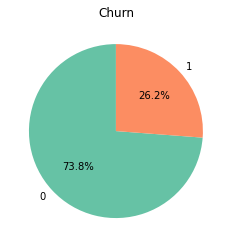

In [20]:
fig = plt.figure(figsize = (5, 4))
plt.pie(data[target_col].value_counts(), 
       autopct = "%0.1f%%", 
       labels = data[target_col].value_counts().index, 
       startangle = 90,
       colors = sns.color_palette('Set2'))
plt.title(target_col);

Распределение классов является достаточно сбалансированным (примерно 1 к 3), поэтому не будем использовать дополнительных методов борьбы с несбалансированными классами.

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [21]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [22]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

Посмотрим на корреляцию между признаками и целевой переменной.

In [23]:
data_cat = data.copy()
X_test_cat = X_test.copy()
label_encoder = LabelEncoder()

data_cat[cat_cols] = data_cat[cat_cols].apply(label_encoder.fit_transform)
X_test_cat[cat_cols] = X_test_cat[cat_cols].apply(label_encoder.fit_transform)

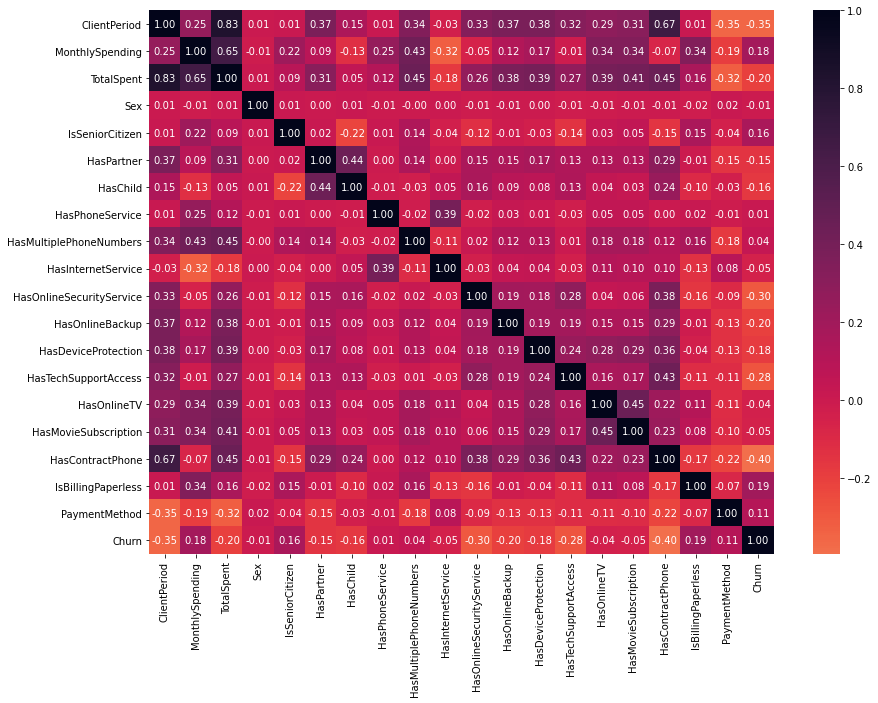

In [24]:
fig = plt.figure(figsize = (14, 10))
sns.heatmap(data_cat.corr(), annot = True, fmt = "0.2f", center = 0, cmap = "rocket_r");

Можем наблюдать наибольшую корреляцию с целевой переменной у следующих признаков: HasContractPhone, ClientPeriod, HasOnlineSecurityService.

In [25]:
data_cat = pd.get_dummies(data_cat, columns = cat_cols)

In [26]:
X_test_cat = pd.get_dummies(X_test_cat, columns = cat_cols)

In [27]:
y_train_cat = data_cat[target_col]
X_train_cat = data_cat.drop(target_col, axis = 1)

### Logistic Regression

In [28]:
params = {"model__C": np.arange(0.001, 100, 0.1)}

clf = Pipeline(steps = [
    ("scaler", StandardScaler()),
    ("model", LogisticRegression())
])
               
grid_search = GridSearchCV(
    estimator = clf,
    param_grid = params,
    scoring = "roc_auc",
    n_jobs = -1,
    cv = 5,
    refit = True
)

In [29]:
logreg = grid_search.fit(X_train_cat, y_train_cat)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [30]:
print('The best ROC-AUC score is %0.4f' % logreg.best_score_)
print('The best param C is %0.4f' % logreg.best_params_['model__C'])

The best ROC-AUC score is 0.8451
The best param C is 17.4010


In [31]:
submission = pd.read_csv('./submission.csv', index_col = 'Id')

submission['Churn'] = logreg.predict_proba(X_test_cat)[:, 1]
submission.to_csv('./logreg.csv')

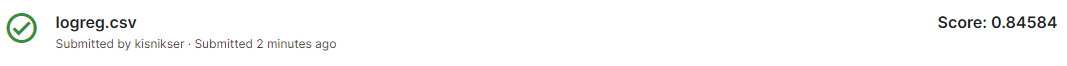

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [32]:
from catboost import CatBoostClassifier

In [33]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True)

### CatBoost (default parameters)

In [34]:
catboost = CatBoostClassifier(
    cat_features = cat_cols,
    custom_loss = "AUC"
)

catboost.fit(
    X_train_1,
    y_train_1,
    eval_set = (X_valid_1, y_valid_1), # валидационный датасет
    verbose = False, # в stdout не выводятся логи
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
roc_auc = roc_auc_score(y_valid_1, catboost.predict(X_valid_1))
print('ROC-AUC score со стандартными параметрами catboost равен %0.4f' % roc_auc)

ROC-AUC score со стандартными параметрами catboost равен 0.7217


Теперь будем перебирать параметры и выберем лучшую по метрике ROC-AUC комбинацию.

### CatBoost (grid search)

In [36]:
param_grid = {
    "iterations": [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.3, 0.5]
}

In [37]:
catboost = CatBoostClassifier(
    cat_features = cat_cols,
    loss_function = "Logloss", # функция потерь для градиента
    eval_metric = "AUC:hints=skip_train~false", # метрика, используемая для распознавания переобучения и выбора лучшей модели
    grow_policy = "Lossguide", # стратегия построения деревьев, Lossguide - выбор лучшего листа для разбиения
    boosting_type = 'Plain', # более быстрый вариант, чем boosting_type = 'Ordered'
    bootstrap_type = 'Bernoulli',
    subsample = 0.5,
    rsm = 0.5,
    one_hot_max_size = 20
)

In [38]:
catboost.grid_search(
    param_grid,
    X_train,
    y_train,
    cv = 5,
    plot = True,
    verbose = False,
    refit = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 4.19ms	remaining: 16.8ms
1:	learn: 0.8260586	test: 0.8481911	best: 0.8481911 (1)	total: 8.59ms	remaining: 12.9ms
2:	learn: 0.8339284	test: 0.8578829	best: 0.8578829 (2)	total: 12.6ms	remaining: 8.37ms
3:	learn: 0.8374947	test: 0.8654061	best: 0.8654061 (3)	total: 16.5ms	remaining: 4.12ms
4:	learn: 0.8402252	test: 0.8630441	best: 0.8654061 (3)	total: 20.7ms	remaining: 0us

bestTest = 0.8654061103
bestIteration = 3

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 3.97ms	remaining: 15.9ms
1:	learn: 0.8312031	test: 0.8494975	best: 0.8494975 (1)	total: 8.4ms	remaining: 12.6ms
2:	learn: 0.8364795	test: 0.8538060	best: 0.8538060 (2)	total: 12.4ms	remaining: 8.29ms
3:	learn: 0.8366375	test: 0.8570541	best: 0.8570541 (3)	total: 16.5ms	remaining: 4.12ms
4:	learn: 0.8377060	test: 0.8629342	best: 0.8629342 (4)	total: 20.5ms	remaining: 0us

bestTest = 0.862934197
bestIteration = 4

0:	learn: 0.8089113	test: 0.8405413	best

2:	learn: 0.8438915	test: 0.8632041	best: 0.8632041 (2)	total: 12.1ms	remaining: 28.2ms
3:	learn: 0.8483891	test: 0.8643385	best: 0.8643385 (3)	total: 16.3ms	remaining: 24.4ms
4:	learn: 0.8516567	test: 0.8628482	best: 0.8643385 (3)	total: 20.3ms	remaining: 20.3ms
5:	learn: 0.8560214	test: 0.8642955	best: 0.8643385 (3)	total: 24.5ms	remaining: 16.4ms
6:	learn: 0.8582361	test: 0.8623706	best: 0.8643385 (3)	total: 28.7ms	remaining: 12.3ms
7:	learn: 0.8601419	test: 0.8632136	best: 0.8643385 (3)	total: 32.8ms	remaining: 8.2ms
8:	learn: 0.8613552	test: 0.8637367	best: 0.8643385 (3)	total: 36.9ms	remaining: 4.1ms
9:	learn: 0.8636147	test: 0.8636770	best: 0.8643385 (3)	total: 40.9ms	remaining: 0us

bestTest = 0.8643385303
bestIteration = 3

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 3.98ms	remaining: 75.6ms
1:	learn: 0.8260586	test: 0.8481911	best: 0.8481911 (1)	total: 8.2ms	remaining: 73.8ms
2:	learn: 0.8339284	test: 0.8578829	best: 0.8578829 (2)	total: 12.3ms	remaining: 6

18:	learn: 0.8579972	test: 0.8673383	best: 0.8673383 (18)	total: 80.4ms	remaining: 4.23ms
19:	learn: 0.8590151	test: 0.8673192	best: 0.8673383 (18)	total: 84.9ms	remaining: 0us

bestTest = 0.8673382628
bestIteration = 18

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 3.98ms	remaining: 75.6ms
1:	learn: 0.8273111	test: 0.8492205	best: 0.8492205 (1)	total: 8.11ms	remaining: 73ms
2:	learn: 0.8309535	test: 0.8535457	best: 0.8535457 (2)	total: 11.7ms	remaining: 66.5ms
3:	learn: 0.8356207	test: 0.8548020	best: 0.8548020 (3)	total: 15.8ms	remaining: 63.3ms
4:	learn: 0.8416521	test: 0.8605053	best: 0.8605053 (4)	total: 19.9ms	remaining: 59.6ms
5:	learn: 0.8450837	test: 0.8634023	best: 0.8634023 (5)	total: 23.8ms	remaining: 55.5ms
6:	learn: 0.8461603	test: 0.8647565	best: 0.8647565 (6)	total: 27.7ms	remaining: 51.5ms
7:	learn: 0.8480298	test: 0.8664689	best: 0.8664689 (7)	total: 32.2ms	remaining: 48.3ms
8:	learn: 0.8501837	test: 0.8676440	best: 0.8676440 (8)	total: 36.3ms	remain

23:	learn: 0.8476954	test: 0.8701183	best: 0.8709112 (20)	total: 96.3ms	remaining: 24.1ms
24:	learn: 0.8482343	test: 0.8700633	best: 0.8709112 (20)	total: 100ms	remaining: 20.1ms
25:	learn: 0.8487757	test: 0.8703905	best: 0.8709112 (20)	total: 104ms	remaining: 16.1ms
26:	learn: 0.8489769	test: 0.8705482	best: 0.8709112 (20)	total: 109ms	remaining: 12.1ms
27:	learn: 0.8493142	test: 0.8710999	best: 0.8710999 (27)	total: 113ms	remaining: 8.04ms
28:	learn: 0.8492690	test: 0.8713268	best: 0.8713268 (28)	total: 116ms	remaining: 4.01ms
29:	learn: 0.8496002	test: 0.8714223	best: 0.8714223 (29)	total: 121ms	remaining: 0us

bestTest = 0.8714222936
bestIteration = 29

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 3.87ms	remaining: 112ms
1:	learn: 0.8316465	test: 0.8499178	best: 0.8499178 (1)	total: 8.08ms	remaining: 113ms
2:	learn: 0.8371285	test: 0.8555758	best: 0.8555758 (2)	total: 12.1ms	remaining: 109ms
3:	learn: 0.8371142	test: 0.8576488	best: 0.8576488 (3)	total: 16ms	remai

10:	learn: 0.8540058	test: 0.8671950	best: 0.8676440 (8)	total: 45.2ms	remaining: 78.2ms
11:	learn: 0.8557366	test: 0.8672021	best: 0.8676440 (8)	total: 52.1ms	remaining: 78.2ms
12:	learn: 0.8580776	test: 0.8671066	best: 0.8676440 (8)	total: 56.2ms	remaining: 73.5ms
13:	learn: 0.8592618	test: 0.8659148	best: 0.8676440 (8)	total: 60.3ms	remaining: 68.9ms
14:	learn: 0.8614611	test: 0.8656903	best: 0.8676440 (8)	total: 64.6ms	remaining: 64.6ms
15:	learn: 0.8628400	test: 0.8656569	best: 0.8676440 (8)	total: 68.5ms	remaining: 59.9ms
16:	learn: 0.8638182	test: 0.8656640	best: 0.8676440 (8)	total: 72.6ms	remaining: 55.5ms
17:	learn: 0.8651366	test: 0.8660486	best: 0.8676440 (8)	total: 76.9ms	remaining: 51.3ms
18:	learn: 0.8661783	test: 0.8668534	best: 0.8676440 (8)	total: 80.9ms	remaining: 46.9ms
19:	learn: 0.8673633	test: 0.8666982	best: 0.8676440 (8)	total: 85.5ms	remaining: 42.8ms
20:	learn: 0.8684039	test: 0.8668176	best: 0.8676440 (8)	total: 89.6ms	remaining: 38.4ms
21:	learn: 0.8700572	

30:	learn: 0.8483874	test: 0.8699750	best: 0.8703380 (28)	total: 128ms	remaining: 37.1ms
31:	learn: 0.8485003	test: 0.8705721	best: 0.8705721 (31)	total: 132ms	remaining: 33ms
32:	learn: 0.8484413	test: 0.8706246	best: 0.8706246 (32)	total: 136ms	remaining: 28.9ms
33:	learn: 0.8483742	test: 0.8707058	best: 0.8707058 (33)	total: 140ms	remaining: 24.7ms
34:	learn: 0.8484813	test: 0.8707154	best: 0.8707154 (34)	total: 144ms	remaining: 20.6ms
35:	learn: 0.8484936	test: 0.8706628	best: 0.8707154 (34)	total: 149ms	remaining: 16.5ms
36:	learn: 0.8488092	test: 0.8704622	best: 0.8707154 (34)	total: 153ms	remaining: 12.4ms
37:	learn: 0.8488483	test: 0.8705529	best: 0.8707154 (34)	total: 157ms	remaining: 8.25ms
38:	learn: 0.8492104	test: 0.8707583	best: 0.8707583 (38)	total: 161ms	remaining: 4.13ms
39:	learn: 0.8493293	test: 0.8706819	best: 0.8707583 (38)	total: 166ms	remaining: 0us

bestTest = 0.87075834
bestIteration = 38

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 4.11ms	re

17:	learn: 0.8550848	test: 0.8701565	best: 0.8705482 (16)	total: 72.6ms	remaining: 88.7ms
18:	learn: 0.8558188	test: 0.8702472	best: 0.8705482 (16)	total: 76.9ms	remaining: 85ms
19:	learn: 0.8562762	test: 0.8701398	best: 0.8705482 (16)	total: 81ms	remaining: 81ms
20:	learn: 0.8569988	test: 0.8695761	best: 0.8705482 (16)	total: 85.3ms	remaining: 77.2ms
21:	learn: 0.8573995	test: 0.8695713	best: 0.8705482 (16)	total: 89.5ms	remaining: 73.2ms
22:	learn: 0.8577965	test: 0.8695570	best: 0.8705482 (16)	total: 93.3ms	remaining: 69ms
23:	learn: 0.8583102	test: 0.8693564	best: 0.8705482 (16)	total: 97.2ms	remaining: 64.8ms
24:	learn: 0.8588216	test: 0.8693468	best: 0.8705482 (16)	total: 101ms	remaining: 60.7ms
25:	learn: 0.8598824	test: 0.8696693	best: 0.8705482 (16)	total: 105ms	remaining: 56.8ms
26:	learn: 0.8603134	test: 0.8695642	best: 0.8705482 (16)	total: 110ms	remaining: 52.8ms
27:	learn: 0.8610941	test: 0.8697696	best: 0.8705482 (16)	total: 114ms	remaining: 48.8ms
28:	learn: 0.8619250	t

9:	learn: 0.8587122	test: 0.8583367	best: 0.8599870 (6)	total: 40.4ms	remaining: 121ms
10:	learn: 0.8612313	test: 0.8593517	best: 0.8599870 (6)	total: 44.5ms	remaining: 117ms
11:	learn: 0.8628426	test: 0.8597983	best: 0.8599870 (6)	total: 48.5ms	remaining: 113ms
12:	learn: 0.8644498	test: 0.8608611	best: 0.8608611 (12)	total: 52.5ms	remaining: 109ms
13:	learn: 0.8654292	test: 0.8611573	best: 0.8611573 (13)	total: 56.4ms	remaining: 105ms
14:	learn: 0.8675571	test: 0.8616875	best: 0.8616875 (14)	total: 60.8ms	remaining: 101ms
15:	learn: 0.8683571	test: 0.8620457	best: 0.8620457 (15)	total: 64.6ms	remaining: 96.9ms
16:	learn: 0.8697241	test: 0.8615657	best: 0.8620457 (15)	total: 68.9ms	remaining: 93.3ms
17:	learn: 0.8712619	test: 0.8616349	best: 0.8620457 (15)	total: 73.1ms	remaining: 89.4ms
18:	learn: 0.8722222	test: 0.8619956	best: 0.8620457 (15)	total: 77.3ms	remaining: 85.4ms
19:	learn: 0.8735703	test: 0.8607513	best: 0.8620457 (15)	total: 81.4ms	remaining: 81.4ms
20:	learn: 0.8752193

34:	learn: 0.8484813	test: 0.8707154	best: 0.8707154 (34)	total: 142ms	remaining: 60.8ms
35:	learn: 0.8484936	test: 0.8706628	best: 0.8707154 (34)	total: 146ms	remaining: 56.7ms
36:	learn: 0.8488092	test: 0.8704622	best: 0.8707154 (34)	total: 150ms	remaining: 52.6ms
37:	learn: 0.8488483	test: 0.8705529	best: 0.8707154 (34)	total: 154ms	remaining: 48.5ms
38:	learn: 0.8492104	test: 0.8707583	best: 0.8707583 (38)	total: 158ms	remaining: 44.5ms
39:	learn: 0.8493293	test: 0.8706819	best: 0.8707583 (38)	total: 162ms	remaining: 40.6ms
40:	learn: 0.8495520	test: 0.8709876	best: 0.8709876 (40)	total: 166ms	remaining: 36.5ms
41:	learn: 0.8496096	test: 0.8705482	best: 0.8709876 (40)	total: 170ms	remaining: 32.5ms
42:	learn: 0.8496193	test: 0.8705577	best: 0.8709876 (40)	total: 174ms	remaining: 28.4ms
43:	learn: 0.8496485	test: 0.8701278	best: 0.8709876 (40)	total: 178ms	remaining: 24.3ms
44:	learn: 0.8496163	test: 0.8695737	best: 0.8709876 (40)	total: 182ms	remaining: 20.3ms
45:	learn: 0.8497852	

45:	learn: 0.8626300	test: 0.8725782	best: 0.8727335 (41)	total: 197ms	remaining: 17.1ms
46:	learn: 0.8629555	test: 0.8724923	best: 0.8727335 (41)	total: 203ms	remaining: 12.9ms
47:	learn: 0.8632318	test: 0.8725161	best: 0.8727335 (41)	total: 207ms	remaining: 8.62ms
48:	learn: 0.8635312	test: 0.8725209	best: 0.8727335 (41)	total: 211ms	remaining: 4.31ms
49:	learn: 0.8639335	test: 0.8725066	best: 0.8727335 (41)	total: 215ms	remaining: 0us

bestTest = 0.8727334824
bestIteration = 41

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 3.92ms	remaining: 192ms
1:	learn: 0.8312767	test: 0.8511454	best: 0.8511454 (1)	total: 8.07ms	remaining: 194ms
2:	learn: 0.8349800	test: 0.8505293	best: 0.8511454 (1)	total: 12.1ms	remaining: 189ms
3:	learn: 0.8356802	test: 0.8516780	best: 0.8516780 (3)	total: 15.7ms	remaining: 181ms
4:	learn: 0.8378560	test: 0.8566051	best: 0.8566051 (4)	total: 20ms	remaining: 180ms
5:	learn: 0.8403163	test: 0.8591296	best: 0.8591296 (5)	total: 24.1ms	remaining:

2:	learn: 0.8309535	test: 0.8535457	best: 0.8535457 (2)	total: 11.8ms	remaining: 185ms
3:	learn: 0.8356207	test: 0.8548020	best: 0.8548020 (3)	total: 15.8ms	remaining: 182ms
4:	learn: 0.8416521	test: 0.8605053	best: 0.8605053 (4)	total: 19.6ms	remaining: 176ms
5:	learn: 0.8450837	test: 0.8634023	best: 0.8634023 (5)	total: 23.5ms	remaining: 173ms
6:	learn: 0.8461603	test: 0.8647565	best: 0.8647565 (6)	total: 27.7ms	remaining: 170ms
7:	learn: 0.8480298	test: 0.8664689	best: 0.8664689 (7)	total: 31.8ms	remaining: 167ms
8:	learn: 0.8501837	test: 0.8676440	best: 0.8676440 (8)	total: 35.9ms	remaining: 164ms
9:	learn: 0.8516422	test: 0.8669728	best: 0.8676440 (8)	total: 40.2ms	remaining: 161ms
10:	learn: 0.8540058	test: 0.8671950	best: 0.8676440 (8)	total: 44ms	remaining: 156ms
11:	learn: 0.8557366	test: 0.8672021	best: 0.8676440 (8)	total: 48.2ms	remaining: 153ms
12:	learn: 0.8580776	test: 0.8671066	best: 0.8676440 (8)	total: 52.2ms	remaining: 149ms
13:	learn: 0.8592618	test: 0.8659148	best:

14:	learn: 0.8764231	test: 0.8585206	best: 0.8643385 (3)	total: 62.7ms	remaining: 146ms
15:	learn: 0.8784603	test: 0.8572954	best: 0.8643385 (3)	total: 66.7ms	remaining: 142ms
16:	learn: 0.8797796	test: 0.8564045	best: 0.8643385 (3)	total: 70.9ms	remaining: 138ms
17:	learn: 0.8821969	test: 0.8557358	best: 0.8643385 (3)	total: 74.8ms	remaining: 133ms
18:	learn: 0.8844493	test: 0.8543649	best: 0.8643385 (3)	total: 79ms	remaining: 129ms
19:	learn: 0.8877825	test: 0.8535935	best: 0.8643385 (3)	total: 83.2ms	remaining: 125ms
20:	learn: 0.8909295	test: 0.8517115	best: 0.8643385 (3)	total: 87.8ms	remaining: 121ms
21:	learn: 0.8951389	test: 0.8516279	best: 0.8643385 (3)	total: 92.2ms	remaining: 117ms
22:	learn: 0.8979625	test: 0.8515992	best: 0.8643385 (3)	total: 96.3ms	remaining: 113ms
23:	learn: 0.8995464	test: 0.8524853	best: 0.8643385 (3)	total: 100ms	remaining: 109ms
24:	learn: 0.9031806	test: 0.8501161	best: 0.8643385 (3)	total: 105ms	remaining: 105ms
25:	learn: 0.9062119	test: 0.8499561


bestTest = 0.8709876189
bestIteration = 40

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 4.17ms	remaining: 288ms
1:	learn: 0.8312031	test: 0.8494975	best: 0.8494975 (1)	total: 8.26ms	remaining: 281ms
2:	learn: 0.8364795	test: 0.8538060	best: 0.8538060 (2)	total: 12.2ms	remaining: 272ms
3:	learn: 0.8366375	test: 0.8570541	best: 0.8570541 (3)	total: 16.1ms	remaining: 266ms
4:	learn: 0.8377060	test: 0.8629342	best: 0.8629342 (4)	total: 20.2ms	remaining: 263ms
5:	learn: 0.8389949	test: 0.8642382	best: 0.8642382 (5)	total: 24.2ms	remaining: 259ms
6:	learn: 0.8385494	test: 0.8641881	best: 0.8642382 (5)	total: 28.3ms	remaining: 255ms
7:	learn: 0.8393244	test: 0.8634357	best: 0.8642382 (5)	total: 32.3ms	remaining: 250ms
8:	learn: 0.8410921	test: 0.8651219	best: 0.8651219 (8)	total: 36.4ms	remaining: 246ms
9:	learn: 0.8417673	test: 0.8648186	best: 0.8651219 (8)	total: 40.2ms	remaining: 241ms
10:	learn: 0.8426400	test: 0.8658217	best: 0.8658217 (10)	total: 44.1ms	remaining: 23

45:	learn: 0.8626300	test: 0.8725782	best: 0.8727335 (41)	total: 190ms	remaining: 99.2ms
46:	learn: 0.8629555	test: 0.8724923	best: 0.8727335 (41)	total: 194ms	remaining: 95ms
47:	learn: 0.8632318	test: 0.8725161	best: 0.8727335 (41)	total: 198ms	remaining: 90.8ms
48:	learn: 0.8635312	test: 0.8725209	best: 0.8727335 (41)	total: 204ms	remaining: 87.3ms
49:	learn: 0.8639335	test: 0.8725066	best: 0.8727335 (41)	total: 208ms	remaining: 83.1ms
50:	learn: 0.8641037	test: 0.8724254	best: 0.8727335 (41)	total: 212ms	remaining: 79ms
51:	learn: 0.8645261	test: 0.8725114	best: 0.8727335 (41)	total: 216ms	remaining: 74.8ms
52:	learn: 0.8648914	test: 0.8724254	best: 0.8727335 (41)	total: 220ms	remaining: 70.6ms
53:	learn: 0.8651810	test: 0.8724445	best: 0.8727335 (41)	total: 224ms	remaining: 66.3ms
54:	learn: 0.8654332	test: 0.8724349	best: 0.8727335 (41)	total: 228ms	remaining: 62.1ms
55:	learn: 0.8655960	test: 0.8725018	best: 0.8727335 (41)	total: 232ms	remaining: 57.9ms
56:	learn: 0.8658004	test

12:	learn: 0.8519132	test: 0.8635265	best: 0.8644508 (11)	total: 52.5ms	remaining: 230ms
13:	learn: 0.8538064	test: 0.8638704	best: 0.8644508 (11)	total: 56.6ms	remaining: 226ms
14:	learn: 0.8549474	test: 0.8643003	best: 0.8644508 (11)	total: 60.7ms	remaining: 222ms
15:	learn: 0.8559518	test: 0.8657620	best: 0.8657620 (15)	total: 64.7ms	remaining: 218ms
16:	learn: 0.8570948	test: 0.8661560	best: 0.8661560 (16)	total: 69.2ms	remaining: 216ms
17:	learn: 0.8577384	test: 0.8671687	best: 0.8671687 (17)	total: 73.1ms	remaining: 211ms
18:	learn: 0.8579972	test: 0.8673383	best: 0.8673383 (18)	total: 77.2ms	remaining: 207ms
19:	learn: 0.8590151	test: 0.8673192	best: 0.8673383 (18)	total: 81.4ms	remaining: 203ms
20:	learn: 0.8597165	test: 0.8677061	best: 0.8677061 (20)	total: 85.1ms	remaining: 199ms
21:	learn: 0.8600497	test: 0.8678279	best: 0.8678279 (21)	total: 89.4ms	remaining: 195ms
22:	learn: 0.8609356	test: 0.8682028	best: 0.8682028 (22)	total: 93.7ms	remaining: 191ms
23:	learn: 0.8616927	

53:	learn: 0.9037014	test: 0.8617615	best: 0.8676440 (8)	total: 237ms	remaining: 70.3ms
54:	learn: 0.9056630	test: 0.8605674	best: 0.8676440 (8)	total: 242ms	remaining: 65.9ms
55:	learn: 0.9067624	test: 0.8604288	best: 0.8676440 (8)	total: 246ms	remaining: 61.6ms
56:	learn: 0.9081164	test: 0.8597219	best: 0.8676440 (8)	total: 251ms	remaining: 57.2ms
57:	learn: 0.9088690	test: 0.8589911	best: 0.8676440 (8)	total: 255ms	remaining: 52.7ms
58:	learn: 0.9103550	test: 0.8581814	best: 0.8676440 (8)	total: 259ms	remaining: 48.3ms
59:	learn: 0.9116179	test: 0.8578805	best: 0.8676440 (8)	total: 263ms	remaining: 43.9ms
60:	learn: 0.9135445	test: 0.8573837	best: 0.8676440 (8)	total: 268ms	remaining: 39.5ms
61:	learn: 0.9147390	test: 0.8575509	best: 0.8676440 (8)	total: 272ms	remaining: 35.1ms
62:	learn: 0.9160701	test: 0.8570589	best: 0.8676440 (8)	total: 276ms	remaining: 30.7ms
63:	learn: 0.9174993	test: 0.8567413	best: 0.8676440 (8)	total: 280ms	remaining: 26.3ms
64:	learn: 0.9182849	test: 0.856

15:	learn: 0.8784603	test: 0.8572954	best: 0.8643385 (3)	total: 74.5ms	remaining: 251ms
16:	learn: 0.8797796	test: 0.8564045	best: 0.8643385 (3)	total: 79.3ms	remaining: 247ms
17:	learn: 0.8821969	test: 0.8557358	best: 0.8643385 (3)	total: 84ms	remaining: 243ms
18:	learn: 0.8844493	test: 0.8543649	best: 0.8643385 (3)	total: 88.2ms	remaining: 237ms
19:	learn: 0.8877825	test: 0.8535935	best: 0.8643385 (3)	total: 92.8ms	remaining: 232ms
20:	learn: 0.8909295	test: 0.8517115	best: 0.8643385 (3)	total: 101ms	remaining: 235ms
21:	learn: 0.8951389	test: 0.8516279	best: 0.8643385 (3)	total: 106ms	remaining: 232ms
22:	learn: 0.8979625	test: 0.8515992	best: 0.8643385 (3)	total: 110ms	remaining: 226ms
23:	learn: 0.8995464	test: 0.8524853	best: 0.8643385 (3)	total: 115ms	remaining: 220ms
24:	learn: 0.9031806	test: 0.8501161	best: 0.8643385 (3)	total: 119ms	remaining: 214ms
25:	learn: 0.9062119	test: 0.8499561	best: 0.8643385 (3)	total: 123ms	remaining: 209ms
26:	learn: 0.9096339	test: 0.8521533	bes

50:	learn: 0.8504766	test: 0.8697433	best: 0.8709876 (40)	total: 216ms	remaining: 207ms
51:	learn: 0.8505984	test: 0.8697576	best: 0.8709876 (40)	total: 219ms	remaining: 202ms
52:	learn: 0.8507485	test: 0.8694663	best: 0.8709876 (40)	total: 224ms	remaining: 198ms
53:	learn: 0.8507669	test: 0.8696717	best: 0.8709876 (40)	total: 228ms	remaining: 194ms
54:	learn: 0.8507422	test: 0.8700395	best: 0.8709876 (40)	total: 232ms	remaining: 190ms
55:	learn: 0.8507898	test: 0.8699750	best: 0.8709876 (40)	total: 236ms	remaining: 185ms
56:	learn: 0.8509623	test: 0.8699606	best: 0.8709876 (40)	total: 240ms	remaining: 181ms
57:	learn: 0.8511230	test: 0.8703523	best: 0.8709876 (40)	total: 244ms	remaining: 177ms
58:	learn: 0.8511794	test: 0.8706628	best: 0.8709876 (40)	total: 248ms	remaining: 172ms
59:	learn: 0.8511992	test: 0.8709112	best: 0.8709876 (40)	total: 253ms	remaining: 168ms
60:	learn: 0.8511783	test: 0.8706556	best: 0.8709876 (40)	total: 258ms	remaining: 165ms
61:	learn: 0.8513045	test: 0.870

56:	learn: 0.8566681	test: 0.8728625	best: 0.8729245 (53)	total: 233ms	remaining: 176ms
57:	learn: 0.8569716	test: 0.8728529	best: 0.8729245 (53)	total: 237ms	remaining: 172ms
58:	learn: 0.8573224	test: 0.8727574	best: 0.8729245 (53)	total: 241ms	remaining: 167ms
59:	learn: 0.8574458	test: 0.8731538	best: 0.8731538 (59)	total: 245ms	remaining: 163ms
60:	learn: 0.8576347	test: 0.8728577	best: 0.8731538 (59)	total: 249ms	remaining: 159ms
61:	learn: 0.8578228	test: 0.8728290	best: 0.8731538 (59)	total: 253ms	remaining: 155ms
62:	learn: 0.8581004	test: 0.8730678	best: 0.8731538 (59)	total: 257ms	remaining: 151ms
63:	learn: 0.8582593	test: 0.8728529	best: 0.8731538 (59)	total: 261ms	remaining: 147ms
64:	learn: 0.8584282	test: 0.8724851	best: 0.8731538 (59)	total: 265ms	remaining: 143ms
65:	learn: 0.8588436	test: 0.8723179	best: 0.8731538 (59)	total: 269ms	remaining: 139ms
66:	learn: 0.8590384	test: 0.8721698	best: 0.8731538 (59)	total: 273ms	remaining: 135ms
67:	learn: 0.8591773	test: 0.872

73:	learn: 0.8707170	test: 0.8712479	best: 0.8727335 (41)	total: 303ms	remaining: 107ms
74:	learn: 0.8710152	test: 0.8713053	best: 0.8727335 (41)	total: 307ms	remaining: 102ms
75:	learn: 0.8712657	test: 0.8709709	best: 0.8727335 (41)	total: 311ms	remaining: 98.3ms
76:	learn: 0.8715885	test: 0.8711572	best: 0.8727335 (41)	total: 315ms	remaining: 94.1ms
77:	learn: 0.8719649	test: 0.8711954	best: 0.8727335 (41)	total: 319ms	remaining: 90.1ms
78:	learn: 0.8721308	test: 0.8712432	best: 0.8727335 (41)	total: 324ms	remaining: 86ms
79:	learn: 0.8722691	test: 0.8713674	best: 0.8727335 (41)	total: 328ms	remaining: 81.9ms
80:	learn: 0.8723815	test: 0.8712623	best: 0.8727335 (41)	total: 332ms	remaining: 77.9ms
81:	learn: 0.8725411	test: 0.8712862	best: 0.8727335 (41)	total: 336ms	remaining: 73.8ms
82:	learn: 0.8728502	test: 0.8711333	best: 0.8727335 (41)	total: 340ms	remaining: 69.7ms
83:	learn: 0.8730492	test: 0.8711046	best: 0.8727335 (41)	total: 344ms	remaining: 65.6ms
84:	learn: 0.8732678	test

79:	learn: 0.8806122	test: 0.8656091	best: 0.8706485 (29)	total: 332ms	remaining: 83ms
80:	learn: 0.8809374	test: 0.8655184	best: 0.8706485 (29)	total: 336ms	remaining: 78.8ms
81:	learn: 0.8812302	test: 0.8654324	best: 0.8706485 (29)	total: 340ms	remaining: 74.7ms
82:	learn: 0.8815122	test: 0.8653560	best: 0.8706485 (29)	total: 344ms	remaining: 70.5ms
83:	learn: 0.8817834	test: 0.8650216	best: 0.8706485 (29)	total: 348ms	remaining: 66.3ms
84:	learn: 0.8820074	test: 0.8651744	best: 0.8706485 (29)	total: 352ms	remaining: 62.2ms
85:	learn: 0.8822809	test: 0.8649690	best: 0.8706485 (29)	total: 356ms	remaining: 58ms
86:	learn: 0.8825765	test: 0.8651219	best: 0.8706485 (29)	total: 361ms	remaining: 53.9ms
87:	learn: 0.8830153	test: 0.8648974	best: 0.8706485 (29)	total: 365ms	remaining: 49.8ms
88:	learn: 0.8832876	test: 0.8647063	best: 0.8706485 (29)	total: 369ms	remaining: 45.6ms
89:	learn: 0.8836272	test: 0.8648305	best: 0.8706485 (29)	total: 373ms	remaining: 41.5ms
90:	learn: 0.8838420	test

73:	learn: 0.8858581	test: 0.8636770	best: 0.8691844 (29)	total: 413ms	remaining: 145ms
74:	learn: 0.8861604	test: 0.8634644	best: 0.8691844 (29)	total: 430ms	remaining: 143ms
75:	learn: 0.8867285	test: 0.8631921	best: 0.8691844 (29)	total: 435ms	remaining: 137ms
76:	learn: 0.8872533	test: 0.8630154	best: 0.8691844 (29)	total: 439ms	remaining: 131ms
77:	learn: 0.8879546	test: 0.8632280	best: 0.8691844 (29)	total: 443ms	remaining: 125ms
78:	learn: 0.8883825	test: 0.8633904	best: 0.8691844 (29)	total: 447ms	remaining: 119ms
79:	learn: 0.8887250	test: 0.8634620	best: 0.8691844 (29)	total: 452ms	remaining: 113ms
80:	learn: 0.8893507	test: 0.8629652	best: 0.8691844 (29)	total: 456ms	remaining: 107ms
81:	learn: 0.8898001	test: 0.8629844	best: 0.8691844 (29)	total: 460ms	remaining: 101ms
82:	learn: 0.8903029	test: 0.8628960	best: 0.8691844 (29)	total: 465ms	remaining: 95.3ms
83:	learn: 0.8908246	test: 0.8627479	best: 0.8691844 (29)	total: 470ms	remaining: 89.5ms
84:	learn: 0.8913039	test: 0.8

83:	learn: 0.9368981	test: 0.8547590	best: 0.8676440 (8)	total: 414ms	remaining: 78.9ms
84:	learn: 0.9378865	test: 0.8549739	best: 0.8676440 (8)	total: 419ms	remaining: 74ms
85:	learn: 0.9388446	test: 0.8545607	best: 0.8676440 (8)	total: 424ms	remaining: 69ms
86:	learn: 0.9397932	test: 0.8555447	best: 0.8676440 (8)	total: 428ms	remaining: 64ms
87:	learn: 0.9408517	test: 0.8557645	best: 0.8676440 (8)	total: 433ms	remaining: 59.1ms
88:	learn: 0.9415088	test: 0.8555829	best: 0.8676440 (8)	total: 438ms	remaining: 54.1ms
89:	learn: 0.9423766	test: 0.8556737	best: 0.8676440 (8)	total: 443ms	remaining: 49.2ms
90:	learn: 0.9433402	test: 0.8560415	best: 0.8676440 (8)	total: 447ms	remaining: 44.2ms
91:	learn: 0.9442653	test: 0.8564618	best: 0.8676440 (8)	total: 452ms	remaining: 39.3ms
92:	learn: 0.9449071	test: 0.8563233	best: 0.8676440 (8)	total: 457ms	remaining: 34.4ms
93:	learn: 0.9455596	test: 0.8563520	best: 0.8676440 (8)	total: 462ms	remaining: 29.5ms
94:	learn: 0.9463299	test: 0.8562708	b


bestTest = 0.8620457411
bestIteration = 15

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 4.01ms	remaining: 397ms
1:	learn: 0.8332222	test: 0.8600396	best: 0.8600396 (1)	total: 8.21ms	remaining: 402ms
2:	learn: 0.8438915	test: 0.8632041	best: 0.8632041 (2)	total: 12.3ms	remaining: 398ms
3:	learn: 0.8483891	test: 0.8643385	best: 0.8643385 (3)	total: 16.9ms	remaining: 405ms
4:	learn: 0.8516567	test: 0.8628482	best: 0.8643385 (3)	total: 21.1ms	remaining: 402ms
5:	learn: 0.8560214	test: 0.8642955	best: 0.8643385 (3)	total: 25.8ms	remaining: 404ms
6:	learn: 0.8582361	test: 0.8623706	best: 0.8643385 (3)	total: 30.5ms	remaining: 405ms
7:	learn: 0.8601419	test: 0.8632136	best: 0.8643385 (3)	total: 34.9ms	remaining: 401ms
8:	learn: 0.8613552	test: 0.8637367	best: 0.8643385 (3)	total: 39.3ms	remaining: 398ms
9:	learn: 0.8636147	test: 0.8636770	best: 0.8643385 (3)	total: 43.9ms	remaining: 395ms
10:	learn: 0.8654266	test: 0.8632781	best: 0.8643385 (3)	total: 50.3ms	remaining: 407

15:	learn: 0.8455832	test: 0.8656473	best: 0.8662253 (12)	total: 72.4ms	remaining: 606ms
16:	learn: 0.8462750	test: 0.8663423	best: 0.8663423 (16)	total: 76.7ms	remaining: 600ms
17:	learn: 0.8459118	test: 0.8659960	best: 0.8663423 (16)	total: 80.7ms	remaining: 592ms
18:	learn: 0.8464231	test: 0.8668081	best: 0.8668081 (18)	total: 85.3ms	remaining: 588ms
19:	learn: 0.8467718	test: 0.8672977	best: 0.8672977 (19)	total: 89.6ms	remaining: 583ms
20:	learn: 0.8467664	test: 0.8669251	best: 0.8672977 (19)	total: 94ms	remaining: 577ms
21:	learn: 0.8468536	test: 0.8677371	best: 0.8677371 (21)	total: 99.1ms	remaining: 577ms
22:	learn: 0.8467813	test: 0.8677156	best: 0.8677371 (21)	total: 104ms	remaining: 574ms
23:	learn: 0.8472608	test: 0.8683294	best: 0.8683294 (23)	total: 108ms	remaining: 569ms
24:	learn: 0.8473303	test: 0.8692131	best: 0.8692131 (24)	total: 112ms	remaining: 562ms
25:	learn: 0.8475866	test: 0.8694042	best: 0.8694042 (25)	total: 117ms	remaining: 557ms
26:	learn: 0.8476945	test: 

138:	learn: 0.8584202	test: 0.8721316	best: 0.8725830 (124)	total: 617ms	remaining: 48.9ms
139:	learn: 0.8584878	test: 0.8721507	best: 0.8725830 (124)	total: 622ms	remaining: 44.4ms
140:	learn: 0.8585709	test: 0.8722081	best: 0.8725830 (124)	total: 626ms	remaining: 39.9ms
141:	learn: 0.8585828	test: 0.8721698	best: 0.8725830 (124)	total: 630ms	remaining: 35.5ms
142:	learn: 0.8586495	test: 0.8722081	best: 0.8725830 (124)	total: 637ms	remaining: 31.2ms
143:	learn: 0.8587726	test: 0.8722415	best: 0.8725830 (124)	total: 641ms	remaining: 26.7ms
144:	learn: 0.8588873	test: 0.8722463	best: 0.8725830 (124)	total: 645ms	remaining: 22.3ms
145:	learn: 0.8590110	test: 0.8721364	best: 0.8725830 (124)	total: 650ms	remaining: 17.8ms
146:	learn: 0.8590538	test: 0.8721651	best: 0.8725830 (124)	total: 655ms	remaining: 13.4ms
147:	learn: 0.8591415	test: 0.8722415	best: 0.8725830 (124)	total: 659ms	remaining: 8.9ms
148:	learn: 0.8591999	test: 0.8723275	best: 0.8725830 (124)	total: 663ms	remaining: 4.45ms


113:	learn: 0.8650710	test: 0.8718785	best: 0.8731538 (59)	total: 495ms	remaining: 156ms
114:	learn: 0.8651819	test: 0.8718498	best: 0.8731538 (59)	total: 499ms	remaining: 152ms
115:	learn: 0.8652103	test: 0.8718880	best: 0.8731538 (59)	total: 503ms	remaining: 148ms
116:	learn: 0.8653593	test: 0.8718546	best: 0.8731538 (59)	total: 508ms	remaining: 143ms
117:	learn: 0.8654461	test: 0.8717543	best: 0.8731538 (59)	total: 512ms	remaining: 139ms
118:	learn: 0.8656852	test: 0.8716301	best: 0.8731538 (59)	total: 516ms	remaining: 135ms
119:	learn: 0.8657804	test: 0.8716826	best: 0.8731538 (59)	total: 521ms	remaining: 130ms
120:	learn: 0.8659061	test: 0.8716922	best: 0.8731538 (59)	total: 526ms	remaining: 126ms
121:	learn: 0.8660119	test: 0.8716970	best: 0.8731538 (59)	total: 530ms	remaining: 122ms
122:	learn: 0.8661701	test: 0.8715823	best: 0.8731538 (59)	total: 534ms	remaining: 117ms
123:	learn: 0.8663159	test: 0.8716349	best: 0.8731538 (59)	total: 538ms	remaining: 113ms
124:	learn: 0.8665407

56:	learn: 0.8658004	test: 0.8722678	best: 0.8727335 (41)	total: 251ms	remaining: 410ms
57:	learn: 0.8659160	test: 0.8720910	best: 0.8727335 (41)	total: 255ms	remaining: 405ms
58:	learn: 0.8661995	test: 0.8719477	best: 0.8727335 (41)	total: 259ms	remaining: 400ms
59:	learn: 0.8665683	test: 0.8720480	best: 0.8727335 (41)	total: 264ms	remaining: 396ms
60:	learn: 0.8669091	test: 0.8721913	best: 0.8727335 (41)	total: 268ms	remaining: 391ms
61:	learn: 0.8673541	test: 0.8721579	best: 0.8727335 (41)	total: 272ms	remaining: 387ms
62:	learn: 0.8677172	test: 0.8721436	best: 0.8727335 (41)	total: 277ms	remaining: 382ms
63:	learn: 0.8678717	test: 0.8719668	best: 0.8727335 (41)	total: 281ms	remaining: 377ms
64:	learn: 0.8682768	test: 0.8717567	best: 0.8727335 (41)	total: 285ms	remaining: 373ms
65:	learn: 0.8687372	test: 0.8716946	best: 0.8727335 (41)	total: 289ms	remaining: 368ms
66:	learn: 0.8688220	test: 0.8714987	best: 0.8727335 (41)	total: 293ms	remaining: 363ms
67:	learn: 0.8690851	test: 0.871

25:	learn: 0.8598824	test: 0.8696693	best: 0.8705482 (16)	total: 107ms	remaining: 509ms
26:	learn: 0.8603134	test: 0.8695642	best: 0.8705482 (16)	total: 111ms	remaining: 505ms
27:	learn: 0.8610941	test: 0.8697696	best: 0.8705482 (16)	total: 115ms	remaining: 501ms
28:	learn: 0.8619250	test: 0.8703714	best: 0.8705482 (16)	total: 119ms	remaining: 498ms
29:	learn: 0.8624088	test: 0.8706485	best: 0.8706485 (29)	total: 124ms	remaining: 496ms
30:	learn: 0.8628914	test: 0.8704574	best: 0.8706485 (29)	total: 128ms	remaining: 492ms
31:	learn: 0.8631812	test: 0.8700371	best: 0.8706485 (29)	total: 132ms	remaining: 488ms
32:	learn: 0.8637428	test: 0.8700705	best: 0.8706485 (29)	total: 138ms	remaining: 489ms
33:	learn: 0.8643705	test: 0.8696979	best: 0.8706485 (29)	total: 143ms	remaining: 488ms
34:	learn: 0.8645728	test: 0.8696836	best: 0.8706485 (29)	total: 147ms	remaining: 484ms
35:	learn: 0.8648850	test: 0.8698603	best: 0.8706485 (29)	total: 152ms	remaining: 481ms
36:	learn: 0.8653911	test: 0.869

145:	learn: 0.9046820	test: 0.8606820	best: 0.8706485 (29)	total: 658ms	remaining: 18ms
146:	learn: 0.9051231	test: 0.8605053	best: 0.8706485 (29)	total: 664ms	remaining: 13.5ms
147:	learn: 0.9056425	test: 0.8606342	best: 0.8706485 (29)	total: 668ms	remaining: 9.03ms
148:	learn: 0.9059819	test: 0.8603954	best: 0.8706485 (29)	total: 673ms	remaining: 4.51ms
149:	learn: 0.9065012	test: 0.8600754	best: 0.8706485 (29)	total: 677ms	remaining: 0us

bestTest = 0.8706484772
bestIteration = 29

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 3.91ms	remaining: 582ms
1:	learn: 0.8316186	test: 0.8558624	best: 0.8558624 (1)	total: 8.07ms	remaining: 597ms
2:	learn: 0.8360589	test: 0.8571115	best: 0.8571115 (2)	total: 12ms	remaining: 590ms
3:	learn: 0.8370526	test: 0.8574864	best: 0.8574864 (3)	total: 16.1ms	remaining: 586ms
4:	learn: 0.8387867	test: 0.8582053	best: 0.8582053 (4)	total: 20.2ms	remaining: 585ms
5:	learn: 0.8409381	test: 0.8573455	best: 0.8582053 (4)	total: 24.6ms	remaini

88:	learn: 0.8935230	test: 0.8621604	best: 0.8691844 (29)	total: 384ms	remaining: 263ms
89:	learn: 0.8940259	test: 0.8624135	best: 0.8691844 (29)	total: 388ms	remaining: 259ms
90:	learn: 0.8945783	test: 0.8625043	best: 0.8691844 (29)	total: 392ms	remaining: 254ms
91:	learn: 0.8953771	test: 0.8621461	best: 0.8691844 (29)	total: 397ms	remaining: 250ms
92:	learn: 0.8960343	test: 0.8621317	best: 0.8691844 (29)	total: 401ms	remaining: 246ms
93:	learn: 0.8967210	test: 0.8616111	best: 0.8691844 (29)	total: 405ms	remaining: 241ms
94:	learn: 0.8970615	test: 0.8619311	best: 0.8691844 (29)	total: 410ms	remaining: 238ms
95:	learn: 0.8980278	test: 0.8617591	best: 0.8691844 (29)	total: 415ms	remaining: 233ms
96:	learn: 0.8987327	test: 0.8615681	best: 0.8691844 (29)	total: 419ms	remaining: 229ms
97:	learn: 0.8993228	test: 0.8607107	best: 0.8691844 (29)	total: 424ms	remaining: 225ms
98:	learn: 0.9001590	test: 0.8610164	best: 0.8691844 (29)	total: 428ms	remaining: 220ms
99:	learn: 0.9006673	test: 0.861

45:	learn: 0.8934768	test: 0.8629605	best: 0.8676440 (8)	total: 207ms	remaining: 469ms
46:	learn: 0.8945635	test: 0.8629270	best: 0.8676440 (8)	total: 212ms	remaining: 464ms
47:	learn: 0.8956983	test: 0.8623443	best: 0.8676440 (8)	total: 216ms	remaining: 459ms
48:	learn: 0.8968375	test: 0.8617185	best: 0.8676440 (8)	total: 221ms	remaining: 455ms
49:	learn: 0.8982016	test: 0.8618571	best: 0.8676440 (8)	total: 226ms	remaining: 451ms
50:	learn: 0.8997771	test: 0.8613245	best: 0.8676440 (8)	total: 230ms	remaining: 446ms
51:	learn: 0.9013511	test: 0.8614033	best: 0.8676440 (8)	total: 235ms	remaining: 442ms
52:	learn: 0.9025634	test: 0.8615800	best: 0.8676440 (8)	total: 239ms	remaining: 438ms
53:	learn: 0.9037014	test: 0.8617615	best: 0.8676440 (8)	total: 243ms	remaining: 432ms
54:	learn: 0.9056630	test: 0.8605674	best: 0.8676440 (8)	total: 248ms	remaining: 428ms
55:	learn: 0.9067624	test: 0.8604288	best: 0.8676440 (8)	total: 252ms	remaining: 423ms
56:	learn: 0.9081164	test: 0.8597219	best: 

9:	learn: 0.8587122	test: 0.8583367	best: 0.8599870 (6)	total: 40.6ms	remaining: 568ms
10:	learn: 0.8612313	test: 0.8593517	best: 0.8599870 (6)	total: 46.1ms	remaining: 583ms
11:	learn: 0.8628426	test: 0.8597983	best: 0.8599870 (6)	total: 50.2ms	remaining: 577ms
12:	learn: 0.8644498	test: 0.8608611	best: 0.8608611 (12)	total: 54.7ms	remaining: 577ms
13:	learn: 0.8654292	test: 0.8611573	best: 0.8611573 (13)	total: 59ms	remaining: 573ms
14:	learn: 0.8675571	test: 0.8616875	best: 0.8616875 (14)	total: 63.3ms	remaining: 570ms
15:	learn: 0.8683571	test: 0.8620457	best: 0.8620457 (15)	total: 67.2ms	remaining: 563ms
16:	learn: 0.8697241	test: 0.8615657	best: 0.8620457 (15)	total: 71.5ms	remaining: 559ms
17:	learn: 0.8712619	test: 0.8616349	best: 0.8620457 (15)	total: 76ms	remaining: 557ms
18:	learn: 0.8722222	test: 0.8619956	best: 0.8620457 (15)	total: 80.1ms	remaining: 552ms
19:	learn: 0.8735703	test: 0.8607513	best: 0.8620457 (15)	total: 84.7ms	remaining: 551ms
20:	learn: 0.8752193	test: 0.

129:	learn: 0.9834479	test: 0.8316806	best: 0.8620457 (15)	total: 587ms	remaining: 90.3ms
130:	learn: 0.9837151	test: 0.8313176	best: 0.8620457 (15)	total: 591ms	remaining: 85.7ms
131:	learn: 0.9840621	test: 0.8311026	best: 0.8620457 (15)	total: 596ms	remaining: 81.2ms
132:	learn: 0.9842163	test: 0.8311647	best: 0.8620457 (15)	total: 600ms	remaining: 76.8ms
133:	learn: 0.9845343	test: 0.8311791	best: 0.8620457 (15)	total: 605ms	remaining: 72.2ms
134:	learn: 0.9848590	test: 0.8314513	best: 0.8620457 (15)	total: 609ms	remaining: 67.7ms
135:	learn: 0.9849780	test: 0.8314131	best: 0.8620457 (15)	total: 614ms	remaining: 63.2ms
136:	learn: 0.9852060	test: 0.8313415	best: 0.8620457 (15)	total: 618ms	remaining: 58.6ms
137:	learn: 0.9856368	test: 0.8313749	best: 0.8620457 (15)	total: 622ms	remaining: 54.1ms
138:	learn: 0.9857340	test: 0.8314275	best: 0.8620457 (15)	total: 627ms	remaining: 49.6ms
139:	learn: 0.9859683	test: 0.8306966	best: 0.8620457 (15)	total: 632ms	remaining: 45.1ms
140:	learn

100:	learn: 0.9893345	test: 0.8206752	best: 0.8643385 (3)	total: 457ms	remaining: 222ms
101:	learn: 0.9895441	test: 0.8205749	best: 0.8643385 (3)	total: 462ms	remaining: 217ms
102:	learn: 0.9901195	test: 0.8200543	best: 0.8643385 (3)	total: 466ms	remaining: 213ms
103:	learn: 0.9903311	test: 0.8195479	best: 0.8643385 (3)	total: 471ms	remaining: 208ms
104:	learn: 0.9905669	test: 0.8188601	best: 0.8643385 (3)	total: 475ms	remaining: 204ms
105:	learn: 0.9909765	test: 0.8178666	best: 0.8643385 (3)	total: 480ms	remaining: 199ms
106:	learn: 0.9910530	test: 0.8173650	best: 0.8643385 (3)	total: 485ms	remaining: 195ms
107:	learn: 0.9913518	test: 0.8168444	best: 0.8643385 (3)	total: 490ms	remaining: 190ms
108:	learn: 0.9915238	test: 0.8167202	best: 0.8643385 (3)	total: 494ms	remaining: 186ms
109:	learn: 0.9917202	test: 0.8173077	best: 0.8643385 (3)	total: 498ms	remaining: 181ms
110:	learn: 0.9917969	test: 0.8179812	best: 0.8643385 (3)	total: 503ms	remaining: 177ms
111:	learn: 0.9918976	test: 0.81

44:	learn: 0.8496163	test: 0.8695737	best: 0.8709876 (40)	total: 186ms	remaining: 639ms
45:	learn: 0.8497852	test: 0.8699033	best: 0.8709876 (40)	total: 190ms	remaining: 635ms
46:	learn: 0.8497681	test: 0.8699869	best: 0.8709876 (40)	total: 195ms	remaining: 636ms
47:	learn: 0.8499882	test: 0.8699153	best: 0.8709876 (40)	total: 199ms	remaining: 631ms
48:	learn: 0.8500086	test: 0.8700395	best: 0.8709876 (40)	total: 203ms	remaining: 626ms
49:	learn: 0.8500177	test: 0.8699057	best: 0.8709876 (40)	total: 207ms	remaining: 622ms
50:	learn: 0.8504766	test: 0.8697433	best: 0.8709876 (40)	total: 212ms	remaining: 619ms
51:	learn: 0.8505984	test: 0.8697576	best: 0.8709876 (40)	total: 216ms	remaining: 614ms
52:	learn: 0.8507485	test: 0.8694663	best: 0.8709876 (40)	total: 220ms	remaining: 609ms
53:	learn: 0.8507669	test: 0.8696717	best: 0.8709876 (40)	total: 229ms	remaining: 619ms
54:	learn: 0.8507422	test: 0.8700395	best: 0.8709876 (40)	total: 234ms	remaining: 618ms
55:	learn: 0.8507898	test: 0.869

145:	learn: 0.8590110	test: 0.8721364	best: 0.8725830 (124)	total: 699ms	remaining: 258ms
146:	learn: 0.8590538	test: 0.8721651	best: 0.8725830 (124)	total: 706ms	remaining: 255ms
147:	learn: 0.8591415	test: 0.8722415	best: 0.8725830 (124)	total: 711ms	remaining: 250ms
148:	learn: 0.8591999	test: 0.8723275	best: 0.8725830 (124)	total: 719ms	remaining: 246ms
149:	learn: 0.8592117	test: 0.8722845	best: 0.8725830 (124)	total: 729ms	remaining: 243ms
150:	learn: 0.8592905	test: 0.8723131	best: 0.8725830 (124)	total: 734ms	remaining: 238ms
151:	learn: 0.8594268	test: 0.8723036	best: 0.8725830 (124)	total: 738ms	remaining: 233ms
152:	learn: 0.8594955	test: 0.8722988	best: 0.8725830 (124)	total: 755ms	remaining: 232ms
153:	learn: 0.8594975	test: 0.8723466	best: 0.8725830 (124)	total: 761ms	remaining: 227ms
154:	learn: 0.8595892	test: 0.8723514	best: 0.8725830 (124)	total: 767ms	remaining: 223ms
155:	learn: 0.8596591	test: 0.8723800	best: 0.8725830 (124)	total: 774ms	remaining: 218ms
156:	learn

53:	learn: 0.8558908	test: 0.8729245	best: 0.8729245 (53)	total: 227ms	remaining: 613ms
54:	learn: 0.8561873	test: 0.8729007	best: 0.8729245 (53)	total: 232ms	remaining: 613ms
55:	learn: 0.8563682	test: 0.8728004	best: 0.8729245 (53)	total: 237ms	remaining: 609ms
56:	learn: 0.8566681	test: 0.8728625	best: 0.8729245 (53)	total: 241ms	remaining: 604ms
57:	learn: 0.8569716	test: 0.8728529	best: 0.8729245 (53)	total: 245ms	remaining: 601ms
58:	learn: 0.8573224	test: 0.8727574	best: 0.8729245 (53)	total: 249ms	remaining: 596ms
59:	learn: 0.8574458	test: 0.8731538	best: 0.8731538 (59)	total: 253ms	remaining: 591ms
60:	learn: 0.8576347	test: 0.8728577	best: 0.8731538 (59)	total: 258ms	remaining: 587ms
61:	learn: 0.8578228	test: 0.8728290	best: 0.8731538 (59)	total: 262ms	remaining: 584ms
62:	learn: 0.8581004	test: 0.8730678	best: 0.8731538 (59)	total: 268ms	remaining: 582ms
63:	learn: 0.8582593	test: 0.8728529	best: 0.8731538 (59)	total: 272ms	remaining: 578ms
64:	learn: 0.8584282	test: 0.872

165:	learn: 0.8708563	test: 0.8711070	best: 0.8731538 (59)	total: 804ms	remaining: 165ms
166:	learn: 0.8709000	test: 0.8711548	best: 0.8731538 (59)	total: 808ms	remaining: 160ms
167:	learn: 0.8709860	test: 0.8710019	best: 0.8731538 (59)	total: 812ms	remaining: 155ms
168:	learn: 0.8710714	test: 0.8710211	best: 0.8731538 (59)	total: 816ms	remaining: 150ms
169:	learn: 0.8711611	test: 0.8710832	best: 0.8731538 (59)	total: 819ms	remaining: 145ms
170:	learn: 0.8711965	test: 0.8710258	best: 0.8731538 (59)	total: 824ms	remaining: 140ms
171:	learn: 0.8713049	test: 0.8711309	best: 0.8731538 (59)	total: 828ms	remaining: 135ms
172:	learn: 0.8714427	test: 0.8710640	best: 0.8731538 (59)	total: 832ms	remaining: 130ms
173:	learn: 0.8715212	test: 0.8710521	best: 0.8731538 (59)	total: 836ms	remaining: 125ms
174:	learn: 0.8716106	test: 0.8710378	best: 0.8731538 (59)	total: 840ms	remaining: 120ms
175:	learn: 0.8717035	test: 0.8711763	best: 0.8731538 (59)	total: 844ms	remaining: 115ms
176:	learn: 0.8717768

89:	learn: 0.8744585	test: 0.8706509	best: 0.8727335 (41)	total: 410ms	remaining: 501ms
90:	learn: 0.8746153	test: 0.8705792	best: 0.8727335 (41)	total: 414ms	remaining: 496ms
91:	learn: 0.8750299	test: 0.8702926	best: 0.8727335 (41)	total: 420ms	remaining: 493ms
92:	learn: 0.8752131	test: 0.8701111	best: 0.8727335 (41)	total: 424ms	remaining: 488ms
93:	learn: 0.8754529	test: 0.8699774	best: 0.8727335 (41)	total: 428ms	remaining: 482ms
94:	learn: 0.8757862	test: 0.8697051	best: 0.8727335 (41)	total: 433ms	remaining: 478ms
95:	learn: 0.8761554	test: 0.8694567	best: 0.8727335 (41)	total: 437ms	remaining: 473ms
96:	learn: 0.8763476	test: 0.8695618	best: 0.8727335 (41)	total: 441ms	remaining: 468ms
97:	learn: 0.8764360	test: 0.8694185	best: 0.8727335 (41)	total: 445ms	remaining: 463ms
98:	learn: 0.8766671	test: 0.8693803	best: 0.8727335 (41)	total: 449ms	remaining: 458ms
99:	learn: 0.8767976	test: 0.8693994	best: 0.8727335 (41)	total: 453ms	remaining: 453ms
100:	learn: 0.8770541	test: 0.86

12:	learn: 0.8510154	test: 0.8694400	best: 0.8694400 (12)	total: 59.2ms	remaining: 852ms
13:	learn: 0.8515610	test: 0.8691367	best: 0.8694400 (12)	total: 63.5ms	remaining: 843ms
14:	learn: 0.8527923	test: 0.8693445	best: 0.8694400 (12)	total: 68ms	remaining: 839ms
15:	learn: 0.8532773	test: 0.8700180	best: 0.8700180 (15)	total: 72.5ms	remaining: 834ms
16:	learn: 0.8539422	test: 0.8705482	best: 0.8705482 (16)	total: 78.9ms	remaining: 849ms
17:	learn: 0.8550848	test: 0.8701565	best: 0.8705482 (16)	total: 83.9ms	remaining: 848ms
18:	learn: 0.8558188	test: 0.8702472	best: 0.8705482 (16)	total: 88.6ms	remaining: 844ms
19:	learn: 0.8562762	test: 0.8701398	best: 0.8705482 (16)	total: 93.2ms	remaining: 839ms
20:	learn: 0.8569988	test: 0.8695761	best: 0.8705482 (16)	total: 97.8ms	remaining: 834ms
21:	learn: 0.8573995	test: 0.8695713	best: 0.8705482 (16)	total: 102ms	remaining: 829ms
22:	learn: 0.8577965	test: 0.8695570	best: 0.8705482 (16)	total: 107ms	remaining: 820ms
23:	learn: 0.8583102	test

125:	learn: 0.8957931	test: 0.8610498	best: 0.8706485 (29)	total: 605ms	remaining: 355ms
126:	learn: 0.8960545	test: 0.8614319	best: 0.8706485 (29)	total: 609ms	remaining: 350ms
127:	learn: 0.8965864	test: 0.8613460	best: 0.8706485 (29)	total: 613ms	remaining: 345ms
128:	learn: 0.8970172	test: 0.8613698	best: 0.8706485 (29)	total: 617ms	remaining: 340ms
129:	learn: 0.8973602	test: 0.8611740	best: 0.8706485 (29)	total: 621ms	remaining: 335ms
130:	learn: 0.8976590	test: 0.8613603	best: 0.8706485 (29)	total: 625ms	remaining: 329ms
131:	learn: 0.8980642	test: 0.8610212	best: 0.8706485 (29)	total: 629ms	remaining: 324ms
132:	learn: 0.8985096	test: 0.8612313	best: 0.8706485 (29)	total: 634ms	remaining: 319ms
133:	learn: 0.8989782	test: 0.8609495	best: 0.8706485 (29)	total: 638ms	remaining: 314ms
134:	learn: 0.8994659	test: 0.8608014	best: 0.8706485 (29)	total: 642ms	remaining: 309ms
135:	learn: 0.8999441	test: 0.8609256	best: 0.8706485 (29)	total: 647ms	remaining: 304ms
136:	learn: 0.9002480

50:	learn: 0.8765872	test: 0.8653703	best: 0.8691844 (29)	total: 209ms	remaining: 610ms
51:	learn: 0.8771177	test: 0.8653368	best: 0.8691844 (29)	total: 214ms	remaining: 609ms
52:	learn: 0.8776682	test: 0.8648257	best: 0.8691844 (29)	total: 218ms	remaining: 605ms
53:	learn: 0.8782267	test: 0.8650646	best: 0.8691844 (29)	total: 223ms	remaining: 603ms
54:	learn: 0.8784601	test: 0.8650216	best: 0.8691844 (29)	total: 227ms	remaining: 599ms
55:	learn: 0.8790518	test: 0.8645917	best: 0.8691844 (29)	total: 232ms	remaining: 596ms
56:	learn: 0.8792675	test: 0.8644985	best: 0.8691844 (29)	total: 237ms	remaining: 594ms
57:	learn: 0.8797973	test: 0.8643051	best: 0.8691844 (29)	total: 241ms	remaining: 590ms
58:	learn: 0.8800771	test: 0.8644365	best: 0.8691844 (29)	total: 246ms	remaining: 587ms
59:	learn: 0.8802927	test: 0.8642693	best: 0.8691844 (29)	total: 250ms	remaining: 583ms
60:	learn: 0.8807018	test: 0.8643505	best: 0.8691844 (29)	total: 254ms	remaining: 580ms
61:	learn: 0.8810936	test: 0.864

175:	learn: 0.9457045	test: 0.8518404	best: 0.8691844 (29)	total: 760ms	remaining: 104ms
176:	learn: 0.9462926	test: 0.8511001	best: 0.8691844 (29)	total: 765ms	remaining: 99.4ms
177:	learn: 0.9465387	test: 0.8510571	best: 0.8691844 (29)	total: 769ms	remaining: 95ms
178:	learn: 0.9468668	test: 0.8511335	best: 0.8691844 (29)	total: 773ms	remaining: 90.7ms
179:	learn: 0.9472162	test: 0.8511813	best: 0.8691844 (29)	total: 778ms	remaining: 86.4ms
180:	learn: 0.9476837	test: 0.8508373	best: 0.8691844 (29)	total: 782ms	remaining: 82.1ms
181:	learn: 0.9480903	test: 0.8509138	best: 0.8691844 (29)	total: 787ms	remaining: 77.8ms
182:	learn: 0.9487788	test: 0.8511001	best: 0.8691844 (29)	total: 791ms	remaining: 73.5ms
183:	learn: 0.9493613	test: 0.8509663	best: 0.8691844 (29)	total: 796ms	remaining: 69.2ms
184:	learn: 0.9497999	test: 0.8512768	best: 0.8691844 (29)	total: 800ms	remaining: 64.9ms
185:	learn: 0.9501349	test: 0.8512195	best: 0.8691844 (29)	total: 804ms	remaining: 60.5ms
186:	learn: 0

103:	learn: 0.9534583	test: 0.8537009	best: 0.8676440 (8)	total: 441ms	remaining: 407ms
104:	learn: 0.9541073	test: 0.8542216	best: 0.8676440 (8)	total: 446ms	remaining: 403ms
105:	learn: 0.9545265	test: 0.8539923	best: 0.8676440 (8)	total: 450ms	remaining: 399ms
106:	learn: 0.9550542	test: 0.8535481	best: 0.8676440 (8)	total: 454ms	remaining: 395ms
107:	learn: 0.9554824	test: 0.8536054	best: 0.8676440 (8)	total: 459ms	remaining: 391ms
108:	learn: 0.9561570	test: 0.8535290	best: 0.8676440 (8)	total: 463ms	remaining: 386ms
109:	learn: 0.9568209	test: 0.8534048	best: 0.8676440 (8)	total: 467ms	remaining: 382ms
110:	learn: 0.9575073	test: 0.8535863	best: 0.8676440 (8)	total: 472ms	remaining: 378ms
111:	learn: 0.9579637	test: 0.8527886	best: 0.8676440 (8)	total: 476ms	remaining: 374ms
112:	learn: 0.9586153	test: 0.8525020	best: 0.8676440 (8)	total: 480ms	remaining: 370ms
113:	learn: 0.9591244	test: 0.8525928	best: 0.8676440 (8)	total: 484ms	remaining: 365ms
114:	learn: 0.9598726	test: 0.85

30:	learn: 0.8916053	test: 0.8507442	best: 0.8620457 (15)	total: 126ms	remaining: 689ms
31:	learn: 0.8932902	test: 0.8503860	best: 0.8620457 (15)	total: 131ms	remaining: 687ms
32:	learn: 0.8960253	test: 0.8499752	best: 0.8620457 (15)	total: 135ms	remaining: 684ms
33:	learn: 0.8980412	test: 0.8485087	best: 0.8620457 (15)	total: 140ms	remaining: 682ms
34:	learn: 0.9010030	test: 0.8497578	best: 0.8620457 (15)	total: 144ms	remaining: 680ms
35:	learn: 0.9037205	test: 0.8483869	best: 0.8620457 (15)	total: 149ms	remaining: 677ms
36:	learn: 0.9056336	test: 0.8473576	best: 0.8620457 (15)	total: 153ms	remaining: 675ms
37:	learn: 0.9083398	test: 0.8458481	best: 0.8620457 (15)	total: 158ms	remaining: 672ms
38:	learn: 0.9102400	test: 0.8444796	best: 0.8620457 (15)	total: 162ms	remaining: 669ms
39:	learn: 0.9125903	test: 0.8442360	best: 0.8620457 (15)	total: 166ms	remaining: 664ms
40:	learn: 0.9147546	test: 0.8425308	best: 0.8620457 (15)	total: 170ms	remaining: 661ms
41:	learn: 0.9161376	test: 0.842

157:	learn: 0.9912177	test: 0.8293592	best: 0.8620457 (15)	total: 680ms	remaining: 181ms
158:	learn: 0.9914848	test: 0.8291968	best: 0.8620457 (15)	total: 684ms	remaining: 176ms
159:	learn: 0.9916337	test: 0.8296601	best: 0.8620457 (15)	total: 689ms	remaining: 172ms
160:	learn: 0.9918382	test: 0.8294738	best: 0.8620457 (15)	total: 693ms	remaining: 168ms
161:	learn: 0.9920320	test: 0.8296458	best: 0.8620457 (15)	total: 697ms	remaining: 164ms
162:	learn: 0.9921292	test: 0.8294404	best: 0.8620457 (15)	total: 702ms	remaining: 159ms
163:	learn: 0.9922063	test: 0.8295502	best: 0.8620457 (15)	total: 706ms	remaining: 155ms
164:	learn: 0.9923150	test: 0.8294356	best: 0.8620457 (15)	total: 710ms	remaining: 151ms
165:	learn: 0.9924567	test: 0.8286618	best: 0.8620457 (15)	total: 714ms	remaining: 146ms
166:	learn: 0.9927224	test: 0.8286952	best: 0.8620457 (15)	total: 719ms	remaining: 142ms
167:	learn: 0.9928389	test: 0.8292493	best: 0.8620457 (15)	total: 723ms	remaining: 138ms
168:	learn: 0.9930054

83:	learn: 0.9830305	test: 0.8219697	best: 0.8643385 (3)	total: 366ms	remaining: 505ms
84:	learn: 0.9834265	test: 0.8215685	best: 0.8643385 (3)	total: 370ms	remaining: 501ms
85:	learn: 0.9838160	test: 0.8220796	best: 0.8643385 (3)	total: 375ms	remaining: 497ms
86:	learn: 0.9842321	test: 0.8227149	best: 0.8643385 (3)	total: 379ms	remaining: 493ms
87:	learn: 0.9846660	test: 0.8216783	best: 0.8643385 (3)	total: 383ms	remaining: 488ms
88:	learn: 0.9849760	test: 0.8221655	best: 0.8643385 (3)	total: 387ms	remaining: 483ms
89:	learn: 0.9855100	test: 0.8214395	best: 0.8643385 (3)	total: 392ms	remaining: 479ms
90:	learn: 0.9859652	test: 0.8208567	best: 0.8643385 (3)	total: 396ms	remaining: 474ms
91:	learn: 0.9862697	test: 0.8218216	best: 0.8643385 (3)	total: 400ms	remaining: 469ms
92:	learn: 0.9864828	test: 0.8217070	best: 0.8643385 (3)	total: 404ms	remaining: 465ms
93:	learn: 0.9867726	test: 0.8205272	best: 0.8643385 (3)	total: 408ms	remaining: 460ms
94:	learn: 0.9869802	test: 0.8200065	best: 


bestTest = 0.8643385303
bestIteration = 3

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 4.31ms	remaining: 1.07s
1:	learn: 0.8260586	test: 0.8481911	best: 0.8481911 (1)	total: 8.68ms	remaining: 1.07s
2:	learn: 0.8339284	test: 0.8578829	best: 0.8578829 (2)	total: 13.2ms	remaining: 1.08s
3:	learn: 0.8374947	test: 0.8654061	best: 0.8654061 (3)	total: 17.8ms	remaining: 1.09s
4:	learn: 0.8402252	test: 0.8630441	best: 0.8654061 (3)	total: 22.1ms	remaining: 1.08s
5:	learn: 0.8422094	test: 0.8629652	best: 0.8654061 (3)	total: 26.5ms	remaining: 1.08s
6:	learn: 0.8423292	test: 0.8651840	best: 0.8654061 (3)	total: 31.2ms	remaining: 1.08s
7:	learn: 0.8430074	test: 0.8639612	best: 0.8654061 (3)	total: 35.5ms	remaining: 1.07s
8:	learn: 0.8436213	test: 0.8635504	best: 0.8654061 (3)	total: 39.3ms	remaining: 1.05s
9:	learn: 0.8436433	test: 0.8626954	best: 0.8654061 (3)	total: 43.5ms	remaining: 1.04s
10:	learn: 0.8434082	test: 0.8623682	best: 0.8654061 (3)	total: 48.5ms	remaining: 1.05

122:	learn: 0.8573393	test: 0.8725544	best: 0.8725544 (122)	total: 545ms	remaining: 562ms
123:	learn: 0.8574695	test: 0.8725687	best: 0.8725687 (123)	total: 549ms	remaining: 558ms
124:	learn: 0.8575380	test: 0.8725830	best: 0.8725830 (124)	total: 553ms	remaining: 553ms
125:	learn: 0.8576038	test: 0.8724015	best: 0.8725830 (124)	total: 557ms	remaining: 548ms
126:	learn: 0.8576239	test: 0.8723776	best: 0.8725830 (124)	total: 562ms	remaining: 544ms
127:	learn: 0.8576676	test: 0.8722893	best: 0.8725830 (124)	total: 566ms	remaining: 540ms
128:	learn: 0.8578048	test: 0.8722940	best: 0.8725830 (124)	total: 570ms	remaining: 535ms
129:	learn: 0.8579204	test: 0.8722128	best: 0.8725830 (124)	total: 575ms	remaining: 530ms
130:	learn: 0.8579529	test: 0.8722128	best: 0.8725830 (124)	total: 579ms	remaining: 526ms
131:	learn: 0.8580121	test: 0.8721651	best: 0.8725830 (124)	total: 584ms	remaining: 522ms
132:	learn: 0.8580487	test: 0.8722463	best: 0.8725830 (124)	total: 588ms	remaining: 517ms
133:	learn

1:	learn: 0.8312031	test: 0.8494975	best: 0.8494975 (1)	total: 8.58ms	remaining: 1.06s
2:	learn: 0.8364795	test: 0.8538060	best: 0.8538060 (2)	total: 13ms	remaining: 1.07s
3:	learn: 0.8366375	test: 0.8570541	best: 0.8570541 (3)	total: 17.1ms	remaining: 1.05s
4:	learn: 0.8377060	test: 0.8629342	best: 0.8629342 (4)	total: 21.1ms	remaining: 1.03s
5:	learn: 0.8389949	test: 0.8642382	best: 0.8642382 (5)	total: 28.9ms	remaining: 1.18s
6:	learn: 0.8385494	test: 0.8641881	best: 0.8642382 (5)	total: 33.2ms	remaining: 1.15s
7:	learn: 0.8393244	test: 0.8634357	best: 0.8642382 (5)	total: 37.2ms	remaining: 1.13s
8:	learn: 0.8410921	test: 0.8651219	best: 0.8651219 (8)	total: 41.1ms	remaining: 1.1s
9:	learn: 0.8417673	test: 0.8648186	best: 0.8651219 (8)	total: 44.9ms	remaining: 1.08s
10:	learn: 0.8426400	test: 0.8658217	best: 0.8658217 (10)	total: 49.1ms	remaining: 1.07s
11:	learn: 0.8437227	test: 0.8680404	best: 0.8680404 (11)	total: 53.1ms	remaining: 1.05s
12:	learn: 0.8448736	test: 0.8687808	best:

130:	learn: 0.8673119	test: 0.8711429	best: 0.8731538 (59)	total: 557ms	remaining: 506ms
131:	learn: 0.8675331	test: 0.8712193	best: 0.8731538 (59)	total: 562ms	remaining: 502ms
132:	learn: 0.8676136	test: 0.8711858	best: 0.8731538 (59)	total: 566ms	remaining: 498ms
133:	learn: 0.8677413	test: 0.8713220	best: 0.8731538 (59)	total: 570ms	remaining: 493ms
134:	learn: 0.8678747	test: 0.8713029	best: 0.8731538 (59)	total: 574ms	remaining: 489ms
135:	learn: 0.8679808	test: 0.8713889	best: 0.8731538 (59)	total: 579ms	remaining: 485ms
136:	learn: 0.8680919	test: 0.8714032	best: 0.8731538 (59)	total: 583ms	remaining: 481ms
137:	learn: 0.8681885	test: 0.8714318	best: 0.8731538 (59)	total: 587ms	remaining: 476ms
138:	learn: 0.8682949	test: 0.8714462	best: 0.8731538 (59)	total: 591ms	remaining: 472ms
139:	learn: 0.8685005	test: 0.8715226	best: 0.8731538 (59)	total: 596ms	remaining: 468ms
140:	learn: 0.8685923	test: 0.8714510	best: 0.8731538 (59)	total: 600ms	remaining: 464ms
141:	learn: 0.8686981

7:	learn: 0.8435011	test: 0.8669442	best: 0.8671496 (6)	total: 34.4ms	remaining: 1.04s
8:	learn: 0.8445809	test: 0.8686781	best: 0.8686781 (8)	total: 38.6ms	remaining: 1.03s
9:	learn: 0.8454308	test: 0.8700586	best: 0.8700586 (9)	total: 42.6ms	remaining: 1.02s
10:	learn: 0.8464733	test: 0.8694472	best: 0.8700586 (9)	total: 47.5ms	remaining: 1.03s
11:	learn: 0.8475106	test: 0.8687498	best: 0.8700586 (9)	total: 51.7ms	remaining: 1.02s
12:	learn: 0.8480722	test: 0.8682291	best: 0.8700586 (9)	total: 55.7ms	remaining: 1.01s
13:	learn: 0.8483821	test: 0.8685085	best: 0.8700586 (9)	total: 59.7ms	remaining: 1.01s
14:	learn: 0.8486869	test: 0.8695451	best: 0.8700586 (9)	total: 64.4ms	remaining: 1.01s
15:	learn: 0.8486803	test: 0.8698866	best: 0.8700586 (9)	total: 68.6ms	remaining: 1s
16:	learn: 0.8497681	test: 0.8707130	best: 0.8707130 (16)	total: 72.8ms	remaining: 998ms
17:	learn: 0.8498460	test: 0.8706700	best: 0.8707130 (16)	total: 77.5ms	remaining: 998ms
18:	learn: 0.8506168	test: 0.8704908

136:	learn: 0.8850437	test: 0.8660796	best: 0.8727335 (41)	total: 582ms	remaining: 480ms
137:	learn: 0.8854463	test: 0.8662277	best: 0.8727335 (41)	total: 587ms	remaining: 476ms
138:	learn: 0.8856434	test: 0.8659650	best: 0.8727335 (41)	total: 591ms	remaining: 472ms
139:	learn: 0.8860062	test: 0.8660175	best: 0.8727335 (41)	total: 595ms	remaining: 468ms
140:	learn: 0.8864222	test: 0.8659889	best: 0.8727335 (41)	total: 599ms	remaining: 463ms
141:	learn: 0.8866675	test: 0.8660032	best: 0.8727335 (41)	total: 603ms	remaining: 459ms
142:	learn: 0.8868953	test: 0.8659363	best: 0.8727335 (41)	total: 607ms	remaining: 454ms
143:	learn: 0.8872596	test: 0.8658838	best: 0.8727335 (41)	total: 611ms	remaining: 450ms
144:	learn: 0.8875716	test: 0.8658121	best: 0.8727335 (41)	total: 615ms	remaining: 446ms
145:	learn: 0.8877536	test: 0.8657357	best: 0.8727335 (41)	total: 621ms	remaining: 442ms
146:	learn: 0.8880676	test: 0.8658217	best: 0.8727335 (41)	total: 625ms	remaining: 438ms
147:	learn: 0.8882229

13:	learn: 0.8515610	test: 0.8691367	best: 0.8694400 (12)	total: 56.3ms	remaining: 949ms
14:	learn: 0.8527923	test: 0.8693445	best: 0.8694400 (12)	total: 60.3ms	remaining: 945ms
15:	learn: 0.8532773	test: 0.8700180	best: 0.8700180 (15)	total: 64.4ms	remaining: 941ms
16:	learn: 0.8539422	test: 0.8705482	best: 0.8705482 (16)	total: 68.6ms	remaining: 941ms
17:	learn: 0.8550848	test: 0.8701565	best: 0.8705482 (16)	total: 72.8ms	remaining: 938ms
18:	learn: 0.8558188	test: 0.8702472	best: 0.8705482 (16)	total: 77ms	remaining: 937ms
19:	learn: 0.8562762	test: 0.8701398	best: 0.8705482 (16)	total: 81.2ms	remaining: 934ms
20:	learn: 0.8569988	test: 0.8695761	best: 0.8705482 (16)	total: 85.4ms	remaining: 932ms
21:	learn: 0.8573995	test: 0.8695713	best: 0.8705482 (16)	total: 89.5ms	remaining: 928ms
22:	learn: 0.8577965	test: 0.8695570	best: 0.8705482 (16)	total: 93.3ms	remaining: 921ms
23:	learn: 0.8583102	test: 0.8693564	best: 0.8705482 (16)	total: 97.3ms	remaining: 916ms
24:	learn: 0.8588216	te

133:	learn: 0.8989782	test: 0.8609495	best: 0.8706485 (29)	total: 605ms	remaining: 524ms
134:	learn: 0.8994659	test: 0.8608014	best: 0.8706485 (29)	total: 610ms	remaining: 519ms
135:	learn: 0.8999441	test: 0.8609256	best: 0.8706485 (29)	total: 615ms	remaining: 515ms
136:	learn: 0.9002480	test: 0.8608253	best: 0.8706485 (29)	total: 619ms	remaining: 510ms
137:	learn: 0.9005684	test: 0.8610403	best: 0.8706485 (29)	total: 623ms	remaining: 506ms
138:	learn: 0.9011274	test: 0.8611597	best: 0.8706485 (29)	total: 629ms	remaining: 502ms
139:	learn: 0.9016113	test: 0.8613125	best: 0.8706485 (29)	total: 633ms	remaining: 497ms
140:	learn: 0.9023027	test: 0.8612839	best: 0.8706485 (29)	total: 638ms	remaining: 493ms
141:	learn: 0.9026110	test: 0.8611358	best: 0.8706485 (29)	total: 642ms	remaining: 488ms
142:	learn: 0.9030786	test: 0.8608253	best: 0.8706485 (29)	total: 646ms	remaining: 484ms
143:	learn: 0.9035450	test: 0.8605483	best: 0.8706485 (29)	total: 651ms	remaining: 479ms
144:	learn: 0.9041057

1:	learn: 0.8316186	test: 0.8558624	best: 0.8558624 (1)	total: 8.42ms	remaining: 1.04s
2:	learn: 0.8360589	test: 0.8571115	best: 0.8571115 (2)	total: 12.5ms	remaining: 1.03s
3:	learn: 0.8370526	test: 0.8574864	best: 0.8574864 (3)	total: 17ms	remaining: 1.05s
4:	learn: 0.8387867	test: 0.8582053	best: 0.8582053 (4)	total: 21.1ms	remaining: 1.03s
5:	learn: 0.8409381	test: 0.8573455	best: 0.8582053 (4)	total: 25.3ms	remaining: 1.03s
6:	learn: 0.8446355	test: 0.8602187	best: 0.8602187 (6)	total: 29.5ms	remaining: 1.02s
7:	learn: 0.8464356	test: 0.8619908	best: 0.8619908 (7)	total: 33.8ms	remaining: 1.02s
8:	learn: 0.8486702	test: 0.8632518	best: 0.8632518 (8)	total: 38ms	remaining: 1.02s
9:	learn: 0.8496943	test: 0.8633163	best: 0.8633163 (9)	total: 42.2ms	remaining: 1.01s
10:	learn: 0.8506251	test: 0.8638585	best: 0.8638585 (10)	total: 46.4ms	remaining: 1.01s
11:	learn: 0.8514087	test: 0.8644508	best: 0.8644508 (11)	total: 51.4ms	remaining: 1.02s
12:	learn: 0.8519132	test: 0.8635265	best: 

118:	learn: 0.9144260	test: 0.8609352	best: 0.8691844 (29)	total: 554ms	remaining: 609ms
119:	learn: 0.9152147	test: 0.8608874	best: 0.8691844 (29)	total: 558ms	remaining: 604ms
120:	learn: 0.9159853	test: 0.8603142	best: 0.8691844 (29)	total: 562ms	remaining: 599ms
121:	learn: 0.9166959	test: 0.8599225	best: 0.8691844 (29)	total: 566ms	remaining: 594ms
122:	learn: 0.9173403	test: 0.8595929	best: 0.8691844 (29)	total: 571ms	remaining: 589ms
123:	learn: 0.9180353	test: 0.8591535	best: 0.8691844 (29)	total: 575ms	remaining: 584ms
124:	learn: 0.9186813	test: 0.8592825	best: 0.8691844 (29)	total: 580ms	remaining: 580ms
125:	learn: 0.9190695	test: 0.8594783	best: 0.8691844 (29)	total: 585ms	remaining: 576ms
126:	learn: 0.9196138	test: 0.8590388	best: 0.8691844 (29)	total: 590ms	remaining: 571ms
127:	learn: 0.9205116	test: 0.8592156	best: 0.8691844 (29)	total: 594ms	remaining: 567ms
128:	learn: 0.9209055	test: 0.8592490	best: 0.8691844 (29)	total: 599ms	remaining: 562ms
129:	learn: 0.9216221

235:	learn: 0.9659785	test: 0.8489458	best: 0.8691844 (29)	total: 1.1s	remaining: 65.4ms
236:	learn: 0.9662845	test: 0.8486258	best: 0.8691844 (29)	total: 1.11s	remaining: 60.8ms
237:	learn: 0.9664734	test: 0.8482245	best: 0.8691844 (29)	total: 1.11s	remaining: 56ms
238:	learn: 0.9667351	test: 0.8483630	best: 0.8691844 (29)	total: 1.11s	remaining: 51.4ms
239:	learn: 0.9668999	test: 0.8483869	best: 0.8691844 (29)	total: 1.12s	remaining: 46.7ms
240:	learn: 0.9671012	test: 0.8484825	best: 0.8691844 (29)	total: 1.13s	remaining: 42ms
241:	learn: 0.9673427	test: 0.8484156	best: 0.8691844 (29)	total: 1.13s	remaining: 37.4ms
242:	learn: 0.9676035	test: 0.8484490	best: 0.8691844 (29)	total: 1.13s	remaining: 32.7ms
243:	learn: 0.9678859	test: 0.8483153	best: 0.8691844 (29)	total: 1.14s	remaining: 28ms
244:	learn: 0.9681217	test: 0.8485254	best: 0.8691844 (29)	total: 1.14s	remaining: 23.3ms
245:	learn: 0.9682781	test: 0.8485207	best: 0.8691844 (29)	total: 1.15s	remaining: 18.7ms
246:	learn: 0.968

113:	learn: 0.9591244	test: 0.8525928	best: 0.8676440 (8)	total: 485ms	remaining: 578ms
114:	learn: 0.9598726	test: 0.8526119	best: 0.8676440 (8)	total: 489ms	remaining: 575ms
115:	learn: 0.9603281	test: 0.8527408	best: 0.8676440 (8)	total: 493ms	remaining: 570ms
116:	learn: 0.9606565	test: 0.8528985	best: 0.8676440 (8)	total: 498ms	remaining: 566ms
117:	learn: 0.9611491	test: 0.8529558	best: 0.8676440 (8)	total: 502ms	remaining: 561ms
118:	learn: 0.9617196	test: 0.8525498	best: 0.8676440 (8)	total: 506ms	remaining: 557ms
119:	learn: 0.9621092	test: 0.8528841	best: 0.8676440 (8)	total: 510ms	remaining: 553ms
120:	learn: 0.9624411	test: 0.8529367	best: 0.8676440 (8)	total: 515ms	remaining: 549ms
121:	learn: 0.9629992	test: 0.8526405	best: 0.8676440 (8)	total: 519ms	remaining: 545ms
122:	learn: 0.9634242	test: 0.8518954	best: 0.8676440 (8)	total: 523ms	remaining: 540ms
123:	learn: 0.9639406	test: 0.8525450	best: 0.8676440 (8)	total: 527ms	remaining: 536ms
124:	learn: 0.9646638	test: 0.85

240:	learn: 0.9933384	test: 0.8397722	best: 0.8676440 (8)	total: 1.03s	remaining: 38.6ms
241:	learn: 0.9934643	test: 0.8395955	best: 0.8676440 (8)	total: 1.04s	remaining: 34.3ms
242:	learn: 0.9936095	test: 0.8393089	best: 0.8676440 (8)	total: 1.04s	remaining: 30ms
243:	learn: 0.9937082	test: 0.8395955	best: 0.8676440 (8)	total: 1.05s	remaining: 25.7ms
244:	learn: 0.9937910	test: 0.8393901	best: 0.8676440 (8)	total: 1.05s	remaining: 21.4ms
245:	learn: 0.9938971	test: 0.8395860	best: 0.8676440 (8)	total: 1.05s	remaining: 17.1ms
246:	learn: 0.9939859	test: 0.8392325	best: 0.8676440 (8)	total: 1.06s	remaining: 12.9ms
247:	learn: 0.9940785	test: 0.8396481	best: 0.8676440 (8)	total: 1.06s	remaining: 8.57ms
248:	learn: 0.9941294	test: 0.8396815	best: 0.8676440 (8)	total: 1.07s	remaining: 4.29ms
249:	learn: 0.9942163	test: 0.8394522	best: 0.8676440 (8)	total: 1.07s	remaining: 0us

bestTest = 0.8676439681
bestIteration = 8

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	total: 5.62ms	r

118:	learn: 0.9803564	test: 0.8325643	best: 0.8620457 (15)	total: 509ms	remaining: 560ms
119:	learn: 0.9806693	test: 0.8323493	best: 0.8620457 (15)	total: 513ms	remaining: 556ms
120:	learn: 0.9808579	test: 0.8319672	best: 0.8620457 (15)	total: 518ms	remaining: 552ms
121:	learn: 0.9812798	test: 0.8319672	best: 0.8620457 (15)	total: 522ms	remaining: 547ms
122:	learn: 0.9817470	test: 0.8319720	best: 0.8620457 (15)	total: 526ms	remaining: 543ms
123:	learn: 0.9820274	test: 0.8317141	best: 0.8620457 (15)	total: 530ms	remaining: 539ms
124:	learn: 0.9822503	test: 0.8324305	best: 0.8620457 (15)	total: 535ms	remaining: 535ms
125:	learn: 0.9825660	test: 0.8327410	best: 0.8620457 (15)	total: 539ms	remaining: 530ms
126:	learn: 0.9825970	test: 0.8322060	best: 0.8620457 (15)	total: 543ms	remaining: 526ms
127:	learn: 0.9827236	test: 0.8319672	best: 0.8620457 (15)	total: 548ms	remaining: 522ms
128:	learn: 0.9831192	test: 0.8317857	best: 0.8620457 (15)	total: 553ms	remaining: 519ms
129:	learn: 0.9834479

240:	learn: 0.9989785	test: 0.8293830	best: 0.8620457 (15)	total: 1.05s	remaining: 39.4ms
241:	learn: 0.9989845	test: 0.8294356	best: 0.8620457 (15)	total: 1.06s	remaining: 35.1ms
242:	learn: 0.9990403	test: 0.8288863	best: 0.8620457 (15)	total: 1.06s	remaining: 30.7ms
243:	learn: 0.9990768	test: 0.8289293	best: 0.8620457 (15)	total: 1.07s	remaining: 26.3ms
244:	learn: 0.9990961	test: 0.8286331	best: 0.8620457 (15)	total: 1.07s	remaining: 21.9ms
245:	learn: 0.9991772	test: 0.8286666	best: 0.8620457 (15)	total: 1.08s	remaining: 17.5ms
246:	learn: 0.9992076	test: 0.8291968	best: 0.8620457 (15)	total: 1.08s	remaining: 13.2ms
247:	learn: 0.9992240	test: 0.8286283	best: 0.8620457 (15)	total: 1.09s	remaining: 8.77ms
248:	learn: 0.9992232	test: 0.8286474	best: 0.8620457 (15)	total: 1.09s	remaining: 4.39ms
249:	learn: 0.9992361	test: 0.8286522	best: 0.8620457 (15)	total: 1.1s	remaining: 0us

bestTest = 0.8620457411
bestIteration = 15

0:	learn: 0.8089113	test: 0.8405413	best: 0.8405413 (0)	tot

108:	learn: 0.9915238	test: 0.8167202	best: 0.8643385 (3)	total: 504ms	remaining: 652ms
109:	learn: 0.9917202	test: 0.8173077	best: 0.8643385 (3)	total: 508ms	remaining: 647ms
110:	learn: 0.9917969	test: 0.8179812	best: 0.8643385 (3)	total: 514ms	remaining: 644ms
111:	learn: 0.9918976	test: 0.8172122	best: 0.8643385 (3)	total: 518ms	remaining: 638ms
112:	learn: 0.9922438	test: 0.8170211	best: 0.8643385 (3)	total: 522ms	remaining: 633ms
113:	learn: 0.9926967	test: 0.8165769	best: 0.8643385 (3)	total: 527ms	remaining: 629ms
114:	learn: 0.9929331	test: 0.8161470	best: 0.8643385 (3)	total: 532ms	remaining: 624ms
115:	learn: 0.9930084	test: 0.8166485	best: 0.8643385 (3)	total: 536ms	remaining: 619ms
116:	learn: 0.9934754	test: 0.8163094	best: 0.8643385 (3)	total: 541ms	remaining: 614ms
117:	learn: 0.9937103	test: 0.8168396	best: 0.8643385 (3)	total: 545ms	remaining: 610ms
118:	learn: 0.9940137	test: 0.8171501	best: 0.8643385 (3)	total: 549ms	remaining: 604ms
119:	learn: 0.9940410	test: 0.81

230:	learn: 0.9999354	test: 0.8093785	best: 0.8643385 (3)	total: 1.05s	remaining: 86.6ms
231:	learn: 0.9999360	test: 0.8094406	best: 0.8643385 (3)	total: 1.06s	remaining: 82ms
232:	learn: 0.9999423	test: 0.8095409	best: 0.8643385 (3)	total: 1.06s	remaining: 77.4ms
233:	learn: 0.9999478	test: 0.8095791	best: 0.8643385 (3)	total: 1.06s	remaining: 72.9ms
234:	learn: 0.9999484	test: 0.8099564	best: 0.8643385 (3)	total: 1.07s	remaining: 68.3ms
235:	learn: 0.9999524	test: 0.8097654	best: 0.8643385 (3)	total: 1.07s	remaining: 63.7ms
236:	learn: 0.9999527	test: 0.8106347	best: 0.8643385 (3)	total: 1.08s	remaining: 59.2ms
237:	learn: 0.9999530	test: 0.8100950	best: 0.8643385 (3)	total: 1.08s	remaining: 54.6ms
238:	learn: 0.9999501	test: 0.8101141	best: 0.8643385 (3)	total: 1.09s	remaining: 50.1ms
239:	learn: 0.9999504	test: 0.8097940	best: 0.8643385 (3)	total: 1.09s	remaining: 45.5ms
240:	learn: 0.9999536	test: 0.8097988	best: 0.8643385 (3)	total: 1.1s	remaining: 41ms
241:	learn: 0.9999510	test

107:	learn: 0.8559435	test: 0.8723012	best: 0.8723537 (105)	total: 464ms	remaining: 824ms
108:	learn: 0.8560156	test: 0.8722773	best: 0.8723537 (105)	total: 468ms	remaining: 820ms
109:	learn: 0.8560845	test: 0.8722152	best: 0.8723537 (105)	total: 472ms	remaining: 816ms
110:	learn: 0.8561810	test: 0.8722248	best: 0.8723537 (105)	total: 476ms	remaining: 811ms
111:	learn: 0.8562953	test: 0.8722725	best: 0.8723537 (105)	total: 480ms	remaining: 806ms
112:	learn: 0.8564727	test: 0.8722391	best: 0.8723537 (105)	total: 484ms	remaining: 801ms
113:	learn: 0.8565478	test: 0.8721149	best: 0.8723537 (105)	total: 488ms	remaining: 796ms
114:	learn: 0.8565512	test: 0.8721006	best: 0.8723537 (105)	total: 492ms	remaining: 792ms
115:	learn: 0.8566944	test: 0.8722009	best: 0.8723537 (105)	total: 497ms	remaining: 788ms
116:	learn: 0.8568169	test: 0.8722295	best: 0.8723537 (105)	total: 501ms	remaining: 784ms
117:	learn: 0.8569610	test: 0.8722630	best: 0.8723537 (105)	total: 505ms	remaining: 780ms
118:	learn

237:	learn: 0.8655742	test: 0.8718164	best: 0.8725830 (124)	total: 1.01s	remaining: 264ms
238:	learn: 0.8656496	test: 0.8719119	best: 0.8725830 (124)	total: 1.02s	remaining: 260ms
239:	learn: 0.8657330	test: 0.8717399	best: 0.8725830 (124)	total: 1.02s	remaining: 256ms
240:	learn: 0.8658115	test: 0.8717113	best: 0.8725830 (124)	total: 1.03s	remaining: 251ms
241:	learn: 0.8658995	test: 0.8717447	best: 0.8725830 (124)	total: 1.03s	remaining: 247ms
242:	learn: 0.8659711	test: 0.8717686	best: 0.8725830 (124)	total: 1.04s	remaining: 243ms
243:	learn: 0.8660352	test: 0.8717447	best: 0.8725830 (124)	total: 1.04s	remaining: 239ms
244:	learn: 0.8661097	test: 0.8717208	best: 0.8725830 (124)	total: 1.04s	remaining: 235ms
245:	learn: 0.8662077	test: 0.8716540	best: 0.8725830 (124)	total: 1.05s	remaining: 231ms
246:	learn: 0.8662667	test: 0.8715632	best: 0.8725830 (124)	total: 1.06s	remaining: 227ms
247:	learn: 0.8663357	test: 0.8716014	best: 0.8725830 (124)	total: 1.06s	remaining: 222ms
248:	learn

67:	learn: 0.8591773	test: 0.8723466	best: 0.8731538 (59)	total: 275ms	remaining: 940ms
68:	learn: 0.8593010	test: 0.8725185	best: 0.8731538 (59)	total: 280ms	remaining: 936ms
69:	learn: 0.8595146	test: 0.8725185	best: 0.8731538 (59)	total: 283ms	remaining: 931ms
70:	learn: 0.8597012	test: 0.8724564	best: 0.8731538 (59)	total: 288ms	remaining: 927ms
71:	learn: 0.8598016	test: 0.8724564	best: 0.8731538 (59)	total: 291ms	remaining: 922ms
72:	learn: 0.8598410	test: 0.8721746	best: 0.8731538 (59)	total: 295ms	remaining: 918ms
73:	learn: 0.8599730	test: 0.8721651	best: 0.8731538 (59)	total: 299ms	remaining: 914ms
74:	learn: 0.8600440	test: 0.8719310	best: 0.8731538 (59)	total: 304ms	remaining: 911ms
75:	learn: 0.8601964	test: 0.8720982	best: 0.8731538 (59)	total: 308ms	remaining: 907ms
76:	learn: 0.8603937	test: 0.8718641	best: 0.8731538 (59)	total: 312ms	remaining: 902ms
77:	learn: 0.8605481	test: 0.8721889	best: 0.8731538 (59)	total: 316ms	remaining: 899ms
78:	learn: 0.8606789	test: 0.871

195:	learn: 0.8736688	test: 0.8707798	best: 0.8731538 (59)	total: 824ms	remaining: 437ms
196:	learn: 0.8738189	test: 0.8706700	best: 0.8731538 (59)	total: 828ms	remaining: 433ms
197:	learn: 0.8738908	test: 0.8707177	best: 0.8731538 (59)	total: 832ms	remaining: 429ms
198:	learn: 0.8740308	test: 0.8706222	best: 0.8731538 (59)	total: 837ms	remaining: 425ms
199:	learn: 0.8740840	test: 0.8706079	best: 0.8731538 (59)	total: 841ms	remaining: 420ms
200:	learn: 0.8742143	test: 0.8705410	best: 0.8731538 (59)	total: 845ms	remaining: 416ms
201:	learn: 0.8742744	test: 0.8706270	best: 0.8731538 (59)	total: 849ms	remaining: 412ms
202:	learn: 0.8743681	test: 0.8705171	best: 0.8731538 (59)	total: 853ms	remaining: 408ms
203:	learn: 0.8744616	test: 0.8705697	best: 0.8731538 (59)	total: 857ms	remaining: 403ms
204:	learn: 0.8745495	test: 0.8705267	best: 0.8731538 (59)	total: 861ms	remaining: 399ms
205:	learn: 0.8746071	test: 0.8703929	best: 0.8731538 (59)	total: 866ms	remaining: 395ms
206:	learn: 0.8747517

23:	learn: 0.8531620	test: 0.8716683	best: 0.8716683 (23)	total: 104ms	remaining: 1.2s
24:	learn: 0.8539112	test: 0.8715680	best: 0.8716683 (23)	total: 109ms	remaining: 1.19s
25:	learn: 0.8546220	test: 0.8718331	best: 0.8718331 (25)	total: 113ms	remaining: 1.19s
26:	learn: 0.8548536	test: 0.8719119	best: 0.8719119 (26)	total: 117ms	remaining: 1.19s
27:	learn: 0.8550929	test: 0.8719310	best: 0.8719310 (27)	total: 122ms	remaining: 1.18s
28:	learn: 0.8553988	test: 0.8720504	best: 0.8720504 (28)	total: 125ms	remaining: 1.17s
29:	learn: 0.8556911	test: 0.8718450	best: 0.8720504 (28)	total: 129ms	remaining: 1.16s
30:	learn: 0.8562256	test: 0.8714104	best: 0.8720504 (28)	total: 134ms	remaining: 1.16s
31:	learn: 0.8568984	test: 0.8714056	best: 0.8720504 (28)	total: 138ms	remaining: 1.16s
32:	learn: 0.8575325	test: 0.8713196	best: 0.8720504 (28)	total: 142ms	remaining: 1.15s
33:	learn: 0.8584150	test: 0.8714151	best: 0.8720504 (28)	total: 146ms	remaining: 1.15s
34:	learn: 0.8586341	test: 0.8713

155:	learn: 0.8904250	test: 0.8658599	best: 0.8727335 (41)	total: 654ms	remaining: 603ms
156:	learn: 0.8906323	test: 0.8657882	best: 0.8727335 (41)	total: 658ms	remaining: 599ms
157:	learn: 0.8909061	test: 0.8657070	best: 0.8727335 (41)	total: 662ms	remaining: 595ms
158:	learn: 0.8912043	test: 0.8654634	best: 0.8727335 (41)	total: 666ms	remaining: 591ms
159:	learn: 0.8914302	test: 0.8653010	best: 0.8727335 (41)	total: 672ms	remaining: 588ms
160:	learn: 0.8916363	test: 0.8652771	best: 0.8727335 (41)	total: 676ms	remaining: 584ms
161:	learn: 0.8920677	test: 0.8652103	best: 0.8727335 (41)	total: 681ms	remaining: 580ms
162:	learn: 0.8922826	test: 0.8653010	best: 0.8727335 (41)	total: 686ms	remaining: 577ms
163:	learn: 0.8925578	test: 0.8653106	best: 0.8727335 (41)	total: 690ms	remaining: 573ms
164:	learn: 0.8927513	test: 0.8651482	best: 0.8727335 (41)	total: 695ms	remaining: 568ms
165:	learn: 0.8930254	test: 0.8650144	best: 0.8727335 (41)	total: 701ms	remaining: 566ms
166:	learn: 0.8933083

274:	learn: 0.9279313	test: 0.8572787	best: 0.8727335 (41)	total: 1.2s	remaining: 109ms
275:	learn: 0.9282583	test: 0.8571974	best: 0.8727335 (41)	total: 1.21s	remaining: 105ms
276:	learn: 0.9285358	test: 0.8571162	best: 0.8727335 (41)	total: 1.21s	remaining: 101ms
277:	learn: 0.9288527	test: 0.8569395	best: 0.8727335 (41)	total: 1.21s	remaining: 96.1ms
278:	learn: 0.9291494	test: 0.8568105	best: 0.8727335 (41)	total: 1.22s	remaining: 91.7ms
279:	learn: 0.9293406	test: 0.8567389	best: 0.8727335 (41)	total: 1.22s	remaining: 87.3ms
280:	learn: 0.9296184	test: 0.8567723	best: 0.8727335 (41)	total: 1.23s	remaining: 83ms
281:	learn: 0.9298930	test: 0.8567484	best: 0.8727335 (41)	total: 1.23s	remaining: 78.6ms
282:	learn: 0.9300998	test: 0.8566863	best: 0.8727335 (41)	total: 1.24s	remaining: 74.3ms
283:	learn: 0.9303045	test: 0.8567628	best: 0.8727335 (41)	total: 1.24s	remaining: 69.9ms
284:	learn: 0.9305809	test: 0.8567914	best: 0.8727335 (41)	total: 1.24s	remaining: 65.5ms
285:	learn: 0.93

96:	learn: 0.8859218	test: 0.8640806	best: 0.8706485 (29)	total: 436ms	remaining: 913ms
97:	learn: 0.8860624	test: 0.8639373	best: 0.8706485 (29)	total: 441ms	remaining: 908ms
98:	learn: 0.8863430	test: 0.8638513	best: 0.8706485 (29)	total: 446ms	remaining: 905ms
99:	learn: 0.8868112	test: 0.8638561	best: 0.8706485 (29)	total: 451ms	remaining: 902ms
100:	learn: 0.8872419	test: 0.8639421	best: 0.8706485 (29)	total: 455ms	remaining: 897ms
101:	learn: 0.8878282	test: 0.8636364	best: 0.8706485 (29)	total: 460ms	remaining: 893ms
102:	learn: 0.8881670	test: 0.8634883	best: 0.8706485 (29)	total: 465ms	remaining: 890ms
103:	learn: 0.8885555	test: 0.8635743	best: 0.8706485 (29)	total: 470ms	remaining: 885ms
104:	learn: 0.8886478	test: 0.8634740	best: 0.8706485 (29)	total: 474ms	remaining: 880ms
105:	learn: 0.8888473	test: 0.8632590	best: 0.8706485 (29)	total: 478ms	remaining: 875ms
106:	learn: 0.8891007	test: 0.8632542	best: 0.8706485 (29)	total: 484ms	remaining: 873ms
107:	learn: 0.8895613	tes

214:	learn: 0.9343396	test: 0.8562899	best: 0.8706485 (29)	total: 986ms	remaining: 390ms
215:	learn: 0.9346188	test: 0.8562517	best: 0.8706485 (29)	total: 991ms	remaining: 385ms
216:	learn: 0.9349438	test: 0.8562803	best: 0.8706485 (29)	total: 995ms	remaining: 380ms
217:	learn: 0.9353179	test: 0.8561227	best: 0.8706485 (29)	total: 999ms	remaining: 376ms
218:	learn: 0.9355853	test: 0.8561036	best: 0.8706485 (29)	total: 1s	remaining: 371ms
219:	learn: 0.9360460	test: 0.8558839	best: 0.8706485 (29)	total: 1.01s	remaining: 366ms
220:	learn: 0.9364770	test: 0.8558313	best: 0.8706485 (29)	total: 1.01s	remaining: 362ms
221:	learn: 0.9368178	test: 0.8558074	best: 0.8706485 (29)	total: 1.02s	remaining: 357ms
222:	learn: 0.9372589	test: 0.8557071	best: 0.8706485 (29)	total: 1.02s	remaining: 353ms
223:	learn: 0.9375677	test: 0.8558982	best: 0.8706485 (29)	total: 1.02s	remaining: 348ms
224:	learn: 0.9380689	test: 0.8555973	best: 0.8706485 (29)	total: 1.03s	remaining: 343ms
225:	learn: 0.9385184	te

34:	learn: 0.8693162	test: 0.8670684	best: 0.8691844 (29)	total: 156ms	remaining: 1.18s
35:	learn: 0.8700462	test: 0.8669633	best: 0.8691844 (29)	total: 161ms	remaining: 1.18s
36:	learn: 0.8704459	test: 0.8671018	best: 0.8691844 (29)	total: 165ms	remaining: 1.17s
37:	learn: 0.8711328	test: 0.8671066	best: 0.8691844 (29)	total: 169ms	remaining: 1.16s
38:	learn: 0.8717712	test: 0.8673645	best: 0.8691844 (29)	total: 173ms	remaining: 1.16s
39:	learn: 0.8720642	test: 0.8673884	best: 0.8691844 (29)	total: 177ms	remaining: 1.15s
40:	learn: 0.8725033	test: 0.8672499	best: 0.8691844 (29)	total: 182ms	remaining: 1.15s
41:	learn: 0.8732613	test: 0.8672594	best: 0.8691844 (29)	total: 186ms	remaining: 1.14s
42:	learn: 0.8735954	test: 0.8671997	best: 0.8691844 (29)	total: 190ms	remaining: 1.14s
43:	learn: 0.8742145	test: 0.8672857	best: 0.8691844 (29)	total: 194ms	remaining: 1.13s
44:	learn: 0.8746712	test: 0.8665406	best: 0.8691844 (29)	total: 198ms	remaining: 1.12s
45:	learn: 0.8748372	test: 0.866

164:	learn: 0.9410039	test: 0.8545392	best: 0.8691844 (29)	total: 708ms	remaining: 580ms
165:	learn: 0.9414660	test: 0.8539947	best: 0.8691844 (29)	total: 713ms	remaining: 575ms
166:	learn: 0.9421403	test: 0.8539947	best: 0.8691844 (29)	total: 717ms	remaining: 571ms
167:	learn: 0.9424413	test: 0.8537607	best: 0.8691844 (29)	total: 721ms	remaining: 567ms
168:	learn: 0.9430357	test: 0.8531206	best: 0.8691844 (29)	total: 725ms	remaining: 562ms
169:	learn: 0.9433270	test: 0.8528340	best: 0.8691844 (29)	total: 730ms	remaining: 558ms
170:	learn: 0.9436350	test: 0.8526095	best: 0.8691844 (29)	total: 734ms	remaining: 554ms
171:	learn: 0.9441290	test: 0.8524757	best: 0.8691844 (29)	total: 739ms	remaining: 550ms
172:	learn: 0.9446477	test: 0.8520888	best: 0.8691844 (29)	total: 743ms	remaining: 545ms
173:	learn: 0.9448689	test: 0.8520602	best: 0.8691844 (29)	total: 747ms	remaining: 541ms
174:	learn: 0.9453548	test: 0.8518357	best: 0.8691844 (29)	total: 751ms	remaining: 537ms
175:	learn: 0.9457045

288:	learn: 0.9766263	test: 0.8453227	best: 0.8691844 (29)	total: 1.25s	remaining: 47.8ms
289:	learn: 0.9766792	test: 0.8453084	best: 0.8691844 (29)	total: 1.26s	remaining: 43.4ms
290:	learn: 0.9767686	test: 0.8453275	best: 0.8691844 (29)	total: 1.26s	remaining: 39.1ms
291:	learn: 0.9771465	test: 0.8453275	best: 0.8691844 (29)	total: 1.27s	remaining: 34.7ms
292:	learn: 0.9772874	test: 0.8453084	best: 0.8691844 (29)	total: 1.27s	remaining: 30.4ms
293:	learn: 0.9774515	test: 0.8450934	best: 0.8691844 (29)	total: 1.28s	remaining: 26ms
294:	learn: 0.9775280	test: 0.8448689	best: 0.8691844 (29)	total: 1.28s	remaining: 21.7ms
295:	learn: 0.9776054	test: 0.8447017	best: 0.8691844 (29)	total: 1.28s	remaining: 17.4ms
296:	learn: 0.9777046	test: 0.8447447	best: 0.8691844 (29)	total: 1.29s	remaining: 13ms
297:	learn: 0.9779321	test: 0.8444343	best: 0.8691844 (29)	total: 1.29s	remaining: 8.68ms
298:	learn: 0.9780905	test: 0.8443053	best: 0.8691844 (29)	total: 1.3s	remaining: 4.34ms
299:	learn: 0.9

115:	learn: 0.9603281	test: 0.8527408	best: 0.8676440 (8)	total: 504ms	remaining: 799ms
116:	learn: 0.9606565	test: 0.8528985	best: 0.8676440 (8)	total: 508ms	remaining: 795ms
117:	learn: 0.9611491	test: 0.8529558	best: 0.8676440 (8)	total: 513ms	remaining: 791ms
118:	learn: 0.9617196	test: 0.8525498	best: 0.8676440 (8)	total: 518ms	remaining: 787ms
119:	learn: 0.9621092	test: 0.8528841	best: 0.8676440 (8)	total: 523ms	remaining: 784ms
120:	learn: 0.9624411	test: 0.8529367	best: 0.8676440 (8)	total: 527ms	remaining: 780ms
121:	learn: 0.9629992	test: 0.8526405	best: 0.8676440 (8)	total: 532ms	remaining: 776ms
122:	learn: 0.9634242	test: 0.8518954	best: 0.8676440 (8)	total: 537ms	remaining: 772ms
123:	learn: 0.9639406	test: 0.8525450	best: 0.8676440 (8)	total: 541ms	remaining: 768ms
124:	learn: 0.9646638	test: 0.8526549	best: 0.8676440 (8)	total: 545ms	remaining: 763ms
125:	learn: 0.9650900	test: 0.8523778	best: 0.8676440 (8)	total: 551ms	remaining: 760ms
126:	learn: 0.9658405	test: 0.85

234:	learn: 0.9926635	test: 0.8403216	best: 0.8676440 (8)	total: 1.04s	remaining: 289ms
235:	learn: 0.9928101	test: 0.8404314	best: 0.8676440 (8)	total: 1.05s	remaining: 285ms
236:	learn: 0.9928774	test: 0.8402642	best: 0.8676440 (8)	total: 1.05s	remaining: 281ms
237:	learn: 0.9929700	test: 0.8398869	best: 0.8676440 (8)	total: 1.06s	remaining: 276ms
238:	learn: 0.9931414	test: 0.8397627	best: 0.8676440 (8)	total: 1.06s	remaining: 272ms
239:	learn: 0.9932553	test: 0.8396528	best: 0.8676440 (8)	total: 1.07s	remaining: 267ms
240:	learn: 0.9933384	test: 0.8397722	best: 0.8676440 (8)	total: 1.07s	remaining: 263ms
241:	learn: 0.9934643	test: 0.8395955	best: 0.8676440 (8)	total: 1.08s	remaining: 258ms
242:	learn: 0.9936095	test: 0.8393089	best: 0.8676440 (8)	total: 1.08s	remaining: 254ms
243:	learn: 0.9937082	test: 0.8395955	best: 0.8676440 (8)	total: 1.08s	remaining: 249ms
244:	learn: 0.9937910	test: 0.8393901	best: 0.8676440 (8)	total: 1.09s	remaining: 245ms
245:	learn: 0.9938971	test: 0.83

62:	learn: 0.9432694	test: 0.8401090	best: 0.8620457 (15)	total: 268ms	remaining: 1.01s
63:	learn: 0.9436624	test: 0.8402571	best: 0.8620457 (15)	total: 272ms	remaining: 1s
64:	learn: 0.9445560	test: 0.8404577	best: 0.8620457 (15)	total: 277ms	remaining: 1000ms
65:	learn: 0.9454722	test: 0.8389244	best: 0.8620457 (15)	total: 281ms	remaining: 996ms
66:	learn: 0.9468777	test: 0.8388193	best: 0.8620457 (15)	total: 285ms	remaining: 992ms
67:	learn: 0.9479333	test: 0.8387835	best: 0.8620457 (15)	total: 289ms	remaining: 988ms
68:	learn: 0.9490285	test: 0.8392420	best: 0.8620457 (15)	total: 294ms	remaining: 984ms
69:	learn: 0.9507226	test: 0.8392946	best: 0.8620457 (15)	total: 298ms	remaining: 980ms
70:	learn: 0.9517409	test: 0.8388981	best: 0.8620457 (15)	total: 302ms	remaining: 975ms
71:	learn: 0.9525604	test: 0.8389125	best: 0.8620457 (15)	total: 306ms	remaining: 970ms
72:	learn: 0.9533983	test: 0.8386641	best: 0.8620457 (15)	total: 310ms	remaining: 966ms
73:	learn: 0.9539499	test: 0.83862

184:	learn: 0.9953915	test: 0.8272957	best: 0.8620457 (15)	total: 819ms	remaining: 509ms
185:	learn: 0.9954588	test: 0.8271715	best: 0.8620457 (15)	total: 824ms	remaining: 505ms
186:	learn: 0.9955100	test: 0.8272240	best: 0.8620457 (15)	total: 828ms	remaining: 501ms
187:	learn: 0.9957167	test: 0.8267368	best: 0.8620457 (15)	total: 833ms	remaining: 496ms
188:	learn: 0.9958585	test: 0.8265792	best: 0.8620457 (15)	total: 837ms	remaining: 492ms
189:	learn: 0.9959327	test: 0.8261731	best: 0.8620457 (15)	total: 842ms	remaining: 487ms
190:	learn: 0.9960374	test: 0.8269087	best: 0.8620457 (15)	total: 847ms	remaining: 483ms
191:	learn: 0.9960923	test: 0.8266651	best: 0.8620457 (15)	total: 851ms	remaining: 479ms
192:	learn: 0.9962105	test: 0.8270616	best: 0.8620457 (15)	total: 855ms	remaining: 474ms
193:	learn: 0.9962743	test: 0.8265362	best: 0.8620457 (15)	total: 859ms	remaining: 470ms
194:	learn: 0.9963036	test: 0.8270616	best: 0.8620457 (15)	total: 865ms	remaining: 466ms
195:	learn: 0.9964517

3:	learn: 0.8483891	test: 0.8643385	best: 0.8643385 (3)	total: 16.9ms	remaining: 1.25s
4:	learn: 0.8516567	test: 0.8628482	best: 0.8643385 (3)	total: 21ms	remaining: 1.24s
5:	learn: 0.8560214	test: 0.8642955	best: 0.8643385 (3)	total: 25.3ms	remaining: 1.24s
6:	learn: 0.8582361	test: 0.8623706	best: 0.8643385 (3)	total: 29.4ms	remaining: 1.23s
7:	learn: 0.8601419	test: 0.8632136	best: 0.8643385 (3)	total: 34.3ms	remaining: 1.25s
8:	learn: 0.8613552	test: 0.8637367	best: 0.8643385 (3)	total: 38.5ms	remaining: 1.25s
9:	learn: 0.8636147	test: 0.8636770	best: 0.8643385 (3)	total: 42.4ms	remaining: 1.23s
10:	learn: 0.8654266	test: 0.8632781	best: 0.8643385 (3)	total: 46.5ms	remaining: 1.22s
11:	learn: 0.8668227	test: 0.8629461	best: 0.8643385 (3)	total: 51.1ms	remaining: 1.23s
12:	learn: 0.8698752	test: 0.8625043	best: 0.8643385 (3)	total: 55.3ms	remaining: 1.22s
13:	learn: 0.8731746	test: 0.8570541	best: 0.8643385 (3)	total: 59.6ms	remaining: 1.22s
14:	learn: 0.8764231	test: 0.8585206	best

123:	learn: 0.9947800	test: 0.8154305	best: 0.8643385 (3)	total: 564ms	remaining: 801ms
124:	learn: 0.9948554	test: 0.8153875	best: 0.8643385 (3)	total: 569ms	remaining: 797ms
125:	learn: 0.9950932	test: 0.8158365	best: 0.8643385 (3)	total: 574ms	remaining: 792ms
126:	learn: 0.9952622	test: 0.8157075	best: 0.8643385 (3)	total: 578ms	remaining: 788ms
127:	learn: 0.9953862	test: 0.8159893	best: 0.8643385 (3)	total: 582ms	remaining: 783ms
128:	learn: 0.9954909	test: 0.8166676	best: 0.8643385 (3)	total: 588ms	remaining: 779ms
129:	learn: 0.9955012	test: 0.8170641	best: 0.8643385 (3)	total: 592ms	remaining: 774ms
130:	learn: 0.9955731	test: 0.8171453	best: 0.8643385 (3)	total: 596ms	remaining: 769ms
131:	learn: 0.9956539	test: 0.8177233	best: 0.8643385 (3)	total: 601ms	remaining: 765ms
132:	learn: 0.9957103	test: 0.8170450	best: 0.8643385 (3)	total: 605ms	remaining: 760ms
133:	learn: 0.9960197	test: 0.8175465	best: 0.8643385 (3)	total: 610ms	remaining: 755ms
134:	learn: 0.9962598	test: 0.81

245:	learn: 0.9999559	test: 0.8092543	best: 0.8643385 (3)	total: 1.11s	remaining: 244ms
246:	learn: 0.9999564	test: 0.8094406	best: 0.8643385 (3)	total: 1.12s	remaining: 240ms
247:	learn: 0.9999576	test: 0.8094883	best: 0.8643385 (3)	total: 1.12s	remaining: 235ms
248:	learn: 0.9999579	test: 0.8096507	best: 0.8643385 (3)	total: 1.13s	remaining: 231ms
249:	learn: 0.9999587	test: 0.8108210	best: 0.8643385 (3)	total: 1.13s	remaining: 226ms
250:	learn: 0.9999579	test: 0.8110694	best: 0.8643385 (3)	total: 1.14s	remaining: 222ms
251:	learn: 0.9999628	test: 0.8103242	best: 0.8643385 (3)	total: 1.14s	remaining: 217ms
252:	learn: 0.9999605	test: 0.8099039	best: 0.8643385 (3)	total: 1.14s	remaining: 213ms
253:	learn: 0.9999610	test: 0.8102335	best: 0.8643385 (3)	total: 1.15s	remaining: 208ms
254:	learn: 0.9999613	test: 0.8100759	best: 0.8643385 (3)	total: 1.15s	remaining: 203ms
255:	learn: 0.9999628	test: 0.8099994	best: 0.8643385 (3)	total: 1.16s	remaining: 199ms
256:	learn: 0.9999642	test: 0.80

76:	learn: 0.8529888	test: 0.8715035	best: 0.8715035 (76)	total: 314ms	remaining: 1.72s
77:	learn: 0.8531191	test: 0.8715799	best: 0.8715799 (77)	total: 318ms	remaining: 1.72s
78:	learn: 0.8533036	test: 0.8718044	best: 0.8718044 (78)	total: 322ms	remaining: 1.71s
79:	learn: 0.8533335	test: 0.8718617	best: 0.8718617 (79)	total: 326ms	remaining: 1.71s
80:	learn: 0.8534796	test: 0.8718331	best: 0.8718617 (79)	total: 330ms	remaining: 1.71s
81:	learn: 0.8536279	test: 0.8719143	best: 0.8719143 (81)	total: 334ms	remaining: 1.7s
82:	learn: 0.8538775	test: 0.8719191	best: 0.8719191 (82)	total: 340ms	remaining: 1.71s
83:	learn: 0.8540087	test: 0.8720719	best: 0.8720719 (83)	total: 344ms	remaining: 1.7s
84:	learn: 0.8540863	test: 0.8719907	best: 0.8720719 (83)	total: 348ms	remaining: 1.7s
85:	learn: 0.8541255	test: 0.8721388	best: 0.8721388 (85)	total: 352ms	remaining: 1.69s
86:	learn: 0.8542242	test: 0.8721006	best: 0.8721388 (85)	total: 356ms	remaining: 1.69s
87:	learn: 0.8542861	test: 0.872114

208:	learn: 0.8637165	test: 0.8721268	best: 0.8725830 (124)	total: 865ms	remaining: 1.2s
209:	learn: 0.8637591	test: 0.8721651	best: 0.8725830 (124)	total: 869ms	remaining: 1.2s
210:	learn: 0.8638632	test: 0.8720839	best: 0.8725830 (124)	total: 873ms	remaining: 1.2s
211:	learn: 0.8639279	test: 0.8720934	best: 0.8725830 (124)	total: 878ms	remaining: 1.19s
212:	learn: 0.8640170	test: 0.8720982	best: 0.8725830 (124)	total: 882ms	remaining: 1.19s
213:	learn: 0.8640782	test: 0.8721507	best: 0.8725830 (124)	total: 886ms	remaining: 1.18s
214:	learn: 0.8641450	test: 0.8721507	best: 0.8725830 (124)	total: 890ms	remaining: 1.18s
215:	learn: 0.8642200	test: 0.8721651	best: 0.8725830 (124)	total: 895ms	remaining: 1.18s
216:	learn: 0.8642818	test: 0.8720170	best: 0.8725830 (124)	total: 899ms	remaining: 1.17s
217:	learn: 0.8643212	test: 0.8720600	best: 0.8725830 (124)	total: 903ms	remaining: 1.17s
218:	learn: 0.8644506	test: 0.8721173	best: 0.8725830 (124)	total: 907ms	remaining: 1.16s
219:	learn: 0

337:	learn: 0.8711317	test: 0.8707082	best: 0.8725830 (124)	total: 1.41s	remaining: 676ms
338:	learn: 0.8712128	test: 0.8705744	best: 0.8725830 (124)	total: 1.42s	remaining: 672ms
339:	learn: 0.8712530	test: 0.8705888	best: 0.8725830 (124)	total: 1.42s	remaining: 668ms
340:	learn: 0.8712970	test: 0.8705983	best: 0.8725830 (124)	total: 1.42s	remaining: 664ms
341:	learn: 0.8713793	test: 0.8704550	best: 0.8725830 (124)	total: 1.43s	remaining: 660ms
342:	learn: 0.8714181	test: 0.8704502	best: 0.8725830 (124)	total: 1.43s	remaining: 656ms
343:	learn: 0.8714373	test: 0.8704502	best: 0.8725830 (124)	total: 1.44s	remaining: 652ms
344:	learn: 0.8714828	test: 0.8704502	best: 0.8725830 (124)	total: 1.44s	remaining: 648ms
345:	learn: 0.8715440	test: 0.8704216	best: 0.8725830 (124)	total: 1.45s	remaining: 643ms
346:	learn: 0.8716070	test: 0.8704550	best: 0.8725830 (124)	total: 1.45s	remaining: 639ms
347:	learn: 0.8716961	test: 0.8703738	best: 0.8725830 (124)	total: 1.45s	remaining: 635ms
348:	learn

470:	learn: 0.8775055	test: 0.8693803	best: 0.8725830 (124)	total: 1.96s	remaining: 121ms
471:	learn: 0.8775635	test: 0.8692800	best: 0.8725830 (124)	total: 1.96s	remaining: 116ms
472:	learn: 0.8776648	test: 0.8691988	best: 0.8725830 (124)	total: 1.97s	remaining: 112ms
473:	learn: 0.8776743	test: 0.8692131	best: 0.8725830 (124)	total: 1.97s	remaining: 108ms
474:	learn: 0.8777367	test: 0.8691988	best: 0.8725830 (124)	total: 1.98s	remaining: 104ms
475:	learn: 0.8778103	test: 0.8690889	best: 0.8725830 (124)	total: 1.98s	remaining: 99.9ms
476:	learn: 0.8778454	test: 0.8690459	best: 0.8725830 (124)	total: 1.99s	remaining: 95.7ms
477:	learn: 0.8778937	test: 0.8690650	best: 0.8725830 (124)	total: 1.99s	remaining: 91.6ms
478:	learn: 0.8779811	test: 0.8690555	best: 0.8725830 (124)	total: 1.99s	remaining: 87.4ms
479:	learn: 0.8780018	test: 0.8690555	best: 0.8725830 (124)	total: 2s	remaining: 83.2ms
480:	learn: 0.8780354	test: 0.8690841	best: 0.8725830 (124)	total: 2s	remaining: 79.1ms
481:	learn

101:	learn: 0.8638738	test: 0.8716993	best: 0.8731538 (59)	total: 426ms	remaining: 1.66s
102:	learn: 0.8640437	test: 0.8718665	best: 0.8731538 (59)	total: 430ms	remaining: 1.66s
103:	learn: 0.8642160	test: 0.8718856	best: 0.8731538 (59)	total: 434ms	remaining: 1.65s
104:	learn: 0.8643276	test: 0.8717710	best: 0.8731538 (59)	total: 438ms	remaining: 1.65s
105:	learn: 0.8643580	test: 0.8718331	best: 0.8731538 (59)	total: 442ms	remaining: 1.64s
106:	learn: 0.8644958	test: 0.8719095	best: 0.8731538 (59)	total: 446ms	remaining: 1.64s
107:	learn: 0.8645300	test: 0.8718546	best: 0.8731538 (59)	total: 450ms	remaining: 1.63s
108:	learn: 0.8646127	test: 0.8718641	best: 0.8731538 (59)	total: 455ms	remaining: 1.63s
109:	learn: 0.8647176	test: 0.8718737	best: 0.8731538 (59)	total: 459ms	remaining: 1.63s
110:	learn: 0.8647892	test: 0.8718164	best: 0.8731538 (59)	total: 463ms	remaining: 1.62s
111:	learn: 0.8648177	test: 0.8718880	best: 0.8731538 (59)	total: 467ms	remaining: 1.62s
112:	learn: 0.8648899

233:	learn: 0.8773440	test: 0.8697194	best: 0.8731538 (59)	total: 975ms	remaining: 1.11s
234:	learn: 0.8773863	test: 0.8697624	best: 0.8731538 (59)	total: 979ms	remaining: 1.1s
235:	learn: 0.8774323	test: 0.8697242	best: 0.8731538 (59)	total: 983ms	remaining: 1.1s
236:	learn: 0.8775600	test: 0.8696860	best: 0.8731538 (59)	total: 987ms	remaining: 1.09s
237:	learn: 0.8776278	test: 0.8697146	best: 0.8731538 (59)	total: 991ms	remaining: 1.09s
238:	learn: 0.8776865	test: 0.8697003	best: 0.8731538 (59)	total: 995ms	remaining: 1.09s
239:	learn: 0.8777474	test: 0.8696334	best: 0.8731538 (59)	total: 999ms	remaining: 1.08s
240:	learn: 0.8778484	test: 0.8696812	best: 0.8731538 (59)	total: 1s	remaining: 1.08s
241:	learn: 0.8779585	test: 0.8696239	best: 0.8731538 (59)	total: 1.01s	remaining: 1.07s
242:	learn: 0.8780344	test: 0.8697146	best: 0.8731538 (59)	total: 1.01s	remaining: 1.07s
243:	learn: 0.8781885	test: 0.8697337	best: 0.8731538 (59)	total: 1.01s	remaining: 1.06s
244:	learn: 0.8782915	test

365:	learn: 0.8890062	test: 0.8670039	best: 0.8731538 (59)	total: 1.53s	remaining: 559ms
366:	learn: 0.8891635	test: 0.8669657	best: 0.8731538 (59)	total: 1.53s	remaining: 555ms
367:	learn: 0.8892705	test: 0.8669084	best: 0.8731538 (59)	total: 1.53s	remaining: 551ms
368:	learn: 0.8893263	test: 0.8669322	best: 0.8731538 (59)	total: 1.54s	remaining: 547ms
369:	learn: 0.8893973	test: 0.8668654	best: 0.8731538 (59)	total: 1.54s	remaining: 543ms
370:	learn: 0.8894778	test: 0.8669179	best: 0.8731538 (59)	total: 1.55s	remaining: 538ms
371:	learn: 0.8895531	test: 0.8668797	best: 0.8731538 (59)	total: 1.55s	remaining: 534ms
372:	learn: 0.8896236	test: 0.8667221	best: 0.8731538 (59)	total: 1.56s	remaining: 530ms
373:	learn: 0.8896981	test: 0.8666743	best: 0.8731538 (59)	total: 1.56s	remaining: 526ms
374:	learn: 0.8897889	test: 0.8667221	best: 0.8731538 (59)	total: 1.56s	remaining: 522ms
375:	learn: 0.8898723	test: 0.8666695	best: 0.8731538 (59)	total: 1.57s	remaining: 518ms
376:	learn: 0.8899209

489:	learn: 0.9025078	test: 0.8651744	best: 0.8731538 (59)	total: 2.07s	remaining: 42.3ms
490:	learn: 0.9026628	test: 0.8649786	best: 0.8731538 (59)	total: 2.08s	remaining: 38.1ms
491:	learn: 0.9027901	test: 0.8650168	best: 0.8731538 (59)	total: 2.08s	remaining: 33.8ms
492:	learn: 0.9029443	test: 0.8649404	best: 0.8731538 (59)	total: 2.08s	remaining: 29.6ms
493:	learn: 0.9030607	test: 0.8649499	best: 0.8731538 (59)	total: 2.09s	remaining: 25.4ms
494:	learn: 0.9032333	test: 0.8650407	best: 0.8731538 (59)	total: 2.09s	remaining: 21.2ms
495:	learn: 0.9033595	test: 0.8650646	best: 0.8731538 (59)	total: 2.1s	remaining: 16.9ms
496:	learn: 0.9035128	test: 0.8650120	best: 0.8731538 (59)	total: 2.1s	remaining: 12.7ms
497:	learn: 0.9036353	test: 0.8649213	best: 0.8731538 (59)	total: 2.11s	remaining: 8.47ms
498:	learn: 0.9038144	test: 0.8649404	best: 0.8731538 (59)	total: 2.11s	remaining: 4.23ms
499:	learn: 0.9039444	test: 0.8649356	best: 0.8731538 (59)	total: 2.12s	remaining: 0us

bestTest = 0.8

120:	learn: 0.8811583	test: 0.8675699	best: 0.8727335 (41)	total: 495ms	remaining: 1.55s
121:	learn: 0.8814450	test: 0.8673407	best: 0.8727335 (41)	total: 499ms	remaining: 1.54s
122:	learn: 0.8818628	test: 0.8672069	best: 0.8727335 (41)	total: 503ms	remaining: 1.54s
123:	learn: 0.8821147	test: 0.8673454	best: 0.8727335 (41)	total: 508ms	remaining: 1.54s
124:	learn: 0.8822656	test: 0.8673120	best: 0.8727335 (41)	total: 512ms	remaining: 1.53s
125:	learn: 0.8825578	test: 0.8671257	best: 0.8727335 (41)	total: 516ms	remaining: 1.53s
126:	learn: 0.8827680	test: 0.8671305	best: 0.8727335 (41)	total: 520ms	remaining: 1.53s
127:	learn: 0.8830116	test: 0.8671448	best: 0.8727335 (41)	total: 524ms	remaining: 1.52s
128:	learn: 0.8831241	test: 0.8669537	best: 0.8727335 (41)	total: 528ms	remaining: 1.52s
129:	learn: 0.8833872	test: 0.8669155	best: 0.8727335 (41)	total: 532ms	remaining: 1.51s
130:	learn: 0.8836633	test: 0.8668916	best: 0.8727335 (41)	total: 536ms	remaining: 1.51s
131:	learn: 0.8838496

251:	learn: 0.9213601	test: 0.8591415	best: 0.8727335 (41)	total: 1.05s	remaining: 1.03s
252:	learn: 0.9215718	test: 0.8593278	best: 0.8727335 (41)	total: 1.05s	remaining: 1.03s
253:	learn: 0.9217872	test: 0.8590412	best: 0.8727335 (41)	total: 1.06s	remaining: 1.02s
254:	learn: 0.9222395	test: 0.8587451	best: 0.8727335 (41)	total: 1.06s	remaining: 1.02s
255:	learn: 0.9224994	test: 0.8585015	best: 0.8727335 (41)	total: 1.06s	remaining: 1.01s
256:	learn: 0.9228028	test: 0.8586018	best: 0.8727335 (41)	total: 1.07s	remaining: 1.01s
257:	learn: 0.9229423	test: 0.8584298	best: 0.8727335 (41)	total: 1.07s	remaining: 1.01s
258:	learn: 0.9233989	test: 0.8586591	best: 0.8727335 (41)	total: 1.08s	remaining: 1s
259:	learn: 0.9236847	test: 0.8588645	best: 0.8727335 (41)	total: 1.08s	remaining: 999ms
260:	learn: 0.9239947	test: 0.8587308	best: 0.8727335 (41)	total: 1.09s	remaining: 995ms
261:	learn: 0.9242386	test: 0.8585254	best: 0.8727335 (41)	total: 1.09s	remaining: 991ms
262:	learn: 0.9244910	te

378:	learn: 0.9517117	test: 0.8536054	best: 0.8727335 (41)	total: 1.6s	remaining: 510ms
379:	learn: 0.9519268	test: 0.8536293	best: 0.8727335 (41)	total: 1.6s	remaining: 506ms
380:	learn: 0.9521122	test: 0.8537821	best: 0.8727335 (41)	total: 1.6s	remaining: 501ms
381:	learn: 0.9522554	test: 0.8537153	best: 0.8727335 (41)	total: 1.61s	remaining: 497ms
382:	learn: 0.9524142	test: 0.8535576	best: 0.8727335 (41)	total: 1.61s	remaining: 493ms
383:	learn: 0.9526876	test: 0.8533809	best: 0.8727335 (41)	total: 1.62s	remaining: 489ms
384:	learn: 0.9529139	test: 0.8533188	best: 0.8727335 (41)	total: 1.62s	remaining: 485ms
385:	learn: 0.9530997	test: 0.8532281	best: 0.8727335 (41)	total: 1.63s	remaining: 480ms
386:	learn: 0.9533168	test: 0.8530657	best: 0.8727335 (41)	total: 1.63s	remaining: 476ms
387:	learn: 0.9534945	test: 0.8531086	best: 0.8727335 (41)	total: 1.64s	remaining: 472ms
388:	learn: 0.9536693	test: 0.8529319	best: 0.8727335 (41)	total: 1.64s	remaining: 468ms
389:	learn: 0.9537766	te

3:	learn: 0.8356802	test: 0.8516780	best: 0.8516780 (3)	total: 16.9ms	remaining: 2.09s
4:	learn: 0.8378560	test: 0.8566051	best: 0.8566051 (4)	total: 20.8ms	remaining: 2.06s
5:	learn: 0.8403163	test: 0.8591296	best: 0.8591296 (5)	total: 25.8ms	remaining: 2.12s
6:	learn: 0.8412165	test: 0.8581432	best: 0.8591296 (5)	total: 29.9ms	remaining: 2.1s
7:	learn: 0.8453035	test: 0.8624780	best: 0.8624780 (7)	total: 34.2ms	remaining: 2.1s
8:	learn: 0.8479451	test: 0.8652389	best: 0.8652389 (8)	total: 38.2ms	remaining: 2.09s
9:	learn: 0.8486620	test: 0.8660725	best: 0.8660725 (9)	total: 42.9ms	remaining: 2.1s
10:	learn: 0.8492278	test: 0.8684035	best: 0.8684035 (10)	total: 47.3ms	remaining: 2.1s
11:	learn: 0.8499554	test: 0.8686662	best: 0.8686662 (11)	total: 51.3ms	remaining: 2.08s
12:	learn: 0.8510154	test: 0.8694400	best: 0.8694400 (12)	total: 55.2ms	remaining: 2.07s
13:	learn: 0.8515610	test: 0.8691367	best: 0.8694400 (12)	total: 59.6ms	remaining: 2.07s
14:	learn: 0.8527923	test: 0.8693445	be

132:	learn: 0.8985096	test: 0.8612313	best: 0.8706485 (29)	total: 567ms	remaining: 1.56s
133:	learn: 0.8989782	test: 0.8609495	best: 0.8706485 (29)	total: 571ms	remaining: 1.56s
134:	learn: 0.8994659	test: 0.8608014	best: 0.8706485 (29)	total: 575ms	remaining: 1.55s
135:	learn: 0.8999441	test: 0.8609256	best: 0.8706485 (29)	total: 580ms	remaining: 1.55s
136:	learn: 0.9002480	test: 0.8608253	best: 0.8706485 (29)	total: 584ms	remaining: 1.55s
137:	learn: 0.9005684	test: 0.8610403	best: 0.8706485 (29)	total: 588ms	remaining: 1.54s
138:	learn: 0.9011274	test: 0.8611597	best: 0.8706485 (29)	total: 593ms	remaining: 1.54s
139:	learn: 0.9016113	test: 0.8613125	best: 0.8706485 (29)	total: 597ms	remaining: 1.53s
140:	learn: 0.9023027	test: 0.8612839	best: 0.8706485 (29)	total: 601ms	remaining: 1.53s
141:	learn: 0.9026110	test: 0.8611358	best: 0.8706485 (29)	total: 605ms	remaining: 1.53s
142:	learn: 0.9030786	test: 0.8608253	best: 0.8706485 (29)	total: 610ms	remaining: 1.52s
143:	learn: 0.9035450

240:	learn: 0.9434755	test: 0.8540353	best: 0.8706485 (29)	total: 1.13s	remaining: 1.22s
241:	learn: 0.9437366	test: 0.8537869	best: 0.8706485 (29)	total: 1.14s	remaining: 1.21s
242:	learn: 0.9441527	test: 0.8537917	best: 0.8706485 (29)	total: 1.14s	remaining: 1.21s
243:	learn: 0.9445050	test: 0.8538681	best: 0.8706485 (29)	total: 1.15s	remaining: 1.2s
244:	learn: 0.9446976	test: 0.8538395	best: 0.8706485 (29)	total: 1.15s	remaining: 1.2s
245:	learn: 0.9449769	test: 0.8540066	best: 0.8706485 (29)	total: 1.16s	remaining: 1.19s
246:	learn: 0.9453855	test: 0.8538872	best: 0.8706485 (29)	total: 1.16s	remaining: 1.19s
247:	learn: 0.9456773	test: 0.8538299	best: 0.8706485 (29)	total: 1.16s	remaining: 1.18s
248:	learn: 0.9458450	test: 0.8537248	best: 0.8706485 (29)	total: 1.17s	remaining: 1.18s
249:	learn: 0.9460506	test: 0.8537153	best: 0.8706485 (29)	total: 1.17s	remaining: 1.17s
250:	learn: 0.9463600	test: 0.8538490	best: 0.8706485 (29)	total: 1.18s	remaining: 1.17s
251:	learn: 0.9466895	t

354:	learn: 0.9688013	test: 0.8474865	best: 0.8706485 (29)	total: 1.68s	remaining: 688ms
355:	learn: 0.9689463	test: 0.8475391	best: 0.8706485 (29)	total: 1.69s	remaining: 683ms
356:	learn: 0.9690256	test: 0.8475391	best: 0.8706485 (29)	total: 1.69s	remaining: 678ms
357:	learn: 0.9691194	test: 0.8476728	best: 0.8706485 (29)	total: 1.7s	remaining: 673ms
358:	learn: 0.9693209	test: 0.8475152	best: 0.8706485 (29)	total: 1.7s	remaining: 669ms
359:	learn: 0.9694345	test: 0.8473671	best: 0.8706485 (29)	total: 1.71s	remaining: 664ms
360:	learn: 0.9696726	test: 0.8475152	best: 0.8706485 (29)	total: 1.71s	remaining: 660ms
361:	learn: 0.9698552	test: 0.8474961	best: 0.8706485 (29)	total: 1.72s	remaining: 655ms
362:	learn: 0.9699809	test: 0.8476298	best: 0.8706485 (29)	total: 1.72s	remaining: 650ms
363:	learn: 0.9701068	test: 0.8476776	best: 0.8706485 (29)	total: 1.73s	remaining: 645ms
364:	learn: 0.9702230	test: 0.8476442	best: 0.8706485 (29)	total: 1.73s	remaining: 641ms
365:	learn: 0.9703754	t

469:	learn: 0.9835635	test: 0.8428866	best: 0.8706485 (29)	total: 2.23s	remaining: 142ms
470:	learn: 0.9835934	test: 0.8429583	best: 0.8706485 (29)	total: 2.23s	remaining: 137ms
471:	learn: 0.9836863	test: 0.8431063	best: 0.8706485 (29)	total: 2.24s	remaining: 133ms
472:	learn: 0.9838097	test: 0.8432688	best: 0.8706485 (29)	total: 2.24s	remaining: 128ms
473:	learn: 0.9838537	test: 0.8432114	best: 0.8706485 (29)	total: 2.25s	remaining: 123ms
474:	learn: 0.9839356	test: 0.8428627	best: 0.8706485 (29)	total: 2.25s	remaining: 118ms
475:	learn: 0.9839972	test: 0.8428389	best: 0.8706485 (29)	total: 2.25s	remaining: 114ms
476:	learn: 0.9840550	test: 0.8427672	best: 0.8706485 (29)	total: 2.26s	remaining: 109ms
477:	learn: 0.9841260	test: 0.8426573	best: 0.8706485 (29)	total: 2.26s	remaining: 104ms
478:	learn: 0.9842565	test: 0.8427768	best: 0.8706485 (29)	total: 2.27s	remaining: 99.5ms
479:	learn: 0.9844078	test: 0.8427433	best: 0.8706485 (29)	total: 2.27s	remaining: 94.7ms
480:	learn: 0.98454

92:	learn: 0.8960343	test: 0.8621317	best: 0.8691844 (29)	total: 412ms	remaining: 1.8s
93:	learn: 0.8967210	test: 0.8616111	best: 0.8691844 (29)	total: 417ms	remaining: 1.8s
94:	learn: 0.8970615	test: 0.8619311	best: 0.8691844 (29)	total: 421ms	remaining: 1.79s
95:	learn: 0.8980278	test: 0.8617591	best: 0.8691844 (29)	total: 425ms	remaining: 1.79s
96:	learn: 0.8987327	test: 0.8615681	best: 0.8691844 (29)	total: 429ms	remaining: 1.78s
97:	learn: 0.8993228	test: 0.8607107	best: 0.8691844 (29)	total: 434ms	remaining: 1.78s
98:	learn: 0.9001590	test: 0.8610164	best: 0.8691844 (29)	total: 439ms	remaining: 1.78s
99:	learn: 0.9006673	test: 0.8614869	best: 0.8691844 (29)	total: 444ms	remaining: 1.77s
100:	learn: 0.9016507	test: 0.8614009	best: 0.8691844 (29)	total: 448ms	remaining: 1.77s
101:	learn: 0.9024093	test: 0.8609471	best: 0.8691844 (29)	total: 452ms	remaining: 1.76s
102:	learn: 0.9032613	test: 0.8610379	best: 0.8691844 (29)	total: 456ms	remaining: 1.76s
103:	learn: 0.9039767	test: 0.8

215:	learn: 0.9603180	test: 0.8493470	best: 0.8691844 (29)	total: 960ms	remaining: 1.26s
216:	learn: 0.9606223	test: 0.8491321	best: 0.8691844 (29)	total: 965ms	remaining: 1.26s
217:	learn: 0.9608083	test: 0.8490031	best: 0.8691844 (29)	total: 969ms	remaining: 1.25s
218:	learn: 0.9612405	test: 0.8488455	best: 0.8691844 (29)	total: 974ms	remaining: 1.25s
219:	learn: 0.9615726	test: 0.8487547	best: 0.8691844 (29)	total: 978ms	remaining: 1.25s
220:	learn: 0.9618248	test: 0.8489028	best: 0.8691844 (29)	total: 982ms	remaining: 1.24s
221:	learn: 0.9621986	test: 0.8492037	best: 0.8691844 (29)	total: 987ms	remaining: 1.24s
222:	learn: 0.9625380	test: 0.8493375	best: 0.8691844 (29)	total: 991ms	remaining: 1.23s
223:	learn: 0.9628603	test: 0.8490652	best: 0.8691844 (29)	total: 996ms	remaining: 1.23s
224:	learn: 0.9631292	test: 0.8491082	best: 0.8691844 (29)	total: 1s	remaining: 1.22s
225:	learn: 0.9634242	test: 0.8490366	best: 0.8691844 (29)	total: 1s	remaining: 1.22s
226:	learn: 0.9639234	test:

340:	learn: 0.9839468	test: 0.8418310	best: 0.8691844 (29)	total: 1.51s	remaining: 703ms
341:	learn: 0.9840610	test: 0.8415301	best: 0.8691844 (29)	total: 1.51s	remaining: 699ms
342:	learn: 0.9841363	test: 0.8415539	best: 0.8691844 (29)	total: 1.52s	remaining: 695ms
343:	learn: 0.9843324	test: 0.8416065	best: 0.8691844 (29)	total: 1.52s	remaining: 691ms
344:	learn: 0.9843738	test: 0.8415969	best: 0.8691844 (29)	total: 1.53s	remaining: 686ms
345:	learn: 0.9844222	test: 0.8413199	best: 0.8691844 (29)	total: 1.53s	remaining: 682ms
346:	learn: 0.9845547	test: 0.8411766	best: 0.8691844 (29)	total: 1.54s	remaining: 677ms
347:	learn: 0.9846663	test: 0.8410046	best: 0.8691844 (29)	total: 1.54s	remaining: 673ms
348:	learn: 0.9848043	test: 0.8409282	best: 0.8691844 (29)	total: 1.54s	remaining: 669ms
349:	learn: 0.9849653	test: 0.8407515	best: 0.8691844 (29)	total: 1.55s	remaining: 664ms
350:	learn: 0.9850522	test: 0.8408374	best: 0.8691844 (29)	total: 1.55s	remaining: 660ms
351:	learn: 0.9851502

459:	learn: 0.9937668	test: 0.8368537	best: 0.8691844 (29)	total: 2.06s	remaining: 179ms
460:	learn: 0.9938051	test: 0.8368728	best: 0.8691844 (29)	total: 2.06s	remaining: 174ms
461:	learn: 0.9938347	test: 0.8370687	best: 0.8691844 (29)	total: 2.06s	remaining: 170ms
462:	learn: 0.9938867	test: 0.8368251	best: 0.8691844 (29)	total: 2.07s	remaining: 165ms
463:	learn: 0.9939759	test: 0.8364907	best: 0.8691844 (29)	total: 2.07s	remaining: 161ms
464:	learn: 0.9940423	test: 0.8363617	best: 0.8691844 (29)	total: 2.08s	remaining: 157ms
465:	learn: 0.9940501	test: 0.8364716	best: 0.8691844 (29)	total: 2.08s	remaining: 152ms
466:	learn: 0.9941087	test: 0.8363331	best: 0.8691844 (29)	total: 2.09s	remaining: 148ms
467:	learn: 0.9941694	test: 0.8362662	best: 0.8691844 (29)	total: 2.09s	remaining: 143ms
468:	learn: 0.9942729	test: 0.8361181	best: 0.8691844 (29)	total: 2.1s	remaining: 139ms
469:	learn: 0.9942948	test: 0.8361850	best: 0.8691844 (29)	total: 2.1s	remaining: 134ms
470:	learn: 0.9943086	t

82:	learn: 0.9358302	test: 0.8552175	best: 0.8676440 (8)	total: 365ms	remaining: 1.83s
83:	learn: 0.9368981	test: 0.8547590	best: 0.8676440 (8)	total: 370ms	remaining: 1.83s
84:	learn: 0.9378865	test: 0.8549739	best: 0.8676440 (8)	total: 375ms	remaining: 1.83s
85:	learn: 0.9388446	test: 0.8545607	best: 0.8676440 (8)	total: 380ms	remaining: 1.83s
86:	learn: 0.9397932	test: 0.8555447	best: 0.8676440 (8)	total: 385ms	remaining: 1.83s
87:	learn: 0.9408517	test: 0.8557645	best: 0.8676440 (8)	total: 390ms	remaining: 1.82s
88:	learn: 0.9415088	test: 0.8555829	best: 0.8676440 (8)	total: 395ms	remaining: 1.82s
89:	learn: 0.9423766	test: 0.8556737	best: 0.8676440 (8)	total: 399ms	remaining: 1.82s
90:	learn: 0.9433402	test: 0.8560415	best: 0.8676440 (8)	total: 404ms	remaining: 1.81s
91:	learn: 0.9442653	test: 0.8564618	best: 0.8676440 (8)	total: 409ms	remaining: 1.81s
92:	learn: 0.9449071	test: 0.8563233	best: 0.8676440 (8)	total: 414ms	remaining: 1.81s
93:	learn: 0.9455596	test: 0.8563520	best: 

199:	learn: 0.9879551	test: 0.8432640	best: 0.8676440 (8)	total: 912ms	remaining: 1.37s
200:	learn: 0.9882251	test: 0.8433595	best: 0.8676440 (8)	total: 917ms	remaining: 1.36s
201:	learn: 0.9884077	test: 0.8433834	best: 0.8676440 (8)	total: 921ms	remaining: 1.36s
202:	learn: 0.9886075	test: 0.8433213	best: 0.8676440 (8)	total: 926ms	remaining: 1.35s
203:	learn: 0.9888563	test: 0.8432114	best: 0.8676440 (8)	total: 930ms	remaining: 1.35s
204:	learn: 0.9888873	test: 0.8429296	best: 0.8676440 (8)	total: 934ms	remaining: 1.34s
205:	learn: 0.9890354	test: 0.8430204	best: 0.8676440 (8)	total: 938ms	remaining: 1.34s
206:	learn: 0.9891323	test: 0.8430490	best: 0.8676440 (8)	total: 943ms	remaining: 1.33s
207:	learn: 0.9892514	test: 0.8429057	best: 0.8676440 (8)	total: 947ms	remaining: 1.33s
208:	learn: 0.9893195	test: 0.8427051	best: 0.8676440 (8)	total: 952ms	remaining: 1.32s
209:	learn: 0.9894426	test: 0.8425188	best: 0.8676440 (8)	total: 956ms	remaining: 1.32s
210:	learn: 0.9895487	test: 0.84

321:	learn: 0.9983703	test: 0.8337441	best: 0.8676440 (8)	total: 1.47s	remaining: 810ms
322:	learn: 0.9983867	test: 0.8338444	best: 0.8676440 (8)	total: 1.47s	remaining: 806ms
323:	learn: 0.9983832	test: 0.8337537	best: 0.8676440 (8)	total: 1.48s	remaining: 801ms
324:	learn: 0.9984393	test: 0.8337776	best: 0.8676440 (8)	total: 1.48s	remaining: 797ms
325:	learn: 0.9984781	test: 0.8339639	best: 0.8676440 (8)	total: 1.48s	remaining: 792ms
326:	learn: 0.9984942	test: 0.8337967	best: 0.8676440 (8)	total: 1.49s	remaining: 788ms
327:	learn: 0.9985028	test: 0.8342122	best: 0.8676440 (8)	total: 1.49s	remaining: 783ms
328:	learn: 0.9985284	test: 0.8345562	best: 0.8676440 (8)	total: 1.5s	remaining: 779ms
329:	learn: 0.9985615	test: 0.8342600	best: 0.8676440 (8)	total: 1.5s	remaining: 774ms
330:	learn: 0.9985704	test: 0.8342122	best: 0.8676440 (8)	total: 1.51s	remaining: 770ms
331:	learn: 0.9985888	test: 0.8342361	best: 0.8676440 (8)	total: 1.51s	remaining: 765ms
332:	learn: 0.9986009	test: 0.8342

439:	learn: 0.9997330	test: 0.8315230	best: 0.8676440 (8)	total: 2.01s	remaining: 274ms
440:	learn: 0.9997390	test: 0.8312937	best: 0.8676440 (8)	total: 2.01s	remaining: 270ms
441:	learn: 0.9997402	test: 0.8312650	best: 0.8676440 (8)	total: 2.02s	remaining: 265ms
442:	learn: 0.9997339	test: 0.8313701	best: 0.8676440 (8)	total: 2.03s	remaining: 261ms
443:	learn: 0.9997482	test: 0.8314322	best: 0.8676440 (8)	total: 2.03s	remaining: 256ms
444:	learn: 0.9997531	test: 0.8311456	best: 0.8676440 (8)	total: 2.04s	remaining: 252ms
445:	learn: 0.9997534	test: 0.8311600	best: 0.8676440 (8)	total: 2.04s	remaining: 247ms
446:	learn: 0.9997549	test: 0.8312268	best: 0.8676440 (8)	total: 2.04s	remaining: 242ms
447:	learn: 0.9997572	test: 0.8307587	best: 0.8676440 (8)	total: 2.05s	remaining: 238ms
448:	learn: 0.9997618	test: 0.8306059	best: 0.8676440 (8)	total: 2.05s	remaining: 233ms
449:	learn: 0.9997612	test: 0.8303479	best: 0.8676440 (8)	total: 2.06s	remaining: 229ms
450:	learn: 0.9997646	test: 0.83

64:	learn: 0.9445560	test: 0.8404577	best: 0.8620457 (15)	total: 278ms	remaining: 1.86s
65:	learn: 0.9454722	test: 0.8389244	best: 0.8620457 (15)	total: 283ms	remaining: 1.86s
66:	learn: 0.9468777	test: 0.8388193	best: 0.8620457 (15)	total: 287ms	remaining: 1.85s
67:	learn: 0.9479333	test: 0.8387835	best: 0.8620457 (15)	total: 292ms	remaining: 1.85s
68:	learn: 0.9490285	test: 0.8392420	best: 0.8620457 (15)	total: 296ms	remaining: 1.85s
69:	learn: 0.9507226	test: 0.8392946	best: 0.8620457 (15)	total: 301ms	remaining: 1.85s
70:	learn: 0.9517409	test: 0.8388981	best: 0.8620457 (15)	total: 305ms	remaining: 1.84s
71:	learn: 0.9525604	test: 0.8389125	best: 0.8620457 (15)	total: 310ms	remaining: 1.84s
72:	learn: 0.9533983	test: 0.8386641	best: 0.8620457 (15)	total: 314ms	remaining: 1.84s
73:	learn: 0.9539499	test: 0.8386211	best: 0.8620457 (15)	total: 318ms	remaining: 1.83s
74:	learn: 0.9546147	test: 0.8390653	best: 0.8620457 (15)	total: 323ms	remaining: 1.83s
75:	learn: 0.9558194	test: 0.838

189:	learn: 0.9959327	test: 0.8261731	best: 0.8620457 (15)	total: 831ms	remaining: 1.35s
190:	learn: 0.9960374	test: 0.8269087	best: 0.8620457 (15)	total: 835ms	remaining: 1.35s
191:	learn: 0.9960923	test: 0.8266651	best: 0.8620457 (15)	total: 839ms	remaining: 1.35s
192:	learn: 0.9962105	test: 0.8270616	best: 0.8620457 (15)	total: 844ms	remaining: 1.34s
193:	learn: 0.9962743	test: 0.8265362	best: 0.8620457 (15)	total: 848ms	remaining: 1.34s
194:	learn: 0.9963036	test: 0.8270616	best: 0.8620457 (15)	total: 852ms	remaining: 1.33s
195:	learn: 0.9964517	test: 0.8274198	best: 0.8620457 (15)	total: 857ms	remaining: 1.33s
196:	learn: 0.9965437	test: 0.8268514	best: 0.8620457 (15)	total: 861ms	remaining: 1.32s
197:	learn: 0.9966340	test: 0.8265457	best: 0.8620457 (15)	total: 865ms	remaining: 1.32s
198:	learn: 0.9966717	test: 0.8269852	best: 0.8620457 (15)	total: 871ms	remaining: 1.32s
199:	learn: 0.9967407	test: 0.8269899	best: 0.8620457 (15)	total: 875ms	remaining: 1.31s
200:	learn: 0.9968189

315:	learn: 0.9998293	test: 0.8252704	best: 0.8620457 (15)	total: 1.38s	remaining: 803ms
316:	learn: 0.9998302	test: 0.8257241	best: 0.8620457 (15)	total: 1.38s	remaining: 800ms
317:	learn: 0.9998299	test: 0.8260107	best: 0.8620457 (15)	total: 1.39s	remaining: 795ms
318:	learn: 0.9998420	test: 0.8261779	best: 0.8620457 (15)	total: 1.39s	remaining: 791ms
319:	learn: 0.9998437	test: 0.8265792	best: 0.8620457 (15)	total: 1.4s	remaining: 787ms
320:	learn: 0.9998371	test: 0.8256859	best: 0.8620457 (15)	total: 1.4s	remaining: 782ms
321:	learn: 0.9998348	test: 0.8264168	best: 0.8620457 (15)	total: 1.41s	remaining: 778ms
322:	learn: 0.9998365	test: 0.8265314	best: 0.8620457 (15)	total: 1.41s	remaining: 773ms
323:	learn: 0.9998408	test: 0.8260824	best: 0.8620457 (15)	total: 1.42s	remaining: 769ms
324:	learn: 0.9998452	test: 0.8267368	best: 0.8620457 (15)	total: 1.42s	remaining: 765ms
325:	learn: 0.9998472	test: 0.8268275	best: 0.8620457 (15)	total: 1.42s	remaining: 760ms
326:	learn: 0.9998509	t

441:	learn: 0.9999671	test: 0.8226528	best: 0.8620457 (15)	total: 1.93s	remaining: 253ms
442:	learn: 0.9999674	test: 0.8224808	best: 0.8620457 (15)	total: 1.93s	remaining: 249ms
443:	learn: 0.9999653	test: 0.8226145	best: 0.8620457 (15)	total: 1.95s	remaining: 245ms
444:	learn: 0.9999662	test: 0.8225763	best: 0.8620457 (15)	total: 1.95s	remaining: 241ms
445:	learn: 0.9999668	test: 0.8228104	best: 0.8620457 (15)	total: 1.95s	remaining: 237ms
446:	learn: 0.9999653	test: 0.8228820	best: 0.8620457 (15)	total: 1.96s	remaining: 232ms
447:	learn: 0.9999662	test: 0.8230206	best: 0.8620457 (15)	total: 1.96s	remaining: 228ms
448:	learn: 0.9999674	test: 0.8231113	best: 0.8620457 (15)	total: 1.97s	remaining: 223ms
449:	learn: 0.9999671	test: 0.8229011	best: 0.8620457 (15)	total: 1.97s	remaining: 219ms
450:	learn: 0.9999668	test: 0.8226337	best: 0.8620457 (15)	total: 1.98s	remaining: 215ms
451:	learn: 0.9999677	test: 0.8223757	best: 0.8620457 (15)	total: 1.98s	remaining: 210ms
452:	learn: 0.9999682

63:	learn: 0.9694281	test: 0.8258244	best: 0.8643385 (3)	total: 285ms	remaining: 1.94s
64:	learn: 0.9700336	test: 0.8278402	best: 0.8643385 (3)	total: 289ms	remaining: 1.93s
65:	learn: 0.9712011	test: 0.8265457	best: 0.8643385 (3)	total: 293ms	remaining: 1.93s
66:	learn: 0.9721155	test: 0.8246685	best: 0.8643385 (3)	total: 298ms	remaining: 1.92s
67:	learn: 0.9726277	test: 0.8238326	best: 0.8643385 (3)	total: 302ms	remaining: 1.92s
68:	learn: 0.9734015	test: 0.8227865	best: 0.8643385 (3)	total: 307ms	remaining: 1.92s
69:	learn: 0.9744962	test: 0.8223232	best: 0.8643385 (3)	total: 311ms	remaining: 1.91s
70:	learn: 0.9750745	test: 0.8226145	best: 0.8643385 (3)	total: 316ms	remaining: 1.91s
71:	learn: 0.9759389	test: 0.8213965	best: 0.8643385 (3)	total: 320ms	remaining: 1.9s
72:	learn: 0.9766799	test: 0.8219076	best: 0.8643385 (3)	total: 325ms	remaining: 1.9s
73:	learn: 0.9773292	test: 0.8219936	best: 0.8643385 (3)	total: 329ms	remaining: 1.89s
74:	learn: 0.9777456	test: 0.8227340	best: 0.

188:	learn: 0.9996769	test: 0.8141073	best: 0.8643385 (3)	total: 833ms	remaining: 1.37s
189:	learn: 0.9996876	test: 0.8132858	best: 0.8643385 (3)	total: 838ms	remaining: 1.37s
190:	learn: 0.9997103	test: 0.8131616	best: 0.8643385 (3)	total: 842ms	remaining: 1.36s
191:	learn: 0.9997390	test: 0.8124212	best: 0.8643385 (3)	total: 847ms	remaining: 1.36s
192:	learn: 0.9997425	test: 0.8123113	best: 0.8643385 (3)	total: 851ms	remaining: 1.35s
193:	learn: 0.9997606	test: 0.8119435	best: 0.8643385 (3)	total: 856ms	remaining: 1.35s
194:	learn: 0.9997569	test: 0.8114181	best: 0.8643385 (3)	total: 861ms	remaining: 1.35s
195:	learn: 0.9997549	test: 0.8115327	best: 0.8643385 (3)	total: 866ms	remaining: 1.34s
196:	learn: 0.9997715	test: 0.8106299	best: 0.8643385 (3)	total: 870ms	remaining: 1.34s
197:	learn: 0.9997744	test: 0.8101666	best: 0.8643385 (3)	total: 875ms	remaining: 1.33s
198:	learn: 0.9997713	test: 0.8101427	best: 0.8643385 (3)	total: 879ms	remaining: 1.33s
199:	learn: 0.9997790	test: 0.81

312:	learn: 0.9999794	test: 0.8086763	best: 0.8643385 (3)	total: 1.38s	remaining: 826ms
313:	learn: 0.9999800	test: 0.8082703	best: 0.8643385 (3)	total: 1.39s	remaining: 821ms
314:	learn: 0.9999803	test: 0.8080649	best: 0.8643385 (3)	total: 1.39s	remaining: 817ms
315:	learn: 0.9999806	test: 0.8074153	best: 0.8643385 (3)	total: 1.4s	remaining: 812ms
316:	learn: 0.9999812	test: 0.8072911	best: 0.8643385 (3)	total: 1.4s	remaining: 808ms
317:	learn: 0.9999806	test: 0.8075681	best: 0.8643385 (3)	total: 1.4s	remaining: 804ms
318:	learn: 0.9999812	test: 0.8077305	best: 0.8643385 (3)	total: 1.41s	remaining: 800ms
319:	learn: 0.9999803	test: 0.8075538	best: 0.8643385 (3)	total: 1.41s	remaining: 795ms
320:	learn: 0.9999800	test: 0.8076493	best: 0.8643385 (3)	total: 1.42s	remaining: 791ms
321:	learn: 0.9999794	test: 0.8076493	best: 0.8643385 (3)	total: 1.42s	remaining: 786ms
322:	learn: 0.9999800	test: 0.8072958	best: 0.8643385 (3)	total: 1.43s	remaining: 782ms
323:	learn: 0.9999809	test: 0.80756

437:	learn: 0.9999823	test: 0.8084709	best: 0.8643385 (3)	total: 1.93s	remaining: 274ms
438:	learn: 0.9999823	test: 0.8086811	best: 0.8643385 (3)	total: 1.94s	remaining: 269ms
439:	learn: 0.9999823	test: 0.8082560	best: 0.8643385 (3)	total: 1.94s	remaining: 265ms
440:	learn: 0.9999823	test: 0.8080506	best: 0.8643385 (3)	total: 1.95s	remaining: 261ms
441:	learn: 0.9999823	test: 0.8078882	best: 0.8643385 (3)	total: 1.95s	remaining: 256ms
442:	learn: 0.9999823	test: 0.8079073	best: 0.8643385 (3)	total: 1.96s	remaining: 252ms
443:	learn: 0.9999823	test: 0.8078834	best: 0.8643385 (3)	total: 1.96s	remaining: 247ms
444:	learn: 0.9999823	test: 0.8078261	best: 0.8643385 (3)	total: 1.97s	remaining: 243ms
445:	learn: 0.9999823	test: 0.8078786	best: 0.8643385 (3)	total: 1.97s	remaining: 239ms
446:	learn: 0.9999823	test: 0.8079216	best: 0.8643385 (3)	total: 1.97s	remaining: 234ms
447:	learn: 0.9999823	test: 0.8077592	best: 0.8643385 (3)	total: 1.98s	remaining: 230ms
448:	learn: 0.9999823	test: 0.80

59:	learn: 0.8511992	test: 0.8709112	best: 0.8709876 (40)	total: 247ms	remaining: 3.88s
60:	learn: 0.8511783	test: 0.8706556	best: 0.8709876 (40)	total: 252ms	remaining: 3.87s
61:	learn: 0.8513045	test: 0.8706413	best: 0.8709876 (40)	total: 256ms	remaining: 3.87s
62:	learn: 0.8514333	test: 0.8706365	best: 0.8709876 (40)	total: 260ms	remaining: 3.87s
63:	learn: 0.8514481	test: 0.8705649	best: 0.8709876 (40)	total: 264ms	remaining: 3.87s
64:	learn: 0.8514654	test: 0.8703738	best: 0.8709876 (40)	total: 269ms	remaining: 3.87s
65:	learn: 0.8516119	test: 0.8703308	best: 0.8709876 (40)	total: 273ms	remaining: 3.86s
66:	learn: 0.8518580	test: 0.8705697	best: 0.8709876 (40)	total: 277ms	remaining: 3.86s
67:	learn: 0.8521128	test: 0.8705983	best: 0.8709876 (40)	total: 281ms	remaining: 3.85s
68:	learn: 0.8521958	test: 0.8708467	best: 0.8709876 (40)	total: 285ms	remaining: 3.85s
69:	learn: 0.8524272	test: 0.8707727	best: 0.8709876 (40)	total: 289ms	remaining: 3.84s
70:	learn: 0.8524681	test: 0.870

190:	learn: 0.8625292	test: 0.8720695	best: 0.8725830 (124)	total: 796ms	remaining: 3.37s
191:	learn: 0.8626014	test: 0.8720504	best: 0.8725830 (124)	total: 800ms	remaining: 3.37s
192:	learn: 0.8626730	test: 0.8720074	best: 0.8725830 (124)	total: 804ms	remaining: 3.36s
193:	learn: 0.8627105	test: 0.8720504	best: 0.8725830 (124)	total: 808ms	remaining: 3.36s
194:	learn: 0.8627576	test: 0.8720695	best: 0.8725830 (124)	total: 812ms	remaining: 3.35s
195:	learn: 0.8627965	test: 0.8720504	best: 0.8725830 (124)	total: 817ms	remaining: 3.35s
196:	learn: 0.8628824	test: 0.8720265	best: 0.8725830 (124)	total: 820ms	remaining: 3.34s
197:	learn: 0.8629857	test: 0.8719883	best: 0.8725830 (124)	total: 825ms	remaining: 3.34s
198:	learn: 0.8630857	test: 0.8720218	best: 0.8725830 (124)	total: 829ms	remaining: 3.33s
199:	learn: 0.8631381	test: 0.8720122	best: 0.8725830 (124)	total: 833ms	remaining: 3.33s
200:	learn: 0.8632087	test: 0.8719692	best: 0.8725830 (124)	total: 837ms	remaining: 3.33s
201:	learn

322:	learn: 0.8703701	test: 0.8711524	best: 0.8725830 (124)	total: 1.35s	remaining: 2.82s
323:	learn: 0.8704658	test: 0.8711238	best: 0.8725830 (124)	total: 1.35s	remaining: 2.82s
324:	learn: 0.8704957	test: 0.8710330	best: 0.8725830 (124)	total: 1.35s	remaining: 2.81s
325:	learn: 0.8705717	test: 0.8710521	best: 0.8725830 (124)	total: 1.36s	remaining: 2.81s
326:	learn: 0.8706033	test: 0.8710378	best: 0.8725830 (124)	total: 1.36s	remaining: 2.81s
327:	learn: 0.8706033	test: 0.8710187	best: 0.8725830 (124)	total: 1.37s	remaining: 2.81s
328:	learn: 0.8706668	test: 0.8709422	best: 0.8725830 (124)	total: 1.38s	remaining: 2.81s
329:	learn: 0.8707244	test: 0.8709136	best: 0.8725830 (124)	total: 1.38s	remaining: 2.8s
330:	learn: 0.8707787	test: 0.8708180	best: 0.8725830 (124)	total: 1.39s	remaining: 2.8s
331:	learn: 0.8708509	test: 0.8707273	best: 0.8725830 (124)	total: 1.39s	remaining: 2.79s
332:	learn: 0.8709003	test: 0.8707607	best: 0.8725830 (124)	total: 1.39s	remaining: 2.79s
333:	learn: 

453:	learn: 0.8768038	test: 0.8694472	best: 0.8725830 (124)	total: 1.9s	remaining: 2.28s
454:	learn: 0.8768380	test: 0.8693851	best: 0.8725830 (124)	total: 1.9s	remaining: 2.27s
455:	learn: 0.8768665	test: 0.8693564	best: 0.8725830 (124)	total: 1.9s	remaining: 2.27s
456:	learn: 0.8769062	test: 0.8693564	best: 0.8725830 (124)	total: 1.91s	remaining: 2.27s
457:	learn: 0.8769657	test: 0.8693421	best: 0.8725830 (124)	total: 1.91s	remaining: 2.26s
458:	learn: 0.8770172	test: 0.8693946	best: 0.8725830 (124)	total: 1.92s	remaining: 2.26s
459:	learn: 0.8770871	test: 0.8693516	best: 0.8725830 (124)	total: 1.92s	remaining: 2.25s
460:	learn: 0.8771498	test: 0.8693564	best: 0.8725830 (124)	total: 1.93s	remaining: 2.25s
461:	learn: 0.8771984	test: 0.8693039	best: 0.8725830 (124)	total: 1.93s	remaining: 2.25s
462:	learn: 0.8772147	test: 0.8692991	best: 0.8725830 (124)	total: 1.93s	remaining: 2.24s
463:	learn: 0.8772147	test: 0.8693134	best: 0.8725830 (124)	total: 1.94s	remaining: 2.24s
464:	learn: 0

585:	learn: 0.8826911	test: 0.8681885	best: 0.8725830 (124)	total: 2.45s	remaining: 1.73s
586:	learn: 0.8827328	test: 0.8681407	best: 0.8725830 (124)	total: 2.45s	remaining: 1.73s
587:	learn: 0.8827822	test: 0.8681121	best: 0.8725830 (124)	total: 2.46s	remaining: 1.72s
588:	learn: 0.8828366	test: 0.8680357	best: 0.8725830 (124)	total: 2.46s	remaining: 1.72s
589:	learn: 0.8828521	test: 0.8680834	best: 0.8725830 (124)	total: 2.46s	remaining: 1.71s
590:	learn: 0.8828665	test: 0.8681360	best: 0.8725830 (124)	total: 2.47s	remaining: 1.71s
591:	learn: 0.8829185	test: 0.8680404	best: 0.8725830 (124)	total: 2.47s	remaining: 1.7s
592:	learn: 0.8829654	test: 0.8679449	best: 0.8725830 (124)	total: 2.48s	remaining: 1.7s
593:	learn: 0.8830123	test: 0.8679353	best: 0.8725830 (124)	total: 2.48s	remaining: 1.7s
594:	learn: 0.8830451	test: 0.8679688	best: 0.8725830 (124)	total: 2.49s	remaining: 1.69s
595:	learn: 0.8830983	test: 0.8679927	best: 0.8725830 (124)	total: 2.49s	remaining: 1.69s
596:	learn: 0

713:	learn: 0.8882118	test: 0.8665215	best: 0.8725830 (124)	total: 2.99s	remaining: 1.2s
714:	learn: 0.8882302	test: 0.8665071	best: 0.8725830 (124)	total: 3s	remaining: 1.19s
715:	learn: 0.8883013	test: 0.8664880	best: 0.8725830 (124)	total: 3s	remaining: 1.19s
716:	learn: 0.8883315	test: 0.8664737	best: 0.8725830 (124)	total: 3s	remaining: 1.19s
717:	learn: 0.8883568	test: 0.8664498	best: 0.8725830 (124)	total: 3.01s	remaining: 1.18s
718:	learn: 0.8883942	test: 0.8664641	best: 0.8725830 (124)	total: 3.02s	remaining: 1.18s
719:	learn: 0.8884255	test: 0.8663973	best: 0.8725830 (124)	total: 3.02s	remaining: 1.17s
720:	learn: 0.8884698	test: 0.8663782	best: 0.8725830 (124)	total: 3.02s	remaining: 1.17s
721:	learn: 0.8885049	test: 0.8663065	best: 0.8725830 (124)	total: 3.03s	remaining: 1.17s
722:	learn: 0.8885796	test: 0.8663447	best: 0.8725830 (124)	total: 3.03s	remaining: 1.16s
723:	learn: 0.8886038	test: 0.8663543	best: 0.8725830 (124)	total: 3.04s	remaining: 1.16s
724:	learn: 0.888641

843:	learn: 0.8946929	test: 0.8642717	best: 0.8725830 (124)	total: 3.54s	remaining: 654ms
844:	learn: 0.8947383	test: 0.8643003	best: 0.8725830 (124)	total: 3.54s	remaining: 650ms
845:	learn: 0.8948142	test: 0.8643146	best: 0.8725830 (124)	total: 3.55s	remaining: 646ms
846:	learn: 0.8948922	test: 0.8643576	best: 0.8725830 (124)	total: 3.55s	remaining: 642ms
847:	learn: 0.8949649	test: 0.8643529	best: 0.8725830 (124)	total: 3.56s	remaining: 638ms
848:	learn: 0.8949885	test: 0.8643099	best: 0.8725830 (124)	total: 3.56s	remaining: 633ms
849:	learn: 0.8950492	test: 0.8643146	best: 0.8725830 (124)	total: 3.56s	remaining: 629ms
850:	learn: 0.8951027	test: 0.8642526	best: 0.8725830 (124)	total: 3.57s	remaining: 625ms
851:	learn: 0.8951553	test: 0.8642526	best: 0.8725830 (124)	total: 3.57s	remaining: 621ms
852:	learn: 0.8952165	test: 0.8642096	best: 0.8725830 (124)	total: 3.58s	remaining: 617ms
853:	learn: 0.8952620	test: 0.8642382	best: 0.8725830 (124)	total: 3.58s	remaining: 613ms
854:	learn

969:	learn: 0.9027574	test: 0.8628960	best: 0.8725830 (124)	total: 4.09s	remaining: 126ms
970:	learn: 0.9028057	test: 0.8628721	best: 0.8725830 (124)	total: 4.09s	remaining: 122ms
971:	learn: 0.9028727	test: 0.8628434	best: 0.8725830 (124)	total: 4.1s	remaining: 118ms
972:	learn: 0.9029480	test: 0.8627909	best: 0.8725830 (124)	total: 4.1s	remaining: 114ms
973:	learn: 0.9030101	test: 0.8628100	best: 0.8725830 (124)	total: 4.11s	remaining: 110ms
974:	learn: 0.9031128	test: 0.8627861	best: 0.8725830 (124)	total: 4.11s	remaining: 105ms
975:	learn: 0.9032031	test: 0.8628673	best: 0.8725830 (124)	total: 4.12s	remaining: 101ms
976:	learn: 0.9032617	test: 0.8627575	best: 0.8725830 (124)	total: 4.12s	remaining: 97.1ms
977:	learn: 0.9033549	test: 0.8627431	best: 0.8725830 (124)	total: 4.13s	remaining: 92.8ms
978:	learn: 0.9034320	test: 0.8627622	best: 0.8725830 (124)	total: 4.13s	remaining: 88.6ms
979:	learn: 0.9034705	test: 0.8627813	best: 0.8725830 (124)	total: 4.14s	remaining: 84.4ms
980:	lea

100:	learn: 0.8637079	test: 0.8717471	best: 0.8731538 (59)	total: 414ms	remaining: 3.69s
101:	learn: 0.8638738	test: 0.8716993	best: 0.8731538 (59)	total: 419ms	remaining: 3.69s
102:	learn: 0.8640437	test: 0.8718665	best: 0.8731538 (59)	total: 423ms	remaining: 3.68s
103:	learn: 0.8642160	test: 0.8718856	best: 0.8731538 (59)	total: 427ms	remaining: 3.68s
104:	learn: 0.8643276	test: 0.8717710	best: 0.8731538 (59)	total: 432ms	remaining: 3.68s
105:	learn: 0.8643580	test: 0.8718331	best: 0.8731538 (59)	total: 436ms	remaining: 3.68s
106:	learn: 0.8644958	test: 0.8719095	best: 0.8731538 (59)	total: 441ms	remaining: 3.68s
107:	learn: 0.8645300	test: 0.8718546	best: 0.8731538 (59)	total: 445ms	remaining: 3.67s
108:	learn: 0.8646127	test: 0.8718641	best: 0.8731538 (59)	total: 449ms	remaining: 3.67s
109:	learn: 0.8647176	test: 0.8718737	best: 0.8731538 (59)	total: 453ms	remaining: 3.67s
110:	learn: 0.8647892	test: 0.8718164	best: 0.8731538 (59)	total: 457ms	remaining: 3.66s
111:	learn: 0.8648177

229:	learn: 0.8770096	test: 0.8698341	best: 0.8731538 (59)	total: 952ms	remaining: 3.19s
230:	learn: 0.8770797	test: 0.8697815	best: 0.8731538 (59)	total: 957ms	remaining: 3.19s
231:	learn: 0.8771246	test: 0.8697863	best: 0.8731538 (59)	total: 961ms	remaining: 3.18s
232:	learn: 0.8772310	test: 0.8697385	best: 0.8731538 (59)	total: 966ms	remaining: 3.18s
233:	learn: 0.8773440	test: 0.8697194	best: 0.8731538 (59)	total: 971ms	remaining: 3.18s
234:	learn: 0.8773863	test: 0.8697624	best: 0.8731538 (59)	total: 975ms	remaining: 3.17s
235:	learn: 0.8774323	test: 0.8697242	best: 0.8731538 (59)	total: 979ms	remaining: 3.17s
236:	learn: 0.8775600	test: 0.8696860	best: 0.8731538 (59)	total: 983ms	remaining: 3.16s
237:	learn: 0.8776278	test: 0.8697146	best: 0.8731538 (59)	total: 987ms	remaining: 3.16s
238:	learn: 0.8776865	test: 0.8697003	best: 0.8731538 (59)	total: 991ms	remaining: 3.15s
239:	learn: 0.8777474	test: 0.8696334	best: 0.8731538 (59)	total: 995ms	remaining: 3.15s
240:	learn: 0.8778484

359:	learn: 0.8885559	test: 0.8669370	best: 0.8731538 (59)	total: 1.5s	remaining: 2.67s
360:	learn: 0.8886393	test: 0.8669227	best: 0.8731538 (59)	total: 1.5s	remaining: 2.67s
361:	learn: 0.8887471	test: 0.8669418	best: 0.8731538 (59)	total: 1.51s	remaining: 2.66s
362:	learn: 0.8887905	test: 0.8669561	best: 0.8731538 (59)	total: 1.51s	remaining: 2.66s
363:	learn: 0.8889174	test: 0.8669991	best: 0.8731538 (59)	total: 1.52s	remaining: 2.65s
364:	learn: 0.8889539	test: 0.8670039	best: 0.8731538 (59)	total: 1.52s	remaining: 2.65s
365:	learn: 0.8890062	test: 0.8670039	best: 0.8731538 (59)	total: 1.53s	remaining: 2.65s
366:	learn: 0.8891635	test: 0.8669657	best: 0.8731538 (59)	total: 1.53s	remaining: 2.64s
367:	learn: 0.8892705	test: 0.8669084	best: 0.8731538 (59)	total: 1.53s	remaining: 2.64s
368:	learn: 0.8893263	test: 0.8669322	best: 0.8731538 (59)	total: 1.54s	remaining: 2.63s
369:	learn: 0.8893973	test: 0.8668654	best: 0.8731538 (59)	total: 1.54s	remaining: 2.63s
370:	learn: 0.8894778	t

488:	learn: 0.9024316	test: 0.8651553	best: 0.8731538 (59)	total: 2.05s	remaining: 2.14s
489:	learn: 0.9025078	test: 0.8651744	best: 0.8731538 (59)	total: 2.06s	remaining: 2.14s
490:	learn: 0.9026628	test: 0.8649786	best: 0.8731538 (59)	total: 2.06s	remaining: 2.14s
491:	learn: 0.9027901	test: 0.8650168	best: 0.8731538 (59)	total: 2.07s	remaining: 2.13s
492:	learn: 0.9029443	test: 0.8649404	best: 0.8731538 (59)	total: 2.07s	remaining: 2.13s
493:	learn: 0.9030607	test: 0.8649499	best: 0.8731538 (59)	total: 2.08s	remaining: 2.13s
494:	learn: 0.9032333	test: 0.8650407	best: 0.8731538 (59)	total: 2.08s	remaining: 2.12s
495:	learn: 0.9033595	test: 0.8650646	best: 0.8731538 (59)	total: 2.08s	remaining: 2.12s
496:	learn: 0.9035128	test: 0.8650120	best: 0.8731538 (59)	total: 2.09s	remaining: 2.11s
497:	learn: 0.9036353	test: 0.8649213	best: 0.8731538 (59)	total: 2.09s	remaining: 2.11s
498:	learn: 0.9038144	test: 0.8649404	best: 0.8731538 (59)	total: 2.1s	remaining: 2.1s
499:	learn: 0.9039444	t

613:	learn: 0.9198887	test: 0.8625377	best: 0.8731538 (59)	total: 2.6s	remaining: 1.63s
614:	learn: 0.9199928	test: 0.8625234	best: 0.8731538 (59)	total: 2.6s	remaining: 1.63s
615:	learn: 0.9201052	test: 0.8624804	best: 0.8731538 (59)	total: 2.61s	remaining: 1.63s
616:	learn: 0.9203313	test: 0.8624088	best: 0.8731538 (59)	total: 2.61s	remaining: 1.62s
617:	learn: 0.9204955	test: 0.8624947	best: 0.8731538 (59)	total: 2.62s	remaining: 1.62s
618:	learn: 0.9206024	test: 0.8626380	best: 0.8731538 (59)	total: 2.62s	remaining: 1.61s
619:	learn: 0.9207410	test: 0.8626524	best: 0.8731538 (59)	total: 2.63s	remaining: 1.61s
620:	learn: 0.9208514	test: 0.8625807	best: 0.8731538 (59)	total: 2.63s	remaining: 1.61s
621:	learn: 0.9209791	test: 0.8624947	best: 0.8731538 (59)	total: 2.64s	remaining: 1.6s
622:	learn: 0.9211249	test: 0.8624947	best: 0.8731538 (59)	total: 2.64s	remaining: 1.6s
623:	learn: 0.9212727	test: 0.8625186	best: 0.8731538 (59)	total: 2.65s	remaining: 1.59s
624:	learn: 0.9213785	tes

739:	learn: 0.9348656	test: 0.8597482	best: 0.8731538 (59)	total: 3.15s	remaining: 1.11s
740:	learn: 0.9349191	test: 0.8597434	best: 0.8731538 (59)	total: 3.16s	remaining: 1.1s
741:	learn: 0.9350743	test: 0.8597386	best: 0.8731538 (59)	total: 3.16s	remaining: 1.1s
742:	learn: 0.9351822	test: 0.8597434	best: 0.8731538 (59)	total: 3.17s	remaining: 1.09s
743:	learn: 0.9352943	test: 0.8597338	best: 0.8731538 (59)	total: 3.17s	remaining: 1.09s
744:	learn: 0.9353751	test: 0.8597338	best: 0.8731538 (59)	total: 3.17s	remaining: 1.09s
745:	learn: 0.9354640	test: 0.8597052	best: 0.8731538 (59)	total: 3.18s	remaining: 1.08s
746:	learn: 0.9355612	test: 0.8594520	best: 0.8731538 (59)	total: 3.18s	remaining: 1.08s
747:	learn: 0.9356969	test: 0.8594520	best: 0.8731538 (59)	total: 3.19s	remaining: 1.07s
748:	learn: 0.9357947	test: 0.8593517	best: 0.8731538 (59)	total: 3.19s	remaining: 1.07s
749:	learn: 0.9358962	test: 0.8593231	best: 0.8731538 (59)	total: 3.2s	remaining: 1.07s
750:	learn: 0.9360017	te

863:	learn: 0.9462153	test: 0.8577277	best: 0.8731538 (59)	total: 3.7s	remaining: 582ms
864:	learn: 0.9463056	test: 0.8577659	best: 0.8731538 (59)	total: 3.7s	remaining: 578ms
865:	learn: 0.9463962	test: 0.8577993	best: 0.8731538 (59)	total: 3.71s	remaining: 574ms
866:	learn: 0.9464914	test: 0.8577420	best: 0.8731538 (59)	total: 3.71s	remaining: 569ms
867:	learn: 0.9465711	test: 0.8577038	best: 0.8731538 (59)	total: 3.72s	remaining: 565ms
868:	learn: 0.9466585	test: 0.8577133	best: 0.8731538 (59)	total: 3.72s	remaining: 561ms
869:	learn: 0.9467499	test: 0.8576417	best: 0.8731538 (59)	total: 3.73s	remaining: 557ms
870:	learn: 0.9468488	test: 0.8574984	best: 0.8731538 (59)	total: 3.73s	remaining: 552ms
871:	learn: 0.9469224	test: 0.8575032	best: 0.8731538 (59)	total: 3.73s	remaining: 548ms
872:	learn: 0.9469823	test: 0.8574506	best: 0.8731538 (59)	total: 3.74s	remaining: 544ms
873:	learn: 0.9470481	test: 0.8574554	best: 0.8731538 (59)	total: 3.74s	remaining: 540ms
874:	learn: 0.9471283	t

988:	learn: 0.9555203	test: 0.8551769	best: 0.8731538 (59)	total: 4.25s	remaining: 47.3ms
989:	learn: 0.9555853	test: 0.8550957	best: 0.8731538 (59)	total: 4.25s	remaining: 43ms
990:	learn: 0.9556520	test: 0.8550623	best: 0.8731538 (59)	total: 4.26s	remaining: 38.7ms
991:	learn: 0.9556943	test: 0.8550862	best: 0.8731538 (59)	total: 4.26s	remaining: 34.4ms
992:	learn: 0.9557728	test: 0.8550193	best: 0.8731538 (59)	total: 4.27s	remaining: 30.1ms
993:	learn: 0.9558467	test: 0.8550193	best: 0.8731538 (59)	total: 4.28s	remaining: 25.8ms
994:	learn: 0.9558921	test: 0.8549190	best: 0.8731538 (59)	total: 4.28s	remaining: 21.5ms
995:	learn: 0.9560003	test: 0.8549954	best: 0.8731538 (59)	total: 4.29s	remaining: 17.2ms
996:	learn: 0.9560975	test: 0.8549859	best: 0.8731538 (59)	total: 4.29s	remaining: 12.9ms
997:	learn: 0.9561949	test: 0.8549381	best: 0.8731538 (59)	total: 4.3s	remaining: 8.62ms
998:	learn: 0.9562611	test: 0.8548282	best: 0.8731538 (59)	total: 4.3s	remaining: 4.31ms
999:	learn: 0.

113:	learn: 0.8797142	test: 0.8682769	best: 0.8727335 (41)	total: 486ms	remaining: 3.78s
114:	learn: 0.8799609	test: 0.8680333	best: 0.8727335 (41)	total: 491ms	remaining: 3.77s
115:	learn: 0.8802552	test: 0.8676893	best: 0.8727335 (41)	total: 495ms	remaining: 3.77s
116:	learn: 0.8803304	test: 0.8676941	best: 0.8727335 (41)	total: 499ms	remaining: 3.77s
117:	learn: 0.8805035	test: 0.8678709	best: 0.8727335 (41)	total: 504ms	remaining: 3.76s
118:	learn: 0.8806335	test: 0.8677228	best: 0.8727335 (41)	total: 508ms	remaining: 3.76s
119:	learn: 0.8809901	test: 0.8675652	best: 0.8727335 (41)	total: 513ms	remaining: 3.76s
120:	learn: 0.8811583	test: 0.8675699	best: 0.8727335 (41)	total: 517ms	remaining: 3.75s
121:	learn: 0.8814450	test: 0.8673407	best: 0.8727335 (41)	total: 521ms	remaining: 3.75s
122:	learn: 0.8818628	test: 0.8672069	best: 0.8727335 (41)	total: 525ms	remaining: 3.75s
123:	learn: 0.8821147	test: 0.8673454	best: 0.8727335 (41)	total: 529ms	remaining: 3.74s
124:	learn: 0.8822656

239:	learn: 0.9174238	test: 0.8598628	best: 0.8727335 (41)	total: 1.03s	remaining: 3.28s
240:	learn: 0.9177211	test: 0.8599249	best: 0.8727335 (41)	total: 1.04s	remaining: 3.28s
241:	learn: 0.9180961	test: 0.8597577	best: 0.8727335 (41)	total: 1.04s	remaining: 3.27s
242:	learn: 0.9184210	test: 0.8597195	best: 0.8727335 (41)	total: 1.05s	remaining: 3.27s
243:	learn: 0.9187506	test: 0.8597959	best: 0.8727335 (41)	total: 1.05s	remaining: 3.27s
244:	learn: 0.9190462	test: 0.8596622	best: 0.8727335 (41)	total: 1.06s	remaining: 3.26s
245:	learn: 0.9193746	test: 0.8593756	best: 0.8727335 (41)	total: 1.06s	remaining: 3.26s
246:	learn: 0.9196820	test: 0.8592896	best: 0.8727335 (41)	total: 1.07s	remaining: 3.26s
247:	learn: 0.9198669	test: 0.8592180	best: 0.8727335 (41)	total: 1.07s	remaining: 3.25s
248:	learn: 0.9204155	test: 0.8590412	best: 0.8727335 (41)	total: 1.08s	remaining: 3.25s
249:	learn: 0.9206749	test: 0.8591368	best: 0.8727335 (41)	total: 1.08s	remaining: 3.25s
250:	learn: 0.9209210

362:	learn: 0.9488936	test: 0.8541643	best: 0.8727335 (41)	total: 1.58s	remaining: 2.78s
363:	learn: 0.9491208	test: 0.8538347	best: 0.8727335 (41)	total: 1.59s	remaining: 2.78s
364:	learn: 0.9493327	test: 0.8537296	best: 0.8727335 (41)	total: 1.59s	remaining: 2.77s
365:	learn: 0.9494613	test: 0.8537535	best: 0.8727335 (41)	total: 1.6s	remaining: 2.77s
366:	learn: 0.9496197	test: 0.8537917	best: 0.8727335 (41)	total: 1.6s	remaining: 2.77s
367:	learn: 0.9497770	test: 0.8537630	best: 0.8727335 (41)	total: 1.61s	remaining: 2.76s
368:	learn: 0.9499944	test: 0.8539063	best: 0.8727335 (41)	total: 1.61s	remaining: 2.76s
369:	learn: 0.9501928	test: 0.8539111	best: 0.8727335 (41)	total: 1.62s	remaining: 2.75s
370:	learn: 0.9503553	test: 0.8539684	best: 0.8727335 (41)	total: 1.62s	remaining: 2.75s
371:	learn: 0.9505002	test: 0.8538633	best: 0.8727335 (41)	total: 1.63s	remaining: 2.75s
372:	learn: 0.9506837	test: 0.8538060	best: 0.8727335 (41)	total: 1.63s	remaining: 2.74s
373:	learn: 0.9508082	t

483:	learn: 0.9674337	test: 0.8491345	best: 0.8727335 (41)	total: 2.13s	remaining: 2.27s
484:	learn: 0.9676278	test: 0.8490533	best: 0.8727335 (41)	total: 2.13s	remaining: 2.27s
485:	learn: 0.9677822	test: 0.8490772	best: 0.8727335 (41)	total: 2.14s	remaining: 2.26s
486:	learn: 0.9679335	test: 0.8492109	best: 0.8727335 (41)	total: 2.14s	remaining: 2.26s
487:	learn: 0.9680106	test: 0.8492061	best: 0.8727335 (41)	total: 2.15s	remaining: 2.25s
488:	learn: 0.9681440	test: 0.8491679	best: 0.8727335 (41)	total: 2.15s	remaining: 2.25s
489:	learn: 0.9682463	test: 0.8490724	best: 0.8727335 (41)	total: 2.16s	remaining: 2.25s
490:	learn: 0.9683858	test: 0.8490055	best: 0.8727335 (41)	total: 2.16s	remaining: 2.24s
491:	learn: 0.9684338	test: 0.8490437	best: 0.8727335 (41)	total: 2.17s	remaining: 2.24s
492:	learn: 0.9686417	test: 0.8488956	best: 0.8727335 (41)	total: 2.17s	remaining: 2.23s
493:	learn: 0.9688361	test: 0.8488622	best: 0.8727335 (41)	total: 2.18s	remaining: 2.23s
494:	learn: 0.9689371

609:	learn: 0.9801862	test: 0.8449454	best: 0.8727335 (41)	total: 2.68s	remaining: 1.71s
610:	learn: 0.9802535	test: 0.8448546	best: 0.8727335 (41)	total: 2.69s	remaining: 1.71s
611:	learn: 0.9802952	test: 0.8448498	best: 0.8727335 (41)	total: 2.69s	remaining: 1.71s
612:	learn: 0.9803610	test: 0.8447734	best: 0.8727335 (41)	total: 2.7s	remaining: 1.7s
613:	learn: 0.9804056	test: 0.8448021	best: 0.8727335 (41)	total: 2.7s	remaining: 1.7s
614:	learn: 0.9804806	test: 0.8445346	best: 0.8727335 (41)	total: 2.71s	remaining: 1.69s
615:	learn: 0.9806169	test: 0.8444868	best: 0.8727335 (41)	total: 2.71s	remaining: 1.69s
616:	learn: 0.9806791	test: 0.8444295	best: 0.8727335 (41)	total: 2.71s	remaining: 1.69s
617:	learn: 0.9807731	test: 0.8444104	best: 0.8727335 (41)	total: 2.72s	remaining: 1.68s
618:	learn: 0.9808709	test: 0.8441572	best: 0.8727335 (41)	total: 2.72s	remaining: 1.68s
619:	learn: 0.9809586	test: 0.8441954	best: 0.8727335 (41)	total: 2.73s	remaining: 1.67s
620:	learn: 0.9810374	tes

736:	learn: 0.9878343	test: 0.8406082	best: 0.8727335 (41)	total: 3.23s	remaining: 1.15s
737:	learn: 0.9878849	test: 0.8407180	best: 0.8727335 (41)	total: 3.23s	remaining: 1.15s
738:	learn: 0.9879105	test: 0.8406894	best: 0.8727335 (41)	total: 3.24s	remaining: 1.14s
739:	learn: 0.9879341	test: 0.8405843	best: 0.8727335 (41)	total: 3.24s	remaining: 1.14s
740:	learn: 0.9879709	test: 0.8406368	best: 0.8727335 (41)	total: 3.25s	remaining: 1.14s
741:	learn: 0.9880744	test: 0.8404505	best: 0.8727335 (41)	total: 3.25s	remaining: 1.13s
742:	learn: 0.9881037	test: 0.8404792	best: 0.8727335 (41)	total: 3.26s	remaining: 1.13s
743:	learn: 0.9881903	test: 0.8403598	best: 0.8727335 (41)	total: 3.26s	remaining: 1.12s
744:	learn: 0.9882268	test: 0.8403932	best: 0.8727335 (41)	total: 3.27s	remaining: 1.12s
745:	learn: 0.9882901	test: 0.8403598	best: 0.8727335 (41)	total: 3.27s	remaining: 1.11s
746:	learn: 0.9883300	test: 0.8404075	best: 0.8727335 (41)	total: 3.28s	remaining: 1.11s
747:	learn: 0.9883956

863:	learn: 0.9927500	test: 0.8387357	best: 0.8727335 (41)	total: 3.79s	remaining: 596ms
864:	learn: 0.9927733	test: 0.8386688	best: 0.8727335 (41)	total: 3.79s	remaining: 592ms
865:	learn: 0.9928121	test: 0.8386402	best: 0.8727335 (41)	total: 3.8s	remaining: 587ms
866:	learn: 0.9928889	test: 0.8386067	best: 0.8727335 (41)	total: 3.8s	remaining: 583ms
867:	learn: 0.9929318	test: 0.8386211	best: 0.8727335 (41)	total: 3.81s	remaining: 579ms
868:	learn: 0.9929597	test: 0.8386593	best: 0.8727335 (41)	total: 3.81s	remaining: 574ms
869:	learn: 0.9929766	test: 0.8385924	best: 0.8727335 (41)	total: 3.81s	remaining: 570ms
870:	learn: 0.9930097	test: 0.8386497	best: 0.8727335 (41)	total: 3.82s	remaining: 566ms
871:	learn: 0.9930390	test: 0.8387071	best: 0.8727335 (41)	total: 3.82s	remaining: 561ms
872:	learn: 0.9930422	test: 0.8386832	best: 0.8727335 (41)	total: 3.83s	remaining: 557ms
873:	learn: 0.9930730	test: 0.8387071	best: 0.8727335 (41)	total: 3.83s	remaining: 552ms
874:	learn: 0.9931008	t

986:	learn: 0.9956066	test: 0.8360608	best: 0.8727335 (41)	total: 4.33s	remaining: 57ms
987:	learn: 0.9956207	test: 0.8359175	best: 0.8727335 (41)	total: 4.34s	remaining: 52.7ms
988:	learn: 0.9956305	test: 0.8359175	best: 0.8727335 (41)	total: 4.34s	remaining: 48.3ms
989:	learn: 0.9956397	test: 0.8359939	best: 0.8727335 (41)	total: 4.35s	remaining: 43.9ms
990:	learn: 0.9956572	test: 0.8359796	best: 0.8727335 (41)	total: 4.35s	remaining: 39.5ms
991:	learn: 0.9956888	test: 0.8360560	best: 0.8727335 (41)	total: 4.36s	remaining: 35.1ms
992:	learn: 0.9957147	test: 0.8358984	best: 0.8727335 (41)	total: 4.36s	remaining: 30.7ms
993:	learn: 0.9957369	test: 0.8358172	best: 0.8727335 (41)	total: 4.36s	remaining: 26.3ms
994:	learn: 0.9957489	test: 0.8358029	best: 0.8727335 (41)	total: 4.37s	remaining: 22ms
995:	learn: 0.9957507	test: 0.8358602	best: 0.8727335 (41)	total: 4.37s	remaining: 17.6ms
996:	learn: 0.9957653	test: 0.8358984	best: 0.8727335 (41)	total: 4.38s	remaining: 13.2ms
997:	learn: 0.

106:	learn: 0.8891007	test: 0.8632542	best: 0.8706485 (29)	total: 484ms	remaining: 4.04s
107:	learn: 0.8895613	test: 0.8628769	best: 0.8706485 (29)	total: 489ms	remaining: 4.04s
108:	learn: 0.8897733	test: 0.8627001	best: 0.8706485 (29)	total: 494ms	remaining: 4.04s
109:	learn: 0.8901850	test: 0.8623610	best: 0.8706485 (29)	total: 498ms	remaining: 4.03s
110:	learn: 0.8904007	test: 0.8621556	best: 0.8706485 (29)	total: 505ms	remaining: 4.04s
111:	learn: 0.8908476	test: 0.8618260	best: 0.8706485 (29)	total: 510ms	remaining: 4.04s
112:	learn: 0.8911182	test: 0.8618403	best: 0.8706485 (29)	total: 515ms	remaining: 4.04s
113:	learn: 0.8915447	test: 0.8619741	best: 0.8706485 (29)	total: 519ms	remaining: 4.03s
114:	learn: 0.8918855	test: 0.8620314	best: 0.8706485 (29)	total: 524ms	remaining: 4.03s
115:	learn: 0.8921394	test: 0.8619550	best: 0.8706485 (29)	total: 529ms	remaining: 4.03s
116:	learn: 0.8926902	test: 0.8614104	best: 0.8706485 (29)	total: 534ms	remaining: 4.03s
117:	learn: 0.8929013

223:	learn: 0.9375677	test: 0.8558982	best: 0.8706485 (29)	total: 1.03s	remaining: 3.57s
224:	learn: 0.9380689	test: 0.8555973	best: 0.8706485 (29)	total: 1.04s	remaining: 3.57s
225:	learn: 0.9385184	test: 0.8557645	best: 0.8706485 (29)	total: 1.04s	remaining: 3.56s
226:	learn: 0.9389287	test: 0.8556116	best: 0.8706485 (29)	total: 1.04s	remaining: 3.56s
227:	learn: 0.9393534	test: 0.8556164	best: 0.8706485 (29)	total: 1.05s	remaining: 3.56s
228:	learn: 0.9396761	test: 0.8556546	best: 0.8706485 (29)	total: 1.05s	remaining: 3.55s
229:	learn: 0.9399133	test: 0.8554683	best: 0.8706485 (29)	total: 1.06s	remaining: 3.54s
230:	learn: 0.9402400	test: 0.8551483	best: 0.8706485 (29)	total: 1.06s	remaining: 3.54s
231:	learn: 0.9405100	test: 0.8549572	best: 0.8706485 (29)	total: 1.07s	remaining: 3.54s
232:	learn: 0.9408890	test: 0.8550193	best: 0.8706485 (29)	total: 1.07s	remaining: 3.53s
233:	learn: 0.9411564	test: 0.8549094	best: 0.8706485 (29)	total: 1.08s	remaining: 3.53s
234:	learn: 0.9413643

345:	learn: 0.9670864	test: 0.8490198	best: 0.8706485 (29)	total: 1.58s	remaining: 2.99s
346:	learn: 0.9673236	test: 0.8488670	best: 0.8706485 (29)	total: 1.59s	remaining: 2.99s
347:	learn: 0.9674691	test: 0.8486855	best: 0.8706485 (29)	total: 1.6s	remaining: 2.99s
348:	learn: 0.9676252	test: 0.8487667	best: 0.8706485 (29)	total: 1.6s	remaining: 2.98s
349:	learn: 0.9678659	test: 0.8484753	best: 0.8706485 (29)	total: 1.6s	remaining: 2.98s
350:	learn: 0.9680149	test: 0.8483989	best: 0.8706485 (29)	total: 1.61s	remaining: 2.98s
351:	learn: 0.9682823	test: 0.8483081	best: 0.8706485 (29)	total: 1.61s	remaining: 2.97s
352:	learn: 0.9684997	test: 0.8483081	best: 0.8706485 (29)	total: 1.62s	remaining: 2.97s
353:	learn: 0.9686417	test: 0.8480454	best: 0.8706485 (29)	total: 1.63s	remaining: 2.97s
354:	learn: 0.9688013	test: 0.8474865	best: 0.8706485 (29)	total: 1.63s	remaining: 2.96s
355:	learn: 0.9689463	test: 0.8475391	best: 0.8706485 (29)	total: 1.64s	remaining: 2.96s
356:	learn: 0.9690256	te

462:	learn: 0.9828334	test: 0.8436843	best: 0.8706485 (29)	total: 2.13s	remaining: 2.47s
463:	learn: 0.9829102	test: 0.8434503	best: 0.8706485 (29)	total: 2.13s	remaining: 2.47s
464:	learn: 0.9830140	test: 0.8432162	best: 0.8706485 (29)	total: 2.14s	remaining: 2.46s
465:	learn: 0.9832274	test: 0.8431207	best: 0.8706485 (29)	total: 2.14s	remaining: 2.46s
466:	learn: 0.9832694	test: 0.8430490	best: 0.8706485 (29)	total: 2.15s	remaining: 2.45s
467:	learn: 0.9833812	test: 0.8430204	best: 0.8706485 (29)	total: 2.15s	remaining: 2.45s
468:	learn: 0.9834919	test: 0.8429678	best: 0.8706485 (29)	total: 2.16s	remaining: 2.44s
469:	learn: 0.9835635	test: 0.8428866	best: 0.8706485 (29)	total: 2.16s	remaining: 2.44s
470:	learn: 0.9835934	test: 0.8429583	best: 0.8706485 (29)	total: 2.17s	remaining: 2.44s
471:	learn: 0.9836863	test: 0.8431063	best: 0.8706485 (29)	total: 2.17s	remaining: 2.43s
472:	learn: 0.9838097	test: 0.8432688	best: 0.8706485 (29)	total: 2.18s	remaining: 2.42s
473:	learn: 0.9838537

579:	learn: 0.9909537	test: 0.8406464	best: 0.8706485 (29)	total: 2.68s	remaining: 1.94s
580:	learn: 0.9909888	test: 0.8407658	best: 0.8706485 (29)	total: 2.69s	remaining: 1.94s
581:	learn: 0.9910440	test: 0.8406750	best: 0.8706485 (29)	total: 2.69s	remaining: 1.93s
582:	learn: 0.9911021	test: 0.8407085	best: 0.8706485 (29)	total: 2.69s	remaining: 1.93s
583:	learn: 0.9911981	test: 0.8406655	best: 0.8706485 (29)	total: 2.7s	remaining: 1.92s
584:	learn: 0.9912194	test: 0.8407658	best: 0.8706485 (29)	total: 2.7s	remaining: 1.92s
585:	learn: 0.9912579	test: 0.8405986	best: 0.8706485 (29)	total: 2.71s	remaining: 1.91s
586:	learn: 0.9913298	test: 0.8404458	best: 0.8706485 (29)	total: 2.71s	remaining: 1.91s
587:	learn: 0.9914172	test: 0.8403311	best: 0.8706485 (29)	total: 2.72s	remaining: 1.91s
588:	learn: 0.9914494	test: 0.8401066	best: 0.8706485 (29)	total: 2.72s	remaining: 1.9s
589:	learn: 0.9915041	test: 0.8400254	best: 0.8706485 (29)	total: 2.73s	remaining: 1.9s
590:	learn: 0.9915351	tes

700:	learn: 0.9954131	test: 0.8388551	best: 0.8706485 (29)	total: 3.23s	remaining: 1.38s
701:	learn: 0.9954634	test: 0.8388695	best: 0.8706485 (29)	total: 3.23s	remaining: 1.37s
702:	learn: 0.9955292	test: 0.8390987	best: 0.8706485 (29)	total: 3.24s	remaining: 1.37s
703:	learn: 0.9955301	test: 0.8390175	best: 0.8706485 (29)	total: 3.24s	remaining: 1.36s
704:	learn: 0.9955318	test: 0.8389793	best: 0.8706485 (29)	total: 3.25s	remaining: 1.36s
705:	learn: 0.9955862	test: 0.8389507	best: 0.8706485 (29)	total: 3.25s	remaining: 1.35s
706:	learn: 0.9956138	test: 0.8387453	best: 0.8706485 (29)	total: 3.25s	remaining: 1.35s
707:	learn: 0.9956474	test: 0.8386927	best: 0.8706485 (29)	total: 3.26s	remaining: 1.34s
708:	learn: 0.9956710	test: 0.8388742	best: 0.8706485 (29)	total: 3.26s	remaining: 1.34s
709:	learn: 0.9956963	test: 0.8388599	best: 0.8706485 (29)	total: 3.27s	remaining: 1.33s
710:	learn: 0.9957133	test: 0.8385494	best: 0.8706485 (29)	total: 3.27s	remaining: 1.33s
711:	learn: 0.9957576

826:	learn: 0.9978446	test: 0.8372932	best: 0.8706485 (29)	total: 3.79s	remaining: 792ms
827:	learn: 0.9978512	test: 0.8374460	best: 0.8706485 (29)	total: 3.83s	remaining: 795ms
828:	learn: 0.9978602	test: 0.8373553	best: 0.8706485 (29)	total: 3.85s	remaining: 793ms
829:	learn: 0.9978619	test: 0.8373314	best: 0.8706485 (29)	total: 3.85s	remaining: 789ms
830:	learn: 0.9978823	test: 0.8373218	best: 0.8706485 (29)	total: 3.86s	remaining: 784ms
831:	learn: 0.9978829	test: 0.8373409	best: 0.8706485 (29)	total: 3.86s	remaining: 780ms
832:	learn: 0.9979113	test: 0.8373553	best: 0.8706485 (29)	total: 3.87s	remaining: 776ms
833:	learn: 0.9979303	test: 0.8373983	best: 0.8706485 (29)	total: 3.88s	remaining: 772ms
834:	learn: 0.9979286	test: 0.8374317	best: 0.8706485 (29)	total: 3.88s	remaining: 767ms
835:	learn: 0.9979392	test: 0.8373600	best: 0.8706485 (29)	total: 3.89s	remaining: 762ms
836:	learn: 0.9979421	test: 0.8374126	best: 0.8706485 (29)	total: 3.89s	remaining: 758ms
837:	learn: 0.9979703

924:	learn: 0.9988830	test: 0.8365385	best: 0.8706485 (29)	total: 4.32s	remaining: 351ms
925:	learn: 0.9988876	test: 0.8365385	best: 0.8706485 (29)	total: 4.33s	remaining: 346ms
926:	learn: 0.9988876	test: 0.8365146	best: 0.8706485 (29)	total: 4.33s	remaining: 341ms
927:	learn: 0.9988991	test: 0.8365671	best: 0.8706485 (29)	total: 4.34s	remaining: 336ms
928:	learn: 0.9988971	test: 0.8365576	best: 0.8706485 (29)	total: 4.34s	remaining: 332ms
929:	learn: 0.9989080	test: 0.8364477	best: 0.8706485 (29)	total: 4.34s	remaining: 327ms
930:	learn: 0.9989123	test: 0.8365671	best: 0.8706485 (29)	total: 4.35s	remaining: 322ms
931:	learn: 0.9989158	test: 0.8364477	best: 0.8706485 (29)	total: 4.35s	remaining: 318ms
932:	learn: 0.9989123	test: 0.8363761	best: 0.8706485 (29)	total: 4.36s	remaining: 313ms
933:	learn: 0.9989181	test: 0.8363331	best: 0.8706485 (29)	total: 4.36s	remaining: 308ms
934:	learn: 0.9989212	test: 0.8363092	best: 0.8706485 (29)	total: 4.37s	remaining: 304ms
935:	learn: 0.9989253

39:	learn: 0.8720642	test: 0.8673884	best: 0.8691844 (29)	total: 186ms	remaining: 4.46s
40:	learn: 0.8725033	test: 0.8672499	best: 0.8691844 (29)	total: 190ms	remaining: 4.45s
41:	learn: 0.8732613	test: 0.8672594	best: 0.8691844 (29)	total: 197ms	remaining: 4.49s
42:	learn: 0.8735954	test: 0.8671997	best: 0.8691844 (29)	total: 201ms	remaining: 4.47s
43:	learn: 0.8742145	test: 0.8672857	best: 0.8691844 (29)	total: 205ms	remaining: 4.46s
44:	learn: 0.8746712	test: 0.8665406	best: 0.8691844 (29)	total: 210ms	remaining: 4.46s
45:	learn: 0.8748372	test: 0.8664116	best: 0.8691844 (29)	total: 214ms	remaining: 4.45s
46:	learn: 0.8754211	test: 0.8661345	best: 0.8691844 (29)	total: 219ms	remaining: 4.44s
47:	learn: 0.8757880	test: 0.8658862	best: 0.8691844 (29)	total: 224ms	remaining: 4.45s
48:	learn: 0.8760247	test: 0.8658097	best: 0.8691844 (29)	total: 228ms	remaining: 4.43s
49:	learn: 0.8764903	test: 0.8653798	best: 0.8691844 (29)	total: 232ms	remaining: 4.42s
50:	learn: 0.8765872	test: 0.865

159:	learn: 0.9390206	test: 0.8542909	best: 0.8691844 (29)	total: 726ms	remaining: 3.81s
160:	learn: 0.9393918	test: 0.8542001	best: 0.8691844 (29)	total: 732ms	remaining: 3.81s
161:	learn: 0.9397987	test: 0.8539852	best: 0.8691844 (29)	total: 736ms	remaining: 3.81s
162:	learn: 0.9401409	test: 0.8537081	best: 0.8691844 (29)	total: 740ms	remaining: 3.8s
163:	learn: 0.9403971	test: 0.8539231	best: 0.8691844 (29)	total: 748ms	remaining: 3.81s
164:	learn: 0.9410039	test: 0.8545392	best: 0.8691844 (29)	total: 752ms	remaining: 3.81s
165:	learn: 0.9414660	test: 0.8539947	best: 0.8691844 (29)	total: 757ms	remaining: 3.8s
166:	learn: 0.9421403	test: 0.8539947	best: 0.8691844 (29)	total: 762ms	remaining: 3.8s
167:	learn: 0.9424413	test: 0.8537607	best: 0.8691844 (29)	total: 767ms	remaining: 3.8s
168:	learn: 0.9430357	test: 0.8531206	best: 0.8691844 (29)	total: 772ms	remaining: 3.79s
169:	learn: 0.9433270	test: 0.8528340	best: 0.8691844 (29)	total: 777ms	remaining: 3.79s
170:	learn: 0.9436350	tes

271:	learn: 0.9734729	test: 0.8464261	best: 0.8691844 (29)	total: 1.27s	remaining: 3.41s
272:	learn: 0.9736762	test: 0.8465264	best: 0.8691844 (29)	total: 1.28s	remaining: 3.41s
273:	learn: 0.9739166	test: 0.8463640	best: 0.8691844 (29)	total: 1.28s	remaining: 3.4s
274:	learn: 0.9741110	test: 0.8463640	best: 0.8691844 (29)	total: 1.29s	remaining: 3.4s
275:	learn: 0.9743529	test: 0.8464882	best: 0.8691844 (29)	total: 1.29s	remaining: 3.4s
276:	learn: 0.9746091	test: 0.8465025	best: 0.8691844 (29)	total: 1.3s	remaining: 3.39s
277:	learn: 0.9747422	test: 0.8462446	best: 0.8691844 (29)	total: 1.3s	remaining: 3.39s
278:	learn: 0.9749231	test: 0.8461013	best: 0.8691844 (29)	total: 1.31s	remaining: 3.38s
279:	learn: 0.9751180	test: 0.8463640	best: 0.8691844 (29)	total: 1.31s	remaining: 3.38s
280:	learn: 0.9752460	test: 0.8463640	best: 0.8691844 (29)	total: 1.32s	remaining: 3.37s
281:	learn: 0.9754907	test: 0.8459867	best: 0.8691844 (29)	total: 1.32s	remaining: 3.37s
282:	learn: 0.9756034	test

393:	learn: 0.9893310	test: 0.8390271	best: 0.8691844 (29)	total: 1.82s	remaining: 2.81s
394:	learn: 0.9894213	test: 0.8388408	best: 0.8691844 (29)	total: 1.83s	remaining: 2.8s
395:	learn: 0.9894429	test: 0.8388886	best: 0.8691844 (29)	total: 1.83s	remaining: 2.8s
396:	learn: 0.9895191	test: 0.8386020	best: 0.8691844 (29)	total: 1.84s	remaining: 2.79s
397:	learn: 0.9896016	test: 0.8386975	best: 0.8691844 (29)	total: 1.84s	remaining: 2.79s
398:	learn: 0.9896479	test: 0.8384443	best: 0.8691844 (29)	total: 1.85s	remaining: 2.78s
399:	learn: 0.9897839	test: 0.8382485	best: 0.8691844 (29)	total: 1.85s	remaining: 2.78s
400:	learn: 0.9898748	test: 0.8381864	best: 0.8691844 (29)	total: 1.86s	remaining: 2.77s
401:	learn: 0.9899668	test: 0.8381721	best: 0.8691844 (29)	total: 1.86s	remaining: 2.77s
402:	learn: 0.9899872	test: 0.8382963	best: 0.8691844 (29)	total: 1.86s	remaining: 2.76s
403:	learn: 0.9900752	test: 0.8382676	best: 0.8691844 (29)	total: 1.87s	remaining: 2.76s
404:	learn: 0.9901819	t

519:	learn: 0.9960934	test: 0.8361133	best: 0.8691844 (29)	total: 2.37s	remaining: 2.19s
520:	learn: 0.9961069	test: 0.8361229	best: 0.8691844 (29)	total: 2.38s	remaining: 2.19s
521:	learn: 0.9961343	test: 0.8363235	best: 0.8691844 (29)	total: 2.38s	remaining: 2.18s
522:	learn: 0.9961831	test: 0.8362757	best: 0.8691844 (29)	total: 2.39s	remaining: 2.18s
523:	learn: 0.9962464	test: 0.8361802	best: 0.8691844 (29)	total: 2.39s	remaining: 2.17s
524:	learn: 0.9963025	test: 0.8362614	best: 0.8691844 (29)	total: 2.39s	remaining: 2.17s
525:	learn: 0.9963850	test: 0.8363331	best: 0.8691844 (29)	total: 2.4s	remaining: 2.16s
526:	learn: 0.9963870	test: 0.8362757	best: 0.8691844 (29)	total: 2.4s	remaining: 2.16s
527:	learn: 0.9964287	test: 0.8363187	best: 0.8691844 (29)	total: 2.41s	remaining: 2.15s
528:	learn: 0.9964379	test: 0.8363713	best: 0.8691844 (29)	total: 2.41s	remaining: 2.15s
529:	learn: 0.9964992	test: 0.8366961	best: 0.8691844 (29)	total: 2.42s	remaining: 2.14s
530:	learn: 0.9965279	t

639:	learn: 0.9986995	test: 0.8365815	best: 0.8691844 (29)	total: 2.92s	remaining: 1.64s
640:	learn: 0.9986972	test: 0.8365528	best: 0.8691844 (29)	total: 2.93s	remaining: 1.64s
641:	learn: 0.9987228	test: 0.8364047	best: 0.8691844 (29)	total: 2.94s	remaining: 1.64s
642:	learn: 0.9987303	test: 0.8364286	best: 0.8691844 (29)	total: 2.94s	remaining: 1.63s
643:	learn: 0.9987504	test: 0.8364286	best: 0.8691844 (29)	total: 2.94s	remaining: 1.63s
644:	learn: 0.9987685	test: 0.8365385	best: 0.8691844 (29)	total: 2.95s	remaining: 1.62s
645:	learn: 0.9987729	test: 0.8364859	best: 0.8691844 (29)	total: 2.95s	remaining: 1.62s
646:	learn: 0.9987783	test: 0.8364668	best: 0.8691844 (29)	total: 2.96s	remaining: 1.61s
647:	learn: 0.9987870	test: 0.8365767	best: 0.8691844 (29)	total: 2.96s	remaining: 1.61s
648:	learn: 0.9988117	test: 0.8364334	best: 0.8691844 (29)	total: 2.97s	remaining: 1.6s
649:	learn: 0.9988094	test: 0.8363044	best: 0.8691844 (29)	total: 2.97s	remaining: 1.6s
650:	learn: 0.9988525	t

760:	learn: 0.9995682	test: 0.8337059	best: 0.8691844 (29)	total: 3.47s	remaining: 1.09s
761:	learn: 0.9995679	test: 0.8338062	best: 0.8691844 (29)	total: 3.48s	remaining: 1.09s
762:	learn: 0.9995832	test: 0.8337585	best: 0.8691844 (29)	total: 3.48s	remaining: 1.08s
763:	learn: 0.9995823	test: 0.8337537	best: 0.8691844 (29)	total: 3.49s	remaining: 1.08s
764:	learn: 0.9995849	test: 0.8339018	best: 0.8691844 (29)	total: 3.49s	remaining: 1.07s
765:	learn: 0.9995878	test: 0.8338301	best: 0.8691844 (29)	total: 3.49s	remaining: 1.07s
766:	learn: 0.9995924	test: 0.8337489	best: 0.8691844 (29)	total: 3.5s	remaining: 1.06s
767:	learn: 0.9995935	test: 0.8338253	best: 0.8691844 (29)	total: 3.5s	remaining: 1.06s
768:	learn: 0.9996045	test: 0.8338540	best: 0.8691844 (29)	total: 3.51s	remaining: 1.05s
769:	learn: 0.9996030	test: 0.8337919	best: 0.8691844 (29)	total: 3.51s	remaining: 1.05s
770:	learn: 0.9996059	test: 0.8335483	best: 0.8691844 (29)	total: 3.52s	remaining: 1.04s
771:	learn: 0.9996088	t

865:	learn: 0.9997882	test: 0.8336629	best: 0.8691844 (29)	total: 4.07s	remaining: 630ms
866:	learn: 0.9997957	test: 0.8335722	best: 0.8691844 (29)	total: 4.08s	remaining: 625ms
867:	learn: 0.9998012	test: 0.8336581	best: 0.8691844 (29)	total: 4.08s	remaining: 621ms
868:	learn: 0.9998040	test: 0.8336773	best: 0.8691844 (29)	total: 4.08s	remaining: 616ms
869:	learn: 0.9998046	test: 0.8337393	best: 0.8691844 (29)	total: 4.09s	remaining: 611ms
870:	learn: 0.9998023	test: 0.8338158	best: 0.8691844 (29)	total: 4.09s	remaining: 607ms
871:	learn: 0.9998049	test: 0.8338014	best: 0.8691844 (29)	total: 4.1s	remaining: 602ms
872:	learn: 0.9998035	test: 0.8337537	best: 0.8691844 (29)	total: 4.11s	remaining: 597ms
873:	learn: 0.9998023	test: 0.8337250	best: 0.8691844 (29)	total: 4.11s	remaining: 593ms
874:	learn: 0.9998058	test: 0.8338253	best: 0.8691844 (29)	total: 4.11s	remaining: 588ms
875:	learn: 0.9998112	test: 0.8339256	best: 0.8691844 (29)	total: 4.12s	remaining: 583ms
876:	learn: 0.9998069	

981:	learn: 0.9998958	test: 0.8326789	best: 0.8691844 (29)	total: 4.62s	remaining: 84.6ms
982:	learn: 0.9998963	test: 0.8325643	best: 0.8691844 (29)	total: 4.62s	remaining: 79.9ms
983:	learn: 0.9998978	test: 0.8326742	best: 0.8691844 (29)	total: 4.62s	remaining: 75.2ms
984:	learn: 0.9998966	test: 0.8328079	best: 0.8691844 (29)	total: 4.63s	remaining: 70.5ms
985:	learn: 0.9998969	test: 0.8328127	best: 0.8691844 (29)	total: 4.63s	remaining: 65.8ms
986:	learn: 0.9998969	test: 0.8327458	best: 0.8691844 (29)	total: 4.64s	remaining: 61.1ms
987:	learn: 0.9998981	test: 0.8326550	best: 0.8691844 (29)	total: 4.64s	remaining: 56.4ms
988:	learn: 0.9999001	test: 0.8323923	best: 0.8691844 (29)	total: 4.65s	remaining: 51.7ms
989:	learn: 0.9999006	test: 0.8325547	best: 0.8691844 (29)	total: 4.65s	remaining: 47ms
990:	learn: 0.9999001	test: 0.8326885	best: 0.8691844 (29)	total: 4.66s	remaining: 42.3ms
991:	learn: 0.9999006	test: 0.8327745	best: 0.8691844 (29)	total: 4.66s	remaining: 37.6ms
992:	learn: 

104:	learn: 0.9541073	test: 0.8542216	best: 0.8676440 (8)	total: 465ms	remaining: 3.96s
105:	learn: 0.9545265	test: 0.8539923	best: 0.8676440 (8)	total: 470ms	remaining: 3.96s
106:	learn: 0.9550542	test: 0.8535481	best: 0.8676440 (8)	total: 474ms	remaining: 3.96s
107:	learn: 0.9554824	test: 0.8536054	best: 0.8676440 (8)	total: 478ms	remaining: 3.95s
108:	learn: 0.9561570	test: 0.8535290	best: 0.8676440 (8)	total: 484ms	remaining: 3.96s
109:	learn: 0.9568209	test: 0.8534048	best: 0.8676440 (8)	total: 489ms	remaining: 3.96s
110:	learn: 0.9575073	test: 0.8535863	best: 0.8676440 (8)	total: 493ms	remaining: 3.95s
111:	learn: 0.9579637	test: 0.8527886	best: 0.8676440 (8)	total: 498ms	remaining: 3.95s
112:	learn: 0.9586153	test: 0.8525020	best: 0.8676440 (8)	total: 503ms	remaining: 3.94s
113:	learn: 0.9591244	test: 0.8525928	best: 0.8676440 (8)	total: 507ms	remaining: 3.94s
114:	learn: 0.9598726	test: 0.8526119	best: 0.8676440 (8)	total: 511ms	remaining: 3.93s
115:	learn: 0.9603281	test: 0.85

228:	learn: 0.9920311	test: 0.8408279	best: 0.8676440 (8)	total: 1.01s	remaining: 3.42s
229:	learn: 0.9920783	test: 0.8406512	best: 0.8676440 (8)	total: 1.02s	remaining: 3.42s
230:	learn: 0.9922060	test: 0.8404601	best: 0.8676440 (8)	total: 1.02s	remaining: 3.41s
231:	learn: 0.9921861	test: 0.8405986	best: 0.8676440 (8)	total: 1.03s	remaining: 3.4s
232:	learn: 0.9923716	test: 0.8403980	best: 0.8676440 (8)	total: 1.03s	remaining: 3.4s
233:	learn: 0.9925111	test: 0.8401687	best: 0.8676440 (8)	total: 1.04s	remaining: 3.4s
234:	learn: 0.9926635	test: 0.8403216	best: 0.8676440 (8)	total: 1.04s	remaining: 3.4s
235:	learn: 0.9928101	test: 0.8404314	best: 0.8676440 (8)	total: 1.05s	remaining: 3.39s
236:	learn: 0.9928774	test: 0.8402642	best: 0.8676440 (8)	total: 1.05s	remaining: 3.39s
237:	learn: 0.9929700	test: 0.8398869	best: 0.8676440 (8)	total: 1.06s	remaining: 3.38s
238:	learn: 0.9931414	test: 0.8397627	best: 0.8676440 (8)	total: 1.06s	remaining: 3.38s
239:	learn: 0.9932553	test: 0.839652

352:	learn: 0.9990570	test: 0.8346230	best: 0.8676440 (8)	total: 1.56s	remaining: 2.87s
353:	learn: 0.9990759	test: 0.8343460	best: 0.8676440 (8)	total: 1.57s	remaining: 2.86s
354:	learn: 0.9990762	test: 0.8344845	best: 0.8676440 (8)	total: 1.57s	remaining: 2.86s
355:	learn: 0.9990958	test: 0.8341215	best: 0.8676440 (8)	total: 1.58s	remaining: 2.85s
356:	learn: 0.9991119	test: 0.8338874	best: 0.8676440 (8)	total: 1.58s	remaining: 2.85s
357:	learn: 0.9991268	test: 0.8341167	best: 0.8676440 (8)	total: 1.59s	remaining: 2.85s
358:	learn: 0.9991337	test: 0.8342027	best: 0.8676440 (8)	total: 1.59s	remaining: 2.84s
359:	learn: 0.9991527	test: 0.8343173	best: 0.8676440 (8)	total: 1.6s	remaining: 2.84s
360:	learn: 0.9991846	test: 0.8340498	best: 0.8676440 (8)	total: 1.6s	remaining: 2.83s
361:	learn: 0.9991953	test: 0.8340546	best: 0.8676440 (8)	total: 1.6s	remaining: 2.83s
362:	learn: 0.9992140	test: 0.8340737	best: 0.8676440 (8)	total: 1.61s	remaining: 2.82s
363:	learn: 0.9992364	test: 0.83399

471:	learn: 0.9998075	test: 0.8305342	best: 0.8676440 (8)	total: 2.11s	remaining: 2.36s
472:	learn: 0.9998129	test: 0.8305438	best: 0.8676440 (8)	total: 2.12s	remaining: 2.36s
473:	learn: 0.9998083	test: 0.8304626	best: 0.8676440 (8)	total: 2.12s	remaining: 2.35s
474:	learn: 0.9998101	test: 0.8301043	best: 0.8676440 (8)	total: 2.13s	remaining: 2.35s
475:	learn: 0.9998106	test: 0.8304721	best: 0.8676440 (8)	total: 2.13s	remaining: 2.35s
476:	learn: 0.9998109	test: 0.8305772	best: 0.8676440 (8)	total: 2.14s	remaining: 2.35s
477:	learn: 0.9998167	test: 0.8306202	best: 0.8676440 (8)	total: 2.14s	remaining: 2.34s
478:	learn: 0.9998147	test: 0.8305629	best: 0.8676440 (8)	total: 2.15s	remaining: 2.34s
479:	learn: 0.9998207	test: 0.8308543	best: 0.8676440 (8)	total: 2.15s	remaining: 2.33s
480:	learn: 0.9998279	test: 0.8306966	best: 0.8676440 (8)	total: 2.16s	remaining: 2.33s
481:	learn: 0.9998293	test: 0.8309211	best: 0.8676440 (8)	total: 2.16s	remaining: 2.33s
482:	learn: 0.9998316	test: 0.83

592:	learn: 0.9999380	test: 0.8263451	best: 0.8676440 (8)	total: 2.66s	remaining: 1.83s
593:	learn: 0.9999432	test: 0.8263451	best: 0.8676440 (8)	total: 2.67s	remaining: 1.82s
594:	learn: 0.9999429	test: 0.8263164	best: 0.8676440 (8)	total: 2.67s	remaining: 1.82s
595:	learn: 0.9999472	test: 0.8262926	best: 0.8676440 (8)	total: 2.67s	remaining: 1.81s
596:	learn: 0.9999487	test: 0.8264072	best: 0.8676440 (8)	total: 2.68s	remaining: 1.81s
597:	learn: 0.9999475	test: 0.8265839	best: 0.8676440 (8)	total: 2.68s	remaining: 1.8s
598:	learn: 0.9999487	test: 0.8263738	best: 0.8676440 (8)	total: 2.69s	remaining: 1.8s
599:	learn: 0.9999481	test: 0.8263308	best: 0.8676440 (8)	total: 2.69s	remaining: 1.79s
600:	learn: 0.9999507	test: 0.8264454	best: 0.8676440 (8)	total: 2.7s	remaining: 1.79s
601:	learn: 0.9999510	test: 0.8264215	best: 0.8676440 (8)	total: 2.7s	remaining: 1.79s
602:	learn: 0.9999510	test: 0.8264550	best: 0.8676440 (8)	total: 2.71s	remaining: 1.78s
603:	learn: 0.9999515	test: 0.826412

712:	learn: 0.9999740	test: 0.8257624	best: 0.8676440 (8)	total: 3.21s	remaining: 1.29s
713:	learn: 0.9999737	test: 0.8257671	best: 0.8676440 (8)	total: 3.21s	remaining: 1.29s
714:	learn: 0.9999740	test: 0.8256573	best: 0.8676440 (8)	total: 3.22s	remaining: 1.28s
715:	learn: 0.9999740	test: 0.8254710	best: 0.8676440 (8)	total: 3.22s	remaining: 1.28s
716:	learn: 0.9999740	test: 0.8255617	best: 0.8676440 (8)	total: 3.23s	remaining: 1.27s
717:	learn: 0.9999743	test: 0.8254805	best: 0.8676440 (8)	total: 3.23s	remaining: 1.27s
718:	learn: 0.9999748	test: 0.8256047	best: 0.8676440 (8)	total: 3.23s	remaining: 1.26s
719:	learn: 0.9999754	test: 0.8255331	best: 0.8676440 (8)	total: 3.24s	remaining: 1.26s
720:	learn: 0.9999746	test: 0.8256095	best: 0.8676440 (8)	total: 3.24s	remaining: 1.25s
721:	learn: 0.9999746	test: 0.8257194	best: 0.8676440 (8)	total: 3.25s	remaining: 1.25s
722:	learn: 0.9999743	test: 0.8257480	best: 0.8676440 (8)	total: 3.25s	remaining: 1.25s
723:	learn: 0.9999748	test: 0.82

838:	learn: 0.9999803	test: 0.8214538	best: 0.8676440 (8)	total: 3.76s	remaining: 721ms
839:	learn: 0.9999803	test: 0.8215732	best: 0.8676440 (8)	total: 3.77s	remaining: 717ms
840:	learn: 0.9999806	test: 0.8216019	best: 0.8676440 (8)	total: 3.77s	remaining: 713ms
841:	learn: 0.9999806	test: 0.8215685	best: 0.8676440 (8)	total: 3.77s	remaining: 708ms
842:	learn: 0.9999806	test: 0.8215923	best: 0.8676440 (8)	total: 3.78s	remaining: 704ms
843:	learn: 0.9999806	test: 0.8217500	best: 0.8676440 (8)	total: 3.78s	remaining: 699ms
844:	learn: 0.9999806	test: 0.8217977	best: 0.8676440 (8)	total: 3.79s	remaining: 695ms
845:	learn: 0.9999806	test: 0.8217118	best: 0.8676440 (8)	total: 3.79s	remaining: 690ms
846:	learn: 0.9999806	test: 0.8214204	best: 0.8676440 (8)	total: 3.8s	remaining: 686ms
847:	learn: 0.9999806	test: 0.8214873	best: 0.8676440 (8)	total: 3.8s	remaining: 682ms
848:	learn: 0.9999806	test: 0.8214873	best: 0.8676440 (8)	total: 3.81s	remaining: 677ms
849:	learn: 0.9999806	test: 0.8213

962:	learn: 0.9999820	test: 0.8193664	best: 0.8676440 (8)	total: 4.31s	remaining: 165ms
963:	learn: 0.9999820	test: 0.8192852	best: 0.8676440 (8)	total: 4.31s	remaining: 161ms
964:	learn: 0.9999820	test: 0.8191324	best: 0.8676440 (8)	total: 4.32s	remaining: 157ms
965:	learn: 0.9999820	test: 0.8190368	best: 0.8676440 (8)	total: 4.32s	remaining: 152ms
966:	learn: 0.9999820	test: 0.8189509	best: 0.8676440 (8)	total: 4.33s	remaining: 148ms
967:	learn: 0.9999820	test: 0.8190273	best: 0.8676440 (8)	total: 4.33s	remaining: 143ms
968:	learn: 0.9999820	test: 0.8190703	best: 0.8676440 (8)	total: 4.34s	remaining: 139ms
969:	learn: 0.9999820	test: 0.8190177	best: 0.8676440 (8)	total: 4.34s	remaining: 134ms
970:	learn: 0.9999820	test: 0.8188935	best: 0.8676440 (8)	total: 4.34s	remaining: 130ms
971:	learn: 0.9999817	test: 0.8185114	best: 0.8676440 (8)	total: 4.35s	remaining: 125ms
972:	learn: 0.9999817	test: 0.8186260	best: 0.8676440 (8)	total: 4.35s	remaining: 121ms
973:	learn: 0.9999817	test: 0.81

88:	learn: 0.9650382	test: 0.8360465	best: 0.8620457 (15)	total: 382ms	remaining: 3.91s
89:	learn: 0.9657163	test: 0.8354303	best: 0.8620457 (15)	total: 386ms	remaining: 3.9s
90:	learn: 0.9662595	test: 0.8346183	best: 0.8620457 (15)	total: 391ms	remaining: 3.9s
91:	learn: 0.9667863	test: 0.8342982	best: 0.8620457 (15)	total: 398ms	remaining: 3.92s
92:	learn: 0.9676412	test: 0.8343842	best: 0.8620457 (15)	total: 402ms	remaining: 3.92s
93:	learn: 0.9682635	test: 0.8343746	best: 0.8620457 (15)	total: 407ms	remaining: 3.92s
94:	learn: 0.9688308	test: 0.8341836	best: 0.8620457 (15)	total: 411ms	remaining: 3.92s
95:	learn: 0.9697053	test: 0.8339256	best: 0.8620457 (15)	total: 415ms	remaining: 3.91s
96:	learn: 0.9702220	test: 0.8343985	best: 0.8620457 (15)	total: 420ms	remaining: 3.91s
97:	learn: 0.9708172	test: 0.8346135	best: 0.8620457 (15)	total: 424ms	remaining: 3.9s
98:	learn: 0.9713253	test: 0.8353491	best: 0.8620457 (15)	total: 430ms	remaining: 3.91s
99:	learn: 0.9717164	test: 0.834976

211:	learn: 0.9978535	test: 0.8280456	best: 0.8620457 (15)	total: 931ms	remaining: 3.46s
212:	learn: 0.9979519	test: 0.8283800	best: 0.8620457 (15)	total: 935ms	remaining: 3.46s
213:	learn: 0.9980707	test: 0.8276873	best: 0.8620457 (15)	total: 940ms	remaining: 3.45s
214:	learn: 0.9980891	test: 0.8279883	best: 0.8620457 (15)	total: 945ms	remaining: 3.45s
215:	learn: 0.9981118	test: 0.8277542	best: 0.8620457 (15)	total: 949ms	remaining: 3.44s
216:	learn: 0.9981402	test: 0.8276635	best: 0.8620457 (15)	total: 954ms	remaining: 3.44s
217:	learn: 0.9981776	test: 0.8276539	best: 0.8620457 (15)	total: 958ms	remaining: 3.44s
218:	learn: 0.9982573	test: 0.8283274	best: 0.8620457 (15)	total: 963ms	remaining: 3.43s
219:	learn: 0.9982952	test: 0.8272622	best: 0.8620457 (15)	total: 967ms	remaining: 3.43s
220:	learn: 0.9982921	test: 0.8269374	best: 0.8620457 (15)	total: 972ms	remaining: 3.42s
221:	learn: 0.9983320	test: 0.8272765	best: 0.8620457 (15)	total: 976ms	remaining: 3.42s
222:	learn: 0.9983737

334:	learn: 0.9998624	test: 0.8256047	best: 0.8620457 (15)	total: 1.48s	remaining: 2.93s
335:	learn: 0.9998598	test: 0.8259534	best: 0.8620457 (15)	total: 1.48s	remaining: 2.93s
336:	learn: 0.9998670	test: 0.8259677	best: 0.8620457 (15)	total: 1.49s	remaining: 2.92s
337:	learn: 0.9998650	test: 0.8259391	best: 0.8620457 (15)	total: 1.49s	remaining: 2.92s
338:	learn: 0.9998687	test: 0.8255761	best: 0.8620457 (15)	total: 1.5s	remaining: 2.92s
339:	learn: 0.9998733	test: 0.8252608	best: 0.8620457 (15)	total: 1.5s	remaining: 2.91s
340:	learn: 0.9998710	test: 0.8251318	best: 0.8620457 (15)	total: 1.5s	remaining: 2.91s
341:	learn: 0.9998687	test: 0.8252704	best: 0.8620457 (15)	total: 1.51s	remaining: 2.9s
342:	learn: 0.9998670	test: 0.8253133	best: 0.8620457 (15)	total: 1.51s	remaining: 2.9s
343:	learn: 0.9998659	test: 0.8257528	best: 0.8620457 (15)	total: 1.52s	remaining: 2.89s
344:	learn: 0.9998601	test: 0.8257003	best: 0.8620457 (15)	total: 1.52s	remaining: 2.89s
345:	learn: 0.9998627	test

459:	learn: 0.9999697	test: 0.8224139	best: 0.8620457 (15)	total: 2.02s	remaining: 2.38s
460:	learn: 0.9999688	test: 0.8223662	best: 0.8620457 (15)	total: 2.03s	remaining: 2.37s
461:	learn: 0.9999697	test: 0.8224330	best: 0.8620457 (15)	total: 2.03s	remaining: 2.37s
462:	learn: 0.9999694	test: 0.8223088	best: 0.8620457 (15)	total: 2.04s	remaining: 2.36s
463:	learn: 0.9999714	test: 0.8221990	best: 0.8620457 (15)	total: 2.04s	remaining: 2.36s
464:	learn: 0.9999714	test: 0.8222563	best: 0.8620457 (15)	total: 2.05s	remaining: 2.35s
465:	learn: 0.9999728	test: 0.8222754	best: 0.8620457 (15)	total: 2.05s	remaining: 2.35s
466:	learn: 0.9999734	test: 0.8221751	best: 0.8620457 (15)	total: 2.06s	remaining: 2.35s
467:	learn: 0.9999740	test: 0.8221894	best: 0.8620457 (15)	total: 2.06s	remaining: 2.34s
468:	learn: 0.9999743	test: 0.8224044	best: 0.8620457 (15)	total: 2.06s	remaining: 2.34s
469:	learn: 0.9999746	test: 0.8219315	best: 0.8620457 (15)	total: 2.07s	remaining: 2.33s
470:	learn: 0.9999751

585:	learn: 0.9999815	test: 0.8197820	best: 0.8620457 (15)	total: 2.57s	remaining: 1.82s
586:	learn: 0.9999815	test: 0.8196435	best: 0.8620457 (15)	total: 2.58s	remaining: 1.81s
587:	learn: 0.9999815	test: 0.8194763	best: 0.8620457 (15)	total: 2.58s	remaining: 1.81s
588:	learn: 0.9999815	test: 0.8198059	best: 0.8620457 (15)	total: 2.59s	remaining: 1.81s
589:	learn: 0.9999815	test: 0.8197247	best: 0.8620457 (15)	total: 2.59s	remaining: 1.8s
590:	learn: 0.9999815	test: 0.8195241	best: 0.8620457 (15)	total: 2.6s	remaining: 1.8s
591:	learn: 0.9999815	test: 0.8197056	best: 0.8620457 (15)	total: 2.6s	remaining: 1.79s
592:	learn: 0.9999815	test: 0.8197820	best: 0.8620457 (15)	total: 2.61s	remaining: 1.79s
593:	learn: 0.9999812	test: 0.8198966	best: 0.8620457 (15)	total: 2.61s	remaining: 1.78s
594:	learn: 0.9999815	test: 0.8199922	best: 0.8620457 (15)	total: 2.62s	remaining: 1.78s
595:	learn: 0.9999817	test: 0.8198823	best: 0.8620457 (15)	total: 2.62s	remaining: 1.77s
596:	learn: 0.9999815	tes

711:	learn: 0.9999820	test: 0.8174223	best: 0.8620457 (15)	total: 3.13s	remaining: 1.26s
712:	learn: 0.9999823	test: 0.8174844	best: 0.8620457 (15)	total: 3.13s	remaining: 1.26s
713:	learn: 0.9999823	test: 0.8175609	best: 0.8620457 (15)	total: 3.13s	remaining: 1.25s
714:	learn: 0.9999823	test: 0.8177663	best: 0.8620457 (15)	total: 3.14s	remaining: 1.25s
715:	learn: 0.9999823	test: 0.8177806	best: 0.8620457 (15)	total: 3.14s	remaining: 1.25s
716:	learn: 0.9999823	test: 0.8178952	best: 0.8620457 (15)	total: 3.15s	remaining: 1.24s
717:	learn: 0.9999823	test: 0.8178283	best: 0.8620457 (15)	total: 3.15s	remaining: 1.24s
718:	learn: 0.9999823	test: 0.8179382	best: 0.8620457 (15)	total: 3.16s	remaining: 1.23s
719:	learn: 0.9999823	test: 0.8179955	best: 0.8620457 (15)	total: 3.16s	remaining: 1.23s
720:	learn: 0.9999823	test: 0.8179860	best: 0.8620457 (15)	total: 3.17s	remaining: 1.23s
721:	learn: 0.9999823	test: 0.8180051	best: 0.8620457 (15)	total: 3.17s	remaining: 1.22s
722:	learn: 0.9999823

836:	learn: 0.9999823	test: 0.8162473	best: 0.8620457 (15)	total: 3.68s	remaining: 716ms
837:	learn: 0.9999823	test: 0.8162282	best: 0.8620457 (15)	total: 3.68s	remaining: 712ms
838:	learn: 0.9999823	test: 0.8162234	best: 0.8620457 (15)	total: 3.69s	remaining: 707ms
839:	learn: 0.9999823	test: 0.8162903	best: 0.8620457 (15)	total: 3.69s	remaining: 703ms
840:	learn: 0.9999823	test: 0.8163142	best: 0.8620457 (15)	total: 3.69s	remaining: 699ms
841:	learn: 0.9999823	test: 0.8161900	best: 0.8620457 (15)	total: 3.7s	remaining: 694ms
842:	learn: 0.9999823	test: 0.8160992	best: 0.8620457 (15)	total: 3.7s	remaining: 690ms
843:	learn: 0.9999823	test: 0.8159607	best: 0.8620457 (15)	total: 3.71s	remaining: 685ms
844:	learn: 0.9999823	test: 0.8160562	best: 0.8620457 (15)	total: 3.71s	remaining: 681ms
845:	learn: 0.9999823	test: 0.8159750	best: 0.8620457 (15)	total: 3.72s	remaining: 677ms
846:	learn: 0.9999823	test: 0.8160323	best: 0.8620457 (15)	total: 3.72s	remaining: 672ms
847:	learn: 0.9999823	t

955:	learn: 0.9999823	test: 0.8150292	best: 0.8620457 (15)	total: 4.22s	remaining: 194ms
956:	learn: 0.9999823	test: 0.8150866	best: 0.8620457 (15)	total: 4.23s	remaining: 190ms
957:	learn: 0.9999823	test: 0.8151248	best: 0.8620457 (15)	total: 4.23s	remaining: 185ms
958:	learn: 0.9999823	test: 0.8151009	best: 0.8620457 (15)	total: 4.24s	remaining: 181ms
959:	learn: 0.9999823	test: 0.8151773	best: 0.8620457 (15)	total: 4.24s	remaining: 177ms
960:	learn: 0.9999823	test: 0.8149862	best: 0.8620457 (15)	total: 4.25s	remaining: 172ms
961:	learn: 0.9999823	test: 0.8149671	best: 0.8620457 (15)	total: 4.25s	remaining: 168ms
962:	learn: 0.9999823	test: 0.8149815	best: 0.8620457 (15)	total: 4.25s	remaining: 163ms
963:	learn: 0.9999823	test: 0.8150866	best: 0.8620457 (15)	total: 4.26s	remaining: 159ms
964:	learn: 0.9999823	test: 0.8151104	best: 0.8620457 (15)	total: 4.26s	remaining: 155ms
965:	learn: 0.9999823	test: 0.8150770	best: 0.8620457 (15)	total: 4.27s	remaining: 150ms
966:	learn: 0.9999823

76:	learn: 0.9789487	test: 0.8231018	best: 0.8643385 (3)	total: 346ms	remaining: 4.15s
77:	learn: 0.9800556	test: 0.8227817	best: 0.8643385 (3)	total: 351ms	remaining: 4.15s
78:	learn: 0.9807548	test: 0.8224760	best: 0.8643385 (3)	total: 355ms	remaining: 4.14s
79:	learn: 0.9811977	test: 0.8228629	best: 0.8643385 (3)	total: 360ms	remaining: 4.13s
80:	learn: 0.9816296	test: 0.8231352	best: 0.8643385 (3)	total: 364ms	remaining: 4.13s
81:	learn: 0.9819706	test: 0.8236033	best: 0.8643385 (3)	total: 368ms	remaining: 4.12s
82:	learn: 0.9825759	test: 0.8229728	best: 0.8643385 (3)	total: 373ms	remaining: 4.12s
83:	learn: 0.9830305	test: 0.8219697	best: 0.8643385 (3)	total: 377ms	remaining: 4.11s
84:	learn: 0.9834265	test: 0.8215685	best: 0.8643385 (3)	total: 381ms	remaining: 4.11s
85:	learn: 0.9838160	test: 0.8220796	best: 0.8643385 (3)	total: 386ms	remaining: 4.1s
86:	learn: 0.9842321	test: 0.8227149	best: 0.8643385 (3)	total: 390ms	remaining: 4.1s
87:	learn: 0.9846660	test: 0.8216783	best: 0.

200:	learn: 0.9997871	test: 0.8105010	best: 0.8643385 (3)	total: 898ms	remaining: 3.57s
201:	learn: 0.9997914	test: 0.8103720	best: 0.8643385 (3)	total: 902ms	remaining: 3.56s
202:	learn: 0.9997991	test: 0.8100997	best: 0.8643385 (3)	total: 907ms	remaining: 3.56s
203:	learn: 0.9998014	test: 0.8105249	best: 0.8643385 (3)	total: 911ms	remaining: 3.56s
204:	learn: 0.9998351	test: 0.8107732	best: 0.8643385 (3)	total: 916ms	remaining: 3.55s
205:	learn: 0.9998403	test: 0.8109213	best: 0.8643385 (3)	total: 920ms	remaining: 3.55s
206:	learn: 0.9998460	test: 0.8108783	best: 0.8643385 (3)	total: 926ms	remaining: 3.54s
207:	learn: 0.9998552	test: 0.8103147	best: 0.8643385 (3)	total: 930ms	remaining: 3.54s
208:	learn: 0.9998541	test: 0.8105583	best: 0.8643385 (3)	total: 934ms	remaining: 3.54s
209:	learn: 0.9998564	test: 0.8105822	best: 0.8643385 (3)	total: 939ms	remaining: 3.53s
210:	learn: 0.9998509	test: 0.8106108	best: 0.8643385 (3)	total: 943ms	remaining: 3.52s
211:	learn: 0.9998802	test: 0.80

320:	learn: 0.9999800	test: 0.8076493	best: 0.8643385 (3)	total: 1.44s	remaining: 3.05s
321:	learn: 0.9999794	test: 0.8076493	best: 0.8643385 (3)	total: 1.45s	remaining: 3.06s
322:	learn: 0.9999800	test: 0.8072958	best: 0.8643385 (3)	total: 1.46s	remaining: 3.05s
323:	learn: 0.9999809	test: 0.8075633	best: 0.8643385 (3)	total: 1.46s	remaining: 3.05s
324:	learn: 0.9999803	test: 0.8074009	best: 0.8643385 (3)	total: 1.47s	remaining: 3.04s
325:	learn: 0.9999797	test: 0.8073388	best: 0.8643385 (3)	total: 1.47s	remaining: 3.04s
326:	learn: 0.9999809	test: 0.8071717	best: 0.8643385 (3)	total: 1.48s	remaining: 3.04s
327:	learn: 0.9999809	test: 0.8068564	best: 0.8643385 (3)	total: 1.48s	remaining: 3.04s
328:	learn: 0.9999815	test: 0.8065602	best: 0.8643385 (3)	total: 1.49s	remaining: 3.03s
329:	learn: 0.9999823	test: 0.8070331	best: 0.8643385 (3)	total: 1.49s	remaining: 3.03s
330:	learn: 0.9999823	test: 0.8068755	best: 0.8643385 (3)	total: 1.5s	remaining: 3.02s
331:	learn: 0.9999815	test: 0.806

437:	learn: 0.9999823	test: 0.8084709	best: 0.8643385 (3)	total: 1.99s	remaining: 2.55s
438:	learn: 0.9999823	test: 0.8086811	best: 0.8643385 (3)	total: 2s	remaining: 2.55s
439:	learn: 0.9999823	test: 0.8082560	best: 0.8643385 (3)	total: 2s	remaining: 2.54s
440:	learn: 0.9999823	test: 0.8080506	best: 0.8643385 (3)	total: 2s	remaining: 2.54s
441:	learn: 0.9999823	test: 0.8078882	best: 0.8643385 (3)	total: 2.01s	remaining: 2.54s
442:	learn: 0.9999823	test: 0.8079073	best: 0.8643385 (3)	total: 2.01s	remaining: 2.53s
443:	learn: 0.9999823	test: 0.8078834	best: 0.8643385 (3)	total: 2.02s	remaining: 2.53s
444:	learn: 0.9999823	test: 0.8078261	best: 0.8643385 (3)	total: 2.02s	remaining: 2.52s
445:	learn: 0.9999823	test: 0.8078786	best: 0.8643385 (3)	total: 2.03s	remaining: 2.52s
446:	learn: 0.9999823	test: 0.8079216	best: 0.8643385 (3)	total: 2.03s	remaining: 2.51s
447:	learn: 0.9999823	test: 0.8077592	best: 0.8643385 (3)	total: 2.04s	remaining: 2.51s
448:	learn: 0.9999823	test: 0.8073150	bes

557:	learn: 0.9999823	test: 0.8068468	best: 0.8643385 (3)	total: 2.54s	remaining: 2.01s
558:	learn: 0.9999823	test: 0.8067370	best: 0.8643385 (3)	total: 2.55s	remaining: 2.01s
559:	learn: 0.9999823	test: 0.8065125	best: 0.8643385 (3)	total: 2.55s	remaining: 2s
560:	learn: 0.9999823	test: 0.8061542	best: 0.8643385 (3)	total: 2.56s	remaining: 2s
561:	learn: 0.9999823	test: 0.8061208	best: 0.8643385 (3)	total: 2.56s	remaining: 2s
562:	learn: 0.9999823	test: 0.8062115	best: 0.8643385 (3)	total: 2.56s	remaining: 1.99s
563:	learn: 0.9999823	test: 0.8065316	best: 0.8643385 (3)	total: 2.57s	remaining: 1.99s
564:	learn: 0.9999823	test: 0.8060539	best: 0.8643385 (3)	total: 2.57s	remaining: 1.98s
565:	learn: 0.9999823	test: 0.8061351	best: 0.8643385 (3)	total: 2.58s	remaining: 1.98s
566:	learn: 0.9999823	test: 0.8062689	best: 0.8643385 (3)	total: 2.58s	remaining: 1.97s
567:	learn: 0.9999823	test: 0.8064743	best: 0.8643385 (3)	total: 2.59s	remaining: 1.97s
568:	learn: 0.9999823	test: 0.8062402	bes

681:	learn: 0.9999823	test: 0.8059011	best: 0.8643385 (3)	total: 3.09s	remaining: 1.44s
682:	learn: 0.9999823	test: 0.8055858	best: 0.8643385 (3)	total: 3.09s	remaining: 1.44s
683:	learn: 0.9999823	test: 0.8057530	best: 0.8643385 (3)	total: 3.1s	remaining: 1.43s
684:	learn: 0.9999823	test: 0.8057004	best: 0.8643385 (3)	total: 3.1s	remaining: 1.43s
685:	learn: 0.9999823	test: 0.8057912	best: 0.8643385 (3)	total: 3.11s	remaining: 1.42s
686:	learn: 0.9999823	test: 0.8060587	best: 0.8643385 (3)	total: 3.11s	remaining: 1.42s
687:	learn: 0.9999823	test: 0.8060396	best: 0.8643385 (3)	total: 3.11s	remaining: 1.41s
688:	learn: 0.9999823	test: 0.8060444	best: 0.8643385 (3)	total: 3.12s	remaining: 1.41s
689:	learn: 0.9999823	test: 0.8059966	best: 0.8643385 (3)	total: 3.12s	remaining: 1.4s
690:	learn: 0.9999823	test: 0.8060205	best: 0.8643385 (3)	total: 3.13s	remaining: 1.4s
691:	learn: 0.9999823	test: 0.8061781	best: 0.8643385 (3)	total: 3.13s	remaining: 1.39s
692:	learn: 0.9999823	test: 0.805944

807:	learn: 0.9999823	test: 0.8072194	best: 0.8643385 (3)	total: 3.64s	remaining: 864ms
808:	learn: 0.9999823	test: 0.8073818	best: 0.8643385 (3)	total: 3.64s	remaining: 860ms
809:	learn: 0.9999823	test: 0.8072481	best: 0.8643385 (3)	total: 3.65s	remaining: 855ms
810:	learn: 0.9999823	test: 0.8072290	best: 0.8643385 (3)	total: 3.65s	remaining: 851ms
811:	learn: 0.9999823	test: 0.8072433	best: 0.8643385 (3)	total: 3.65s	remaining: 846ms
812:	learn: 0.9999823	test: 0.8072242	best: 0.8643385 (3)	total: 3.66s	remaining: 842ms
813:	learn: 0.9999823	test: 0.8072003	best: 0.8643385 (3)	total: 3.66s	remaining: 837ms
814:	learn: 0.9999823	test: 0.8072481	best: 0.8643385 (3)	total: 3.67s	remaining: 833ms
815:	learn: 0.9999823	test: 0.8071478	best: 0.8643385 (3)	total: 3.67s	remaining: 828ms
816:	learn: 0.9999823	test: 0.8071955	best: 0.8643385 (3)	total: 3.68s	remaining: 823ms
817:	learn: 0.9999823	test: 0.8070809	best: 0.8643385 (3)	total: 3.68s	remaining: 819ms
818:	learn: 0.9999823	test: 0.80

935:	learn: 0.9999823	test: 0.8077974	best: 0.8643385 (3)	total: 4.19s	remaining: 287ms
936:	learn: 0.9999823	test: 0.8077878	best: 0.8643385 (3)	total: 4.2s	remaining: 282ms
937:	learn: 0.9999823	test: 0.8077114	best: 0.8643385 (3)	total: 4.2s	remaining: 278ms
938:	learn: 0.9999823	test: 0.8075395	best: 0.8643385 (3)	total: 4.2s	remaining: 273ms
939:	learn: 0.9999823	test: 0.8075395	best: 0.8643385 (3)	total: 4.21s	remaining: 269ms
940:	learn: 0.9999823	test: 0.8076398	best: 0.8643385 (3)	total: 4.21s	remaining: 264ms
941:	learn: 0.9999823	test: 0.8075251	best: 0.8643385 (3)	total: 4.22s	remaining: 260ms
942:	learn: 0.9999823	test: 0.8076923	best: 0.8643385 (3)	total: 4.22s	remaining: 255ms
943:	learn: 0.9999823	test: 0.8076589	best: 0.8643385 (3)	total: 4.23s	remaining: 251ms
944:	learn: 0.9999823	test: 0.8077353	best: 0.8643385 (3)	total: 4.23s	remaining: 246ms
945:	learn: 0.9999823	test: 0.8077257	best: 0.8643385 (3)	total: 4.24s	remaining: 242ms
946:	learn: 0.9999823	test: 0.80777

59:	learn: 0.8654215	test: 0.8200708	best: 0.8200708 (59)	total: 246ms	remaining: 41ms
60:	learn: 0.8655681	test: 0.8200292	best: 0.8200708 (59)	total: 251ms	remaining: 37ms
61:	learn: 0.8657961	test: 0.8199782	best: 0.8200708 (59)	total: 255ms	remaining: 32.9ms
62:	learn: 0.8659439	test: 0.8202837	best: 0.8202837 (62)	total: 260ms	remaining: 28.9ms
63:	learn: 0.8661506	test: 0.8205475	best: 0.8205475 (63)	total: 265ms	remaining: 24.8ms
64:	learn: 0.8662601	test: 0.8207234	best: 0.8207234 (64)	total: 270ms	remaining: 20.7ms
65:	learn: 0.8663772	test: 0.8206864	best: 0.8207234 (64)	total: 274ms	remaining: 16.6ms
66:	learn: 0.8666007	test: 0.8207188	best: 0.8207234 (64)	total: 279ms	remaining: 12.5ms
67:	learn: 0.8667766	test: 0.8208854	best: 0.8208854 (67)	total: 284ms	remaining: 8.36ms
68:	learn: 0.8669608	test: 0.8211029	best: 0.8211029 (68)	total: 289ms	remaining: 4.19ms
69:	learn: 0.8670370	test: 0.8210520	best: 0.8211029 (68)	total: 293ms	remaining: 0us

bestTest = 0.8211029344
bes

35:	learn: 0.8584367	test: 0.8441266	best: 0.8441266 (35)	total: 164ms	remaining: 155ms
36:	learn: 0.8585116	test: 0.8439646	best: 0.8441266 (35)	total: 168ms	remaining: 150ms
37:	learn: 0.8586261	test: 0.8439276	best: 0.8441266 (35)	total: 173ms	remaining: 146ms
38:	learn: 0.8587392	test: 0.8441127	best: 0.8441266 (35)	total: 177ms	remaining: 141ms
39:	learn: 0.8587580	test: 0.8440757	best: 0.8441266 (35)	total: 182ms	remaining: 137ms
40:	learn: 0.8591745	test: 0.8439970	best: 0.8441266 (35)	total: 187ms	remaining: 132ms
41:	learn: 0.8594629	test: 0.8441313	best: 0.8441313 (41)	total: 191ms	remaining: 128ms
42:	learn: 0.8594535	test: 0.8446543	best: 0.8446543 (42)	total: 196ms	remaining: 123ms
43:	learn: 0.8595917	test: 0.8444506	best: 0.8446543 (42)	total: 200ms	remaining: 118ms
44:	learn: 0.8597541	test: 0.8446080	best: 0.8446543 (42)	total: 205ms	remaining: 114ms
45:	learn: 0.8599308	test: 0.8449181	best: 0.8449181 (45)	total: 209ms	remaining: 109ms
46:	learn: 0.8602695	test: 0.845

11:	learn: 0.8439881	test: 0.8608398	best: 0.8608398 (11)	total: 54.6ms	remaining: 264ms
12:	learn: 0.8445817	test: 0.8609003	best: 0.8609003 (12)	total: 59.1ms	remaining: 259ms
13:	learn: 0.8448791	test: 0.8612584	best: 0.8612584 (13)	total: 63.2ms	remaining: 253ms
14:	learn: 0.8457577	test: 0.8609863	best: 0.8612584 (13)	total: 68.2ms	remaining: 250ms
15:	learn: 0.8462601	test: 0.8609863	best: 0.8612584 (13)	total: 72.2ms	remaining: 244ms
16:	learn: 0.8461026	test: 0.8606165	best: 0.8612584 (13)	total: 79.8ms	remaining: 249ms
17:	learn: 0.8458146	test: 0.8614863	best: 0.8614863 (17)	total: 84.6ms	remaining: 245ms
18:	learn: 0.8455822	test: 0.8622212	best: 0.8622212 (18)	total: 88.9ms	remaining: 239ms
19:	learn: 0.8455408	test: 0.8624212	best: 0.8624212 (19)	total: 93.9ms	remaining: 235ms
20:	learn: 0.8459708	test: 0.8631025	best: 0.8631025 (20)	total: 98.7ms	remaining: 230ms
21:	learn: 0.8466620	test: 0.8634095	best: 0.8634095 (21)	total: 103ms	remaining: 226ms
22:	learn: 0.8475144	t

{'params': {'iterations': 70, 'learning_rate': 0.02},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               4

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [39]:
print('The best ROC-AUC score for first one is', catboost.get_best_score())
print('\n')
print('The best iterations number is', catboost.get_param('iterations'))
print('The best learning rate is', catboost.get_param('learning_rate'))

The best ROC-AUC score for first one is {'learn': {'Logloss': 0.45597008573514464, 'AUC': 0.8552299682362676}}


The best iterations number is 70
The best learning rate is 0.02


In [40]:
submission = pd.read_csv('./submission.csv', index_col = 'Id')

submission['Churn'] = catboost.predict_proba(X_test)[:, 1]
submission.to_csv('./catboost.csv')

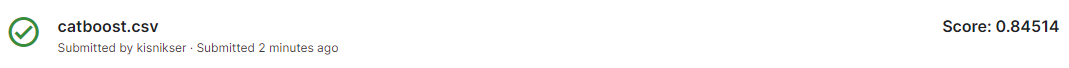

### Random Forest


In [41]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [42]:
param_grid = {
    "min_samples_split": [5, 10, 20, 30, 40, 50], # range(2, 200),
    "min_samples_leaf": [5, 10, 20, 30, 40, 50] # range(1, 200)
}

In [43]:
clf = RandomForestClassifier(n_estimators = 200)

In [44]:
grid_search = GridSearchCV(clf, param_grid, scoring = "roc_auc", cv = 5)

In [46]:
rfc = grid_search.fit(X_train_cat, y_train_cat)

In [47]:
print('The best ROC-AUC score is', rfc.best_score_)
print('The best params are', rfc.best_params_)

The best ROC-AUC score is 0.8457906089291333
The best params are {'min_samples_leaf': 30, 'min_samples_split': 5}


In [49]:
submission = pd.read_csv('./submission.csv', index_col = 'Id')

submission['Churn'] = rfc.predict_proba(X_test_cat)[:, 1]
submission.to_csv('./rfc.csv')

# Предсказания

In [53]:
best_model = rfc

In [56]:
submission = pd.read_csv('./submission.csv', index_col = 'Id')

submission['Churn'] = best_model.predict_proba(X_test_cat)[:, 1]
submission.to_csv('./my_submission.csv')

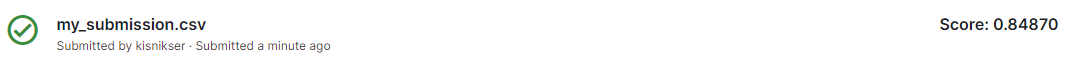

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.